# Summarize models

This notebook summarizes all metrics required for model comparison including the following:

  1. Standardized predictor distributions
  1. Model residuals by predictor
  1. Forecast errors overall and by timepoint
  1. Model coefficients averages and by timepoint
  
## Table of contents

 1. [Import and define functions](#Import-and-define-functions)
 1. [Define configuration settings](#Define-configuration-settings)
 1. [Load data](#Load-data)
 1. [Summarize raw predictors](#Summarize-raw-predictors)
 1. [Summarize standardized predictor distributions](#Summarize-standardized-predictor-distributions)
 1. [Summarize model residuals](#Summarize-model-residuals)
 1. [Summarize observed and predicted frequencies and growth rates](#Summarize-observed-and-predicted-frequencies-and-growth-rates)
 1. [Summarize model forecasting error](#Summarize-model-forecasting-error)

## Import and define functions
[back to top](#Summarize-models)

In [281]:
import Bio.SeqIO
from collections import defaultdict
import glob
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import networkx as nx
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns

%matplotlib inline

In [282]:
#sns.set_style("ticks")
plt.style.use("huddlej")

In [283]:
mpl.rcParams['savefig.dpi'] = 200
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.weight'] = 300
mpl.rcParams['axes.labelweight'] = 300
mpl.rcParams['font.size'] = 18

In [284]:
!pwd

/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses


In [285]:
def mean_absolute_error(observed, estimated, **kwargs):
    """
    Calculates the mean absolute error between observed and estimated values.

    Parameters
    ----------
    observed : numpy.ndarray
        observed values

    estimated : numpy.ndarray
        estimated values

    Returns
    -------
    float :
        mean absolute error between observed and estimated values
    """
    return np.mean(np.abs(observed - estimated))

def root_mean_square_error(observed, estimated, **kwargs):
    """
    Calculates the root mean square error between observed and estimated values.

    Parameters
    ----------
    observed : numpy.ndarray
        observed values

    estimated : numpy.ndarray
        estimated values

    Returns
    -------
    float :
        root mean square error between observed and estimated values
    """
    return np.sqrt(np.mean((observed - estimated) ** 2))

def mean_square_error(observed, estimated, **kwargs):
    """
    Calculates the mean square error between observed and estimated values.

    Parameters
    ----------
    observed : numpy.ndarray
        observed values

    estimated : numpy.ndarray
        estimated values

    Returns
    -------
    float :
        mean square error between observed and estimated values
    """
    return np.mean((observed - estimated) ** 2)

def facet_time_plot(data, value, value_label, timepoint_column="timepoint", predictors_column="predictors", hue=None,
                    height=4, aspect=1, col_order=None, col_wrap=4):
    g = sns.FacetGrid(data, col=predictors_column, col_order=col_order, col_wrap=col_wrap, hue=hue, height=height, aspect=aspect)
    g.map_dataframe(sns.lineplot, x=timepoint_column, y=value, estimator="mean", ci="sd", markers=True, dashes=False,
                   style=predictors_column, markersize=15)
    g.set_axis_labels("Date", value_label)

    for ax in g.axes.flatten():
        ax.axhline(y=0, color="#cccccc", zorder=-10)

        #start, end = [int(value) for value in ax.get_xlim()]
        #end = end + 1
        #stepsize = 2.0
        #ax.xaxis.set_ticks(np.arange(start, end, stepsize))

        #labels = ax.get_xticklabels()
        #output = plt.setp(labels, rotation=30)
        
    plt.gcf().autofmt_xdate()
    return g

## Define configuration settings
[back to top](#Summarize-models)

In [286]:
predictor_names_order = [
    "naive",
    "delta_frequency",
    "lbi",
    "ep_x",
    "cTiterSub_x",
    "ne_star",
    "dms_star",
    "lbi-delta_frequency",
    "lbi-dms_star",
    "lbi-ep_x-ne_star"
]

predictor_names_order = [
    "naive",
    "delta_frequency",
    "lbi",
    "ep_x",
    "cTiterSub_x",
    "ne_star",
    "dms_star"
]

In [287]:
data_root = "../results/builds/h3n2/10_viruses_per_month/sample_0/1994-10-01--2015-10-01/"
data_root = "../results/builds/h3n2/90_viruses_per_month/sample_0/2000-10-01--2015-10-01/"
data_root = "../results/builds/h3n2/1_viruses_per_month/sample_0/2000-10-01--2015-10-01/"

## Load data
[back to top](#Summarize-models)

In [432]:
tip_attributes_df = pd.read_table(data_root + "standardized_tip_attributes.tsv", parse_dates=["timepoint"])

In [433]:
tips_to_clades_df = pd.read_table(data_root + "tips_to_clades.tsv", parse_dates=["timepoint"])

In [434]:
model_jsons = glob.glob(data_root + "models/*.json")

In [435]:
models_by_predictors = {}

for model_json in model_jsons:
    with open(model_json, "r") as fh:
        data = json.load(fh)
        models_by_predictors["-".join(data["predictors"])] = data

In [436]:
models_by_predictors["lbi"]["cost_function"]

'diffsum'

In [437]:
models_by_predictors["lbi"]["l1_lambda"]

0.01

In [438]:
models_by_predictors["lbi"]["training_window"]

6

In [439]:
models_by_predictors["lbi"]["pseudocount"]

0.0

In [440]:
type(models_by_predictors["lbi"])

dict

In [441]:
models_by_predictors.keys()

dict_keys(['dms_star', 'ep', 'lbi', 'ne_star', 'delta_frequency', 'cTiterSub_x', 'ep_x', 'naive', 'cTiterSub'])

In [442]:
models_by_predictors["lbi"].keys()

dict_keys(['scores', 'predictors', 'cv_error_mean', 'cv_error_std', 'coefficients_mean', 'coefficients_std', 'cost_function', 'l1_lambda', 'delta_months', 'training_window', 'pseudocount'])

In [443]:
models_by_predictors["lbi"]["scores"][0].keys()

dict_keys(['predictors', 'training_data', 'training_n', 'training_error', 'coefficients', 'validation_data', 'validation_n', 'validation_error', 'last_training_timepoint', 'validation_timepoint'])

In [444]:
models_by_predictors["lbi"]["scores"][0]["training_n"]

288

In [445]:
models_by_predictors["lbi"]["scores"][0]["validation_data"].keys()

dict_keys(['X', 'y', 'y_hat'])

In [446]:
models_by_predictors["lbi"]["scores"][0]["coefficients"]

[18.392309876548563]

In [447]:
len(models_by_predictors["lbi"]["scores"])

7

Build data frames for plotting from the model scores.

In [448]:
overall_errors = []
errors_by_time = []
overall_coefficients = []
coefficients_by_time = []
frequency_dfs = []
residuals_dfs = []

for predictors, model in models_by_predictors.items():
    overall_errors.append({
        "predictors": predictors,
        "cv_error_mean": model["cv_error_mean"],
        "cv_error_std": model["cv_error_std"]
    })

    for predictor, mean, std in zip(model["predictors"], model["coefficients_mean"], model["coefficients_std"]):
        overall_coefficients.append({
            "predictors": predictors,
            "predictor": predictor,
            "mean": mean,
            "std": std
        })
    
    for scores in model["scores"]:
        errors_by_time.append({
            "predictors": predictors,
            "validation_timepoint": scores["validation_timepoint"],
            "validation_error": scores["validation_error"],
            "validation_n": scores["validation_n"]
        })
        
        for predictor, coefficient in zip(model["predictors"], scores["coefficients"]):
            coefficients_by_time.append({
                "predictors": predictors,
                "predictor": predictor,
                "coefficient": coefficient,
                "validation_timepoint": scores["validation_timepoint"]
            })
        
        X = pd.DataFrame(scores["validation_data"]["X"])
        X["timepoint"] = pd.to_datetime(X["timepoint"])

        y = pd.DataFrame(scores["validation_data"]["y"])
        y["timepoint"] = pd.to_datetime(y["timepoint"])

        y_hat = pd.DataFrame(scores["validation_data"]["y_hat"])
        y_hat["timepoint"] = pd.to_datetime(y_hat["timepoint"])

        frequency_df = y.merge(y_hat, on=["timepoint", "strain"], suffixes=["", "_hat"])
        frequency_df["residual"] = frequency_df["y"] - frequency_df["y_hat"]
        frequency_df["validation_timepoint"] = pd.to_datetime(scores["validation_timepoint"])
        frequency_df["predictors"] = predictors
        frequency_dfs.append(frequency_df)

        training_X = pd.DataFrame(scores["training_data"]["X"])
        training_X["timepoint"] = pd.to_datetime(training_X["timepoint"])

        training_y = pd.DataFrame(scores["training_data"]["y"])
        training_y["timepoint"] = pd.to_datetime(training_y["timepoint"])
        training_y_hat = pd.DataFrame(scores["training_data"]["y_hat"])
        training_y_hat["timepoint"] = pd.to_datetime(training_y_hat["timepoint"])
        residual_df = training_y.merge(training_y_hat, on=["timepoint", "strain"], suffixes=["", "_hat"])
        residual_df["residual"] = residual_df["y"] - residual_df["y_hat"]
        residual_df["validation_timepoint"] = pd.to_datetime(scores["validation_timepoint"])
        residual_df["predictors"] = predictors

        residuals_dfs.append(residual_df)
        
overall_errors_df = pd.DataFrame(overall_errors)
errors_by_time_df = pd.DataFrame(errors_by_time)
overall_coefficients_df = pd.DataFrame(overall_coefficients)
coefficients_by_time_df = pd.DataFrame(coefficients_by_time)
frequency_df = pd.concat(frequency_dfs, ignore_index=True)
residual_df = pd.concat(residuals_dfs, ignore_index=True)

In [449]:
residual_df.head()

strain  timepoint         y     frequency  \
0        A/California/7/2004 2004-10-01  1.248581  5.929803e-06   
1      A/Canterbury/201/2004 2004-10-01  0.912550  1.554019e-02   
2       A/Canterbury/23/2004 2004-10-01  0.307861  6.856424e-01   
3  A/HongKong/CUHK33894/2004 2004-10-01  0.000022  8.608819e-08   
4  A/HongKong/CUHK35435/2004 2004-10-01  0.001594  1.300207e-05   

   weighted_distance_to_future  weighted_distance_to_present         y_hat  \
0                     6.375681                      5.069707  3.006236e-05   
1                     4.659788                      3.853049  5.987710e-02   
2                     3.659789                      3.244720  2.224718e+00   
3                     7.374615                      6.195280  5.333404e-07   
4                     6.374616                      5.195287  6.754948e-05   

         y_diff  residual validation_timepoint predictors  
0  3.780653e-05  1.248551           2011-10-01   dms_star  
1  7.241398e-02  0.852672           2011-10-01   dms_star  
2  2.509307e+00 -1.916856           2011-10-01   dms_star  
3  6.348673e-07  0.000022           2011-10-01   dms_star  
4  8.288319e-05  0.001526           2011-10-01   dms_star

In [450]:
training_y.head()

strain  timepoint         y
0        A/Argentina/3726/2007 2007-10-01  0.000004
1       A/Bangladesh/1695/2007 2007-10-01  0.001023
2       A/Bangladesh/9745/2007 2007-10-01  0.000004
3  A/BritishColumbia/1287/2007 2007-10-01  1.659106
4          A/Cambodia/384/2007 2007-10-01  0.404970

In [451]:
training_y_hat.head()

frequency                       strain  timepoint  \
0  1.163092e-09        A/Argentina/3726/2007 2007-10-01   
1  1.279401e-07       A/Bangladesh/1695/2007 2007-10-01   
2  1.163092e-09       A/Bangladesh/9745/2007 2007-10-01   
3  2.045809e-04  A/BritishColumbia/1287/2007 2007-10-01   
4  6.276277e-05          A/Cambodia/384/2007 2007-10-01   

   weighted_distance_to_future  weighted_distance_to_present             y  \
0                     3.785508                      3.971200  4.618871e-09   
1                     9.296945                      9.277870  1.187012e-06   
2                     3.785508                      3.971200  4.618871e-09   
3                     9.432420                      7.523810  1.539228e-03   
4                     7.504721                      6.358429  3.990726e-04   

         y_diff  
0  4.402894e-09  
1  1.189452e-06  
2  4.402894e-09  
3  1.929693e-03  
4  4.710171e-04

In [452]:
residual_df.head()

strain  timepoint         y     frequency  \
0        A/California/7/2004 2004-10-01  1.248581  5.929803e-06   
1      A/Canterbury/201/2004 2004-10-01  0.912550  1.554019e-02   
2       A/Canterbury/23/2004 2004-10-01  0.307861  6.856424e-01   
3  A/HongKong/CUHK33894/2004 2004-10-01  0.000022  8.608819e-08   
4  A/HongKong/CUHK35435/2004 2004-10-01  0.001594  1.300207e-05   

   weighted_distance_to_future  weighted_distance_to_present         y_hat  \
0                     6.375681                      5.069707  3.006236e-05   
1                     4.659788                      3.853049  5.987710e-02   
2                     3.659789                      3.244720  2.224718e+00   
3                     7.374615                      6.195280  5.333404e-07   
4                     6.374616                      5.195287  6.754948e-05   

         y_diff  residual validation_timepoint predictors  
0  3.780653e-05  1.248551           2011-10-01   dms_star  
1  7.241398e-02  0.852672           2011-10-01   dms_star  
2  2.509307e+00 -1.916856           2011-10-01   dms_star  
3  6.348673e-07  0.000022           2011-10-01   dms_star  
4  8.288319e-05  0.001526           2011-10-01   dms_star

In [453]:
residual_df.shape

(23598, 11)

In [454]:
frequency_df.head()

strain  timepoint         y  frequency  \
0     A/Adjame/GR765/2011 2011-10-01  0.717610   0.000211   
1   A/Argentina/8823/2011 2011-10-01  0.117335   0.023363   
2  A/Bangladesh/3564/2011 2011-10-01  0.021536   0.000007   
3  A/Bangladesh/5006/2011 2011-10-01  0.120589   0.047342   
4  A/Bangladesh/5071/2011 2011-10-01  0.000029   0.000012   

   weighted_distance_to_future  weighted_distance_to_present     y_hat  \
0                     8.797696                      7.766503  0.001638   
1                    11.560120                      9.226488  0.215554   
2                     6.862932                      6.535858  0.000048   
3                     5.862934                      5.639843  0.267001   
4                     5.862934                      5.639843  0.000065   

     y_diff  residual validation_timepoint predictors  
0  0.001855  0.715972           2011-10-01   dms_star  
1  0.270074 -0.098219           2011-10-01   dms_star  
2  0.000050  0.021488           2011-10-01   dms_star  
3  0.277563 -0.146413           2011-10-01   dms_star  
4  0.000067 -0.000036           2011-10-01   dms_star

In [455]:
overall_errors_df.sort_values("cv_error_mean")

cv_error_mean  cv_error_std       predictors
2       6.687972      2.598325              lbi
4       7.963897      1.847042  delta_frequency
3       7.967114      1.571713          ne_star
8       8.337949      1.744750        cTiterSub
7       8.514560      1.003108            naive
5       9.026303      2.149961      cTiterSub_x
0       9.081247      1.835223         dms_star
1       9.662718      2.312952               ep
6      10.004883      2.047698             ep_x

In [456]:
errors_by_time_df.head()

predictors  validation_error  validation_n validation_timepoint
0   dms_star          7.547656            39           2011-10-01
1   dms_star          9.605958            45           2012-04-01
2   dms_star         12.734542            40           2012-10-01
3   dms_star          6.848601            43           2013-04-01
4   dms_star          7.737192            42           2013-10-01

In [457]:
frequency_df.head()

strain  timepoint         y  frequency  \
0     A/Adjame/GR765/2011 2011-10-01  0.717610   0.000211   
1   A/Argentina/8823/2011 2011-10-01  0.117335   0.023363   
2  A/Bangladesh/3564/2011 2011-10-01  0.021536   0.000007   
3  A/Bangladesh/5006/2011 2011-10-01  0.120589   0.047342   
4  A/Bangladesh/5071/2011 2011-10-01  0.000029   0.000012   

   weighted_distance_to_future  weighted_distance_to_present     y_hat  \
0                     8.797696                      7.766503  0.001638   
1                    11.560120                      9.226488  0.215554   
2                     6.862932                      6.535858  0.000048   
3                     5.862934                      5.639843  0.267001   
4                     5.862934                      5.639843  0.000065   

     y_diff  residual validation_timepoint predictors  
0  0.001855  0.715972           2011-10-01   dms_star  
1  0.270074 -0.098219           2011-10-01   dms_star  
2  0.000050  0.021488           2011-10-01   dms_star  
3  0.277563 -0.146413           2011-10-01   dms_star  
4  0.000067 -0.000036           2011-10-01   dms_star

## Summarize raw predictors
[back to top](#Summarize-models)

In [314]:
raw_tip_attributes_df = pd.read_table(data_root + "tip_attributes.tsv")

In addition to the raw tip attributes, load the standardization metrics associated with each predictor for comparison to the overall distributions per predictor per timepoint shown below.

In [315]:
standardization_stats = pd.read_csv(data_root + "standardization_statistics.json", sep="\t")

In [316]:
standardization_stats

mean        var        predictor
0   1.850296   0.652317        cTiterSub
1  -6.792508   0.080170      cTiterSub_x
2   0.278047   0.062286  delta_frequency
3  -1.899600  11.637004         dms_star
4  11.440000   1.846400               ep
5  -3.418388   0.216718             ep_x
6   0.287852   0.020777              lbi
7   0.000000   0.000000            naive
8   1.360000   1.110400          ne_star

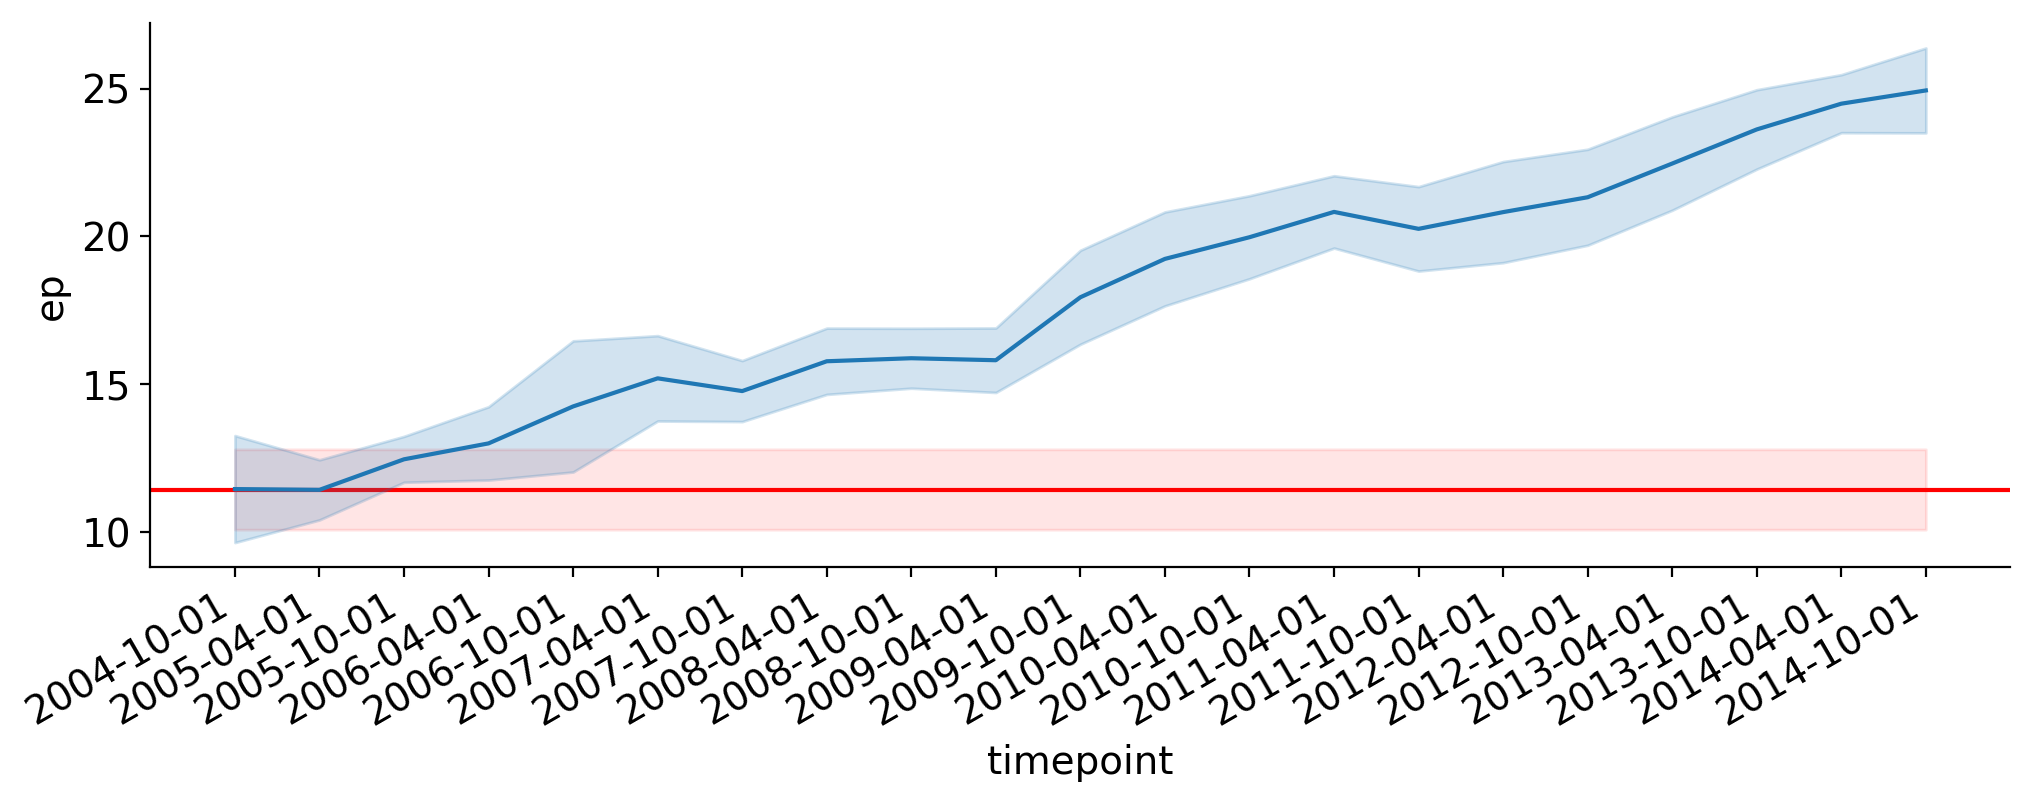

In [317]:
predictor = "ep"
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.lineplot(
    x="timepoint",
    y=predictor,
    data=raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"],
    ci="sd",
    ax=ax
)
plt.gcf().autofmt_xdate()
#ax.set_ylim(bottom=0)

# Draw the standardization mean and standard deviation for comparison.
mean = standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0]
std = np.sqrt(standardization_stats[standardization_stats["predictor"] == predictor]["var"].values[0])

ax.axhline(y=standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0], color="red", zorder=-10)
ax.fill_between(
    raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"]["timepoint"].values,
    mean - std,
    mean + std,
    color="red",
    alpha=0.1,
    zorder=-10
)

Text(0,0.5,'Epitope cross-immunity')

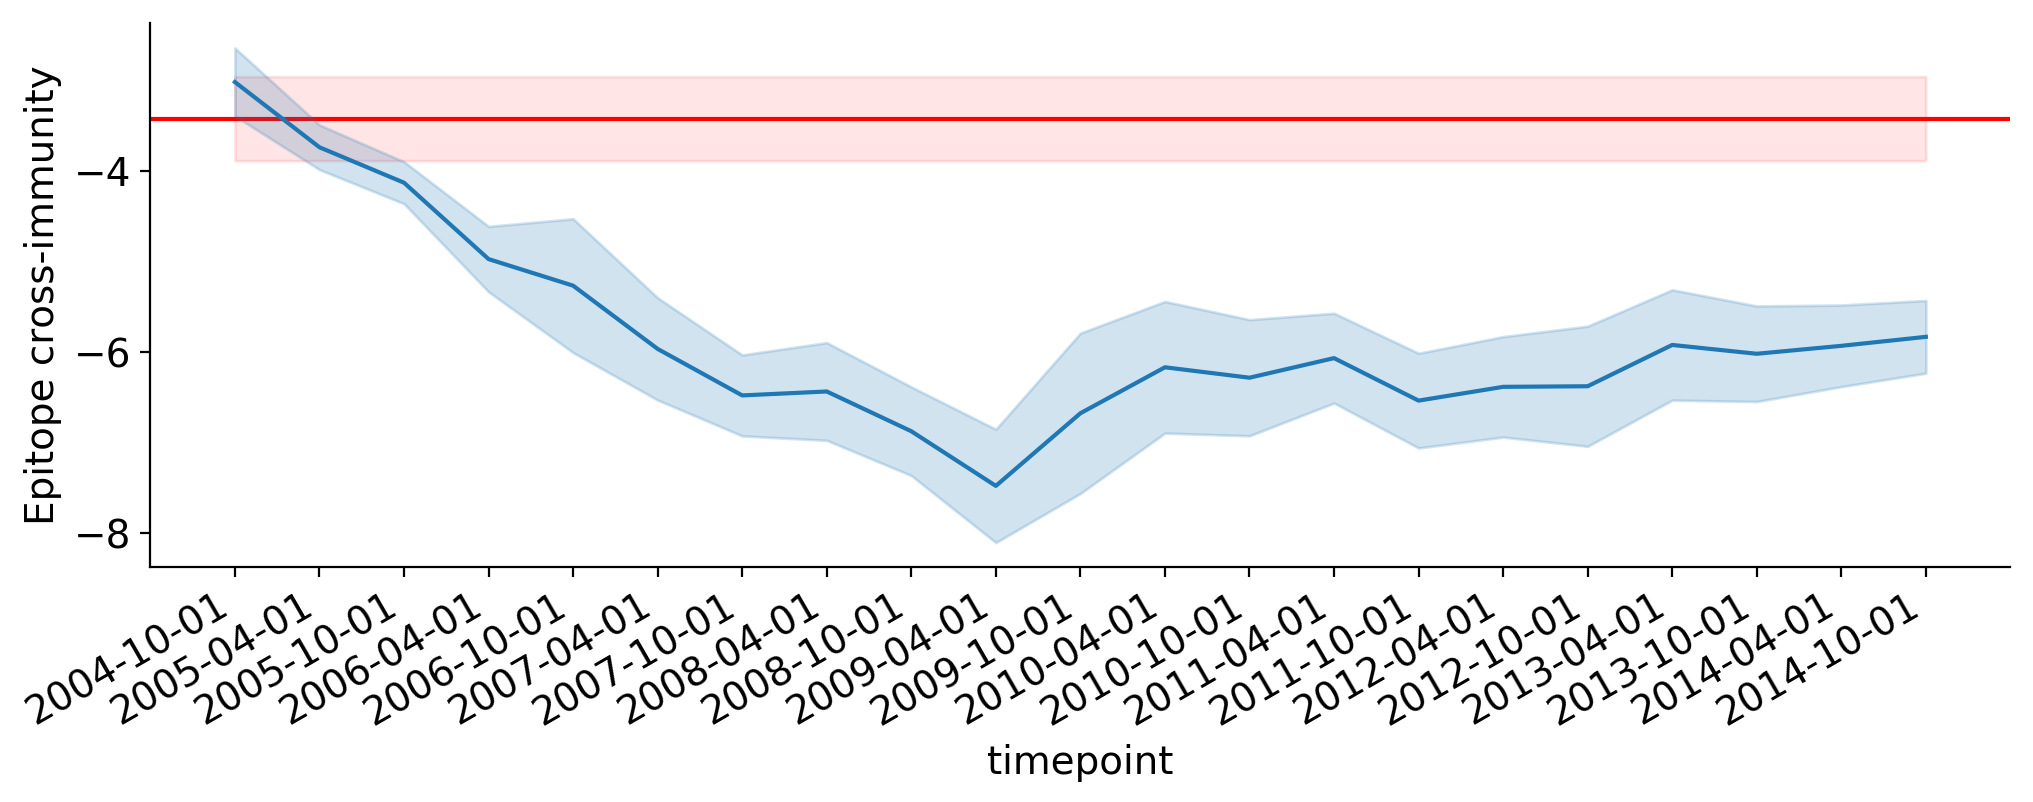

In [318]:
predictor = "ep_x"
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.lineplot(
    x="timepoint",
    y=predictor,
    data=raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"],
    ci="sd",
    ax=ax
)
plt.gcf().autofmt_xdate()
#ax.set_ylim(bottom=0)

# Draw the standardization mean and standard deviation for comparison.
mean = standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0]
std = np.sqrt(standardization_stats[standardization_stats["predictor"] == predictor]["var"].values[0])

ax.axhline(y=standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0], color="red", zorder=-10)
ax.fill_between(
    raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"]["timepoint"].values,
    mean - std,
    mean + std,
    color="red",
    alpha=0.1,
    zorder=-10
)
ax.set_ylabel("Epitope cross-immunity")

Text(0,0.5,'std dev of ep_x')

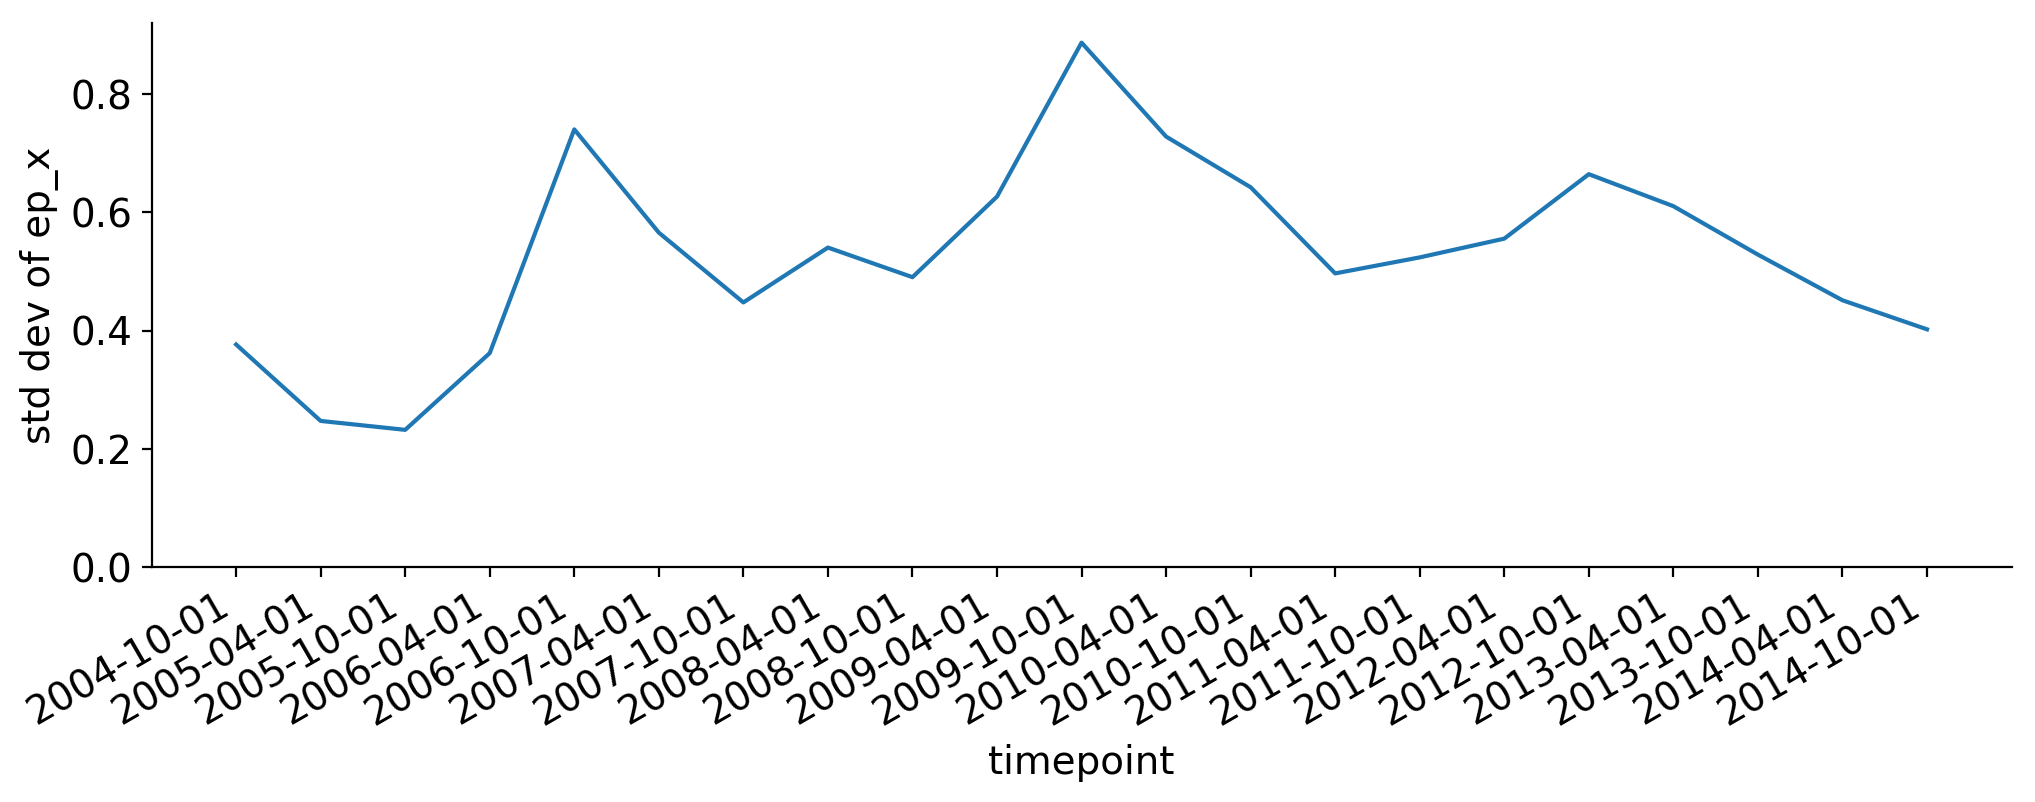

In [319]:
predictor = "ep_x"
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.lineplot(
    x="timepoint",
    y=predictor,
    data=raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"],
    estimator="std",
    ci=None,
    ax=ax
)
plt.gcf().autofmt_xdate()
ax.set_ylim(bottom=0)
ax.set_ylabel("std dev of %s" % predictor)

ValueError: Could not interpret input 'ep_star'

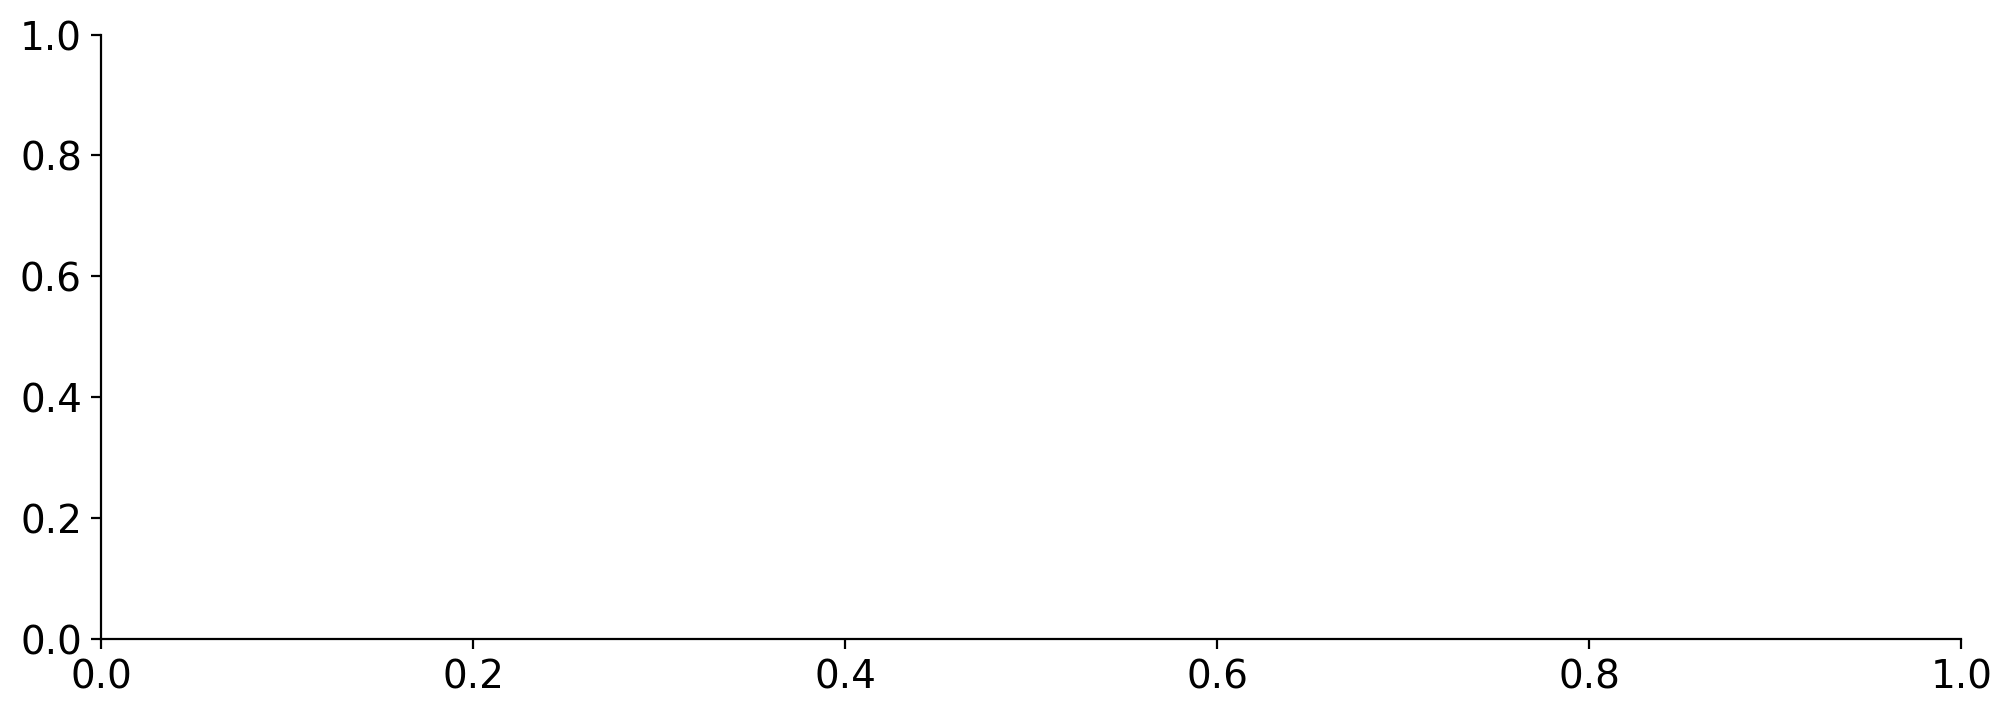

In [320]:
predictor = "ep_star"
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.lineplot(
    x="timepoint",
    y=predictor,
    data=raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"],
    ci="sd",
    ax=ax
)
plt.gcf().autofmt_xdate()
#ax.set_ylim(bottom=0)

# Draw the standardization mean and standard deviation for comparison.
mean = standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0]
std = np.sqrt(standardization_stats[standardization_stats["predictor"] == predictor]["var"].values[0])

ax.axhline(y=standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0], color="red", zorder=-10)
ax.fill_between(
    raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"]["timepoint"].values,
    mean - std,
    mean + std,
    color="red",
    alpha=0.1,
    zorder=-10
)

In [ ]:
predictor = "cTiterSub_star"
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.lineplot(
    x="timepoint",
    y=predictor,
    data=raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"],
    ci="sd",
    ax=ax
)
plt.gcf().autofmt_xdate()
#ax.set_ylim(bottom=0)

# Draw the standardization mean and standard deviation for comparison.
mean = standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0]
std = np.sqrt(standardization_stats[standardization_stats["predictor"] == predictor]["var"].values[0])

ax.axhline(y=standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0], color="red", zorder=-10)
ax.fill_between(
    raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"]["timepoint"].values,
    mean - std,
    mean + std,
    color="red",
    alpha=0.1,
    zorder=-10
)

Text(0,0.5,'HI cross-immunity')

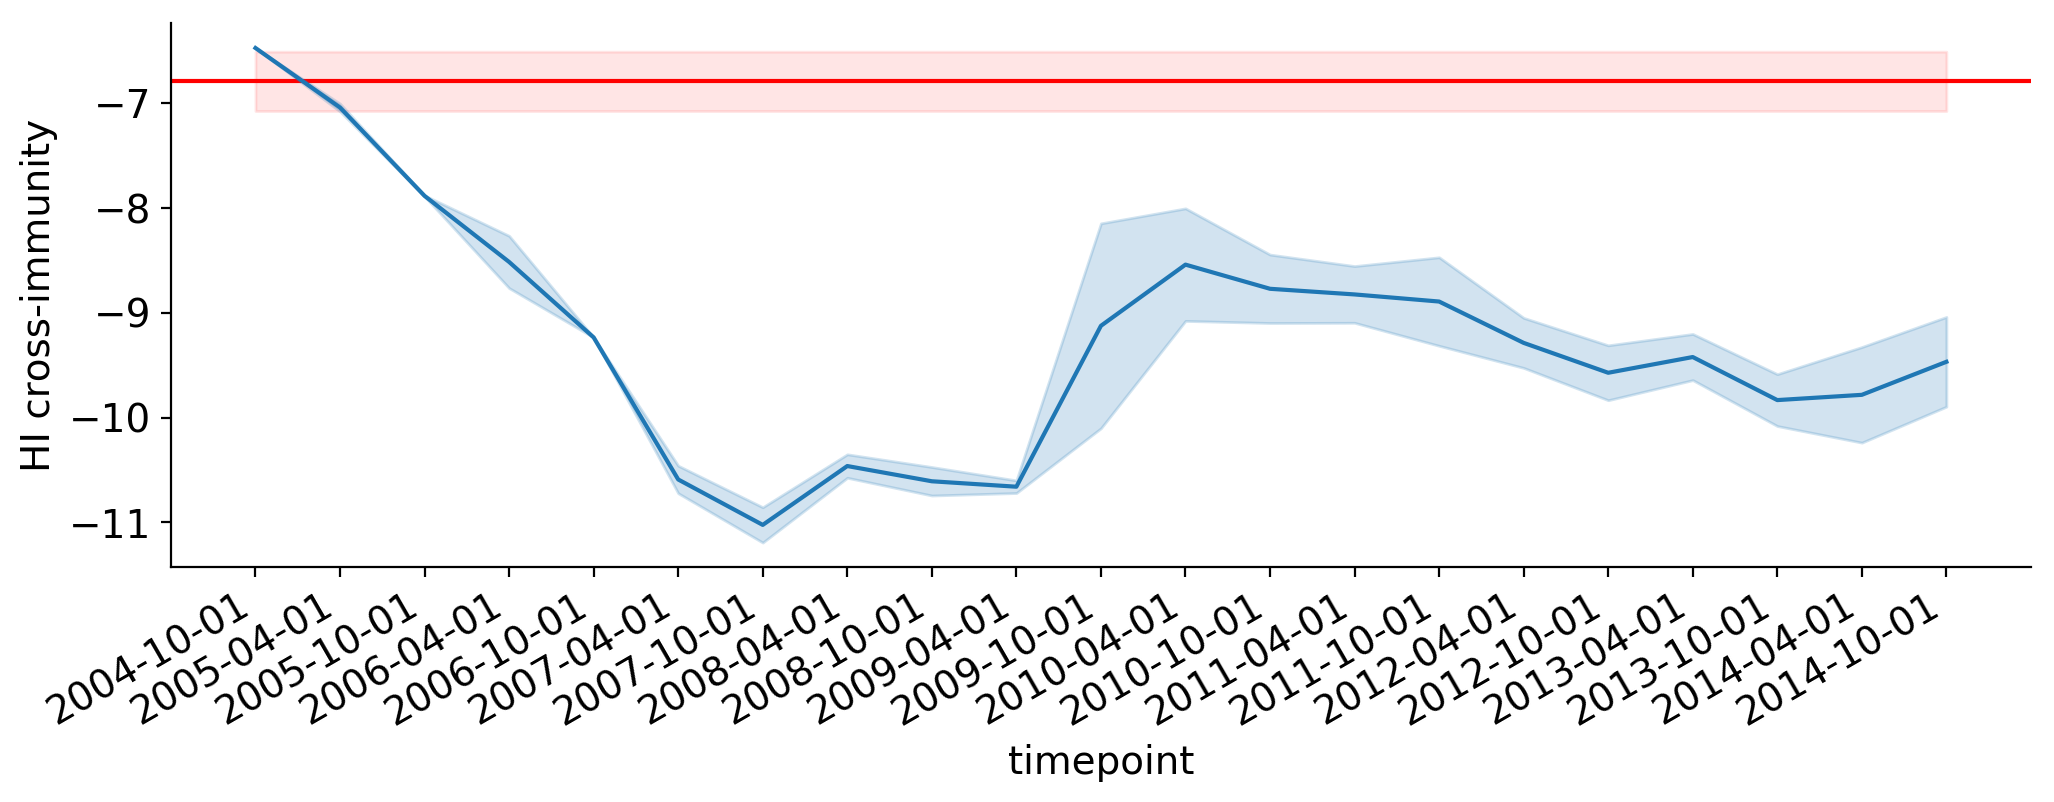

In [321]:
predictor = "cTiterSub_x"
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.lineplot(
    x="timepoint",
    y=predictor,
    data=raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"],
    ci="sd",
    ax=ax
)
plt.gcf().autofmt_xdate()
#ax.set_ylim(bottom=0)

# Draw the standardization mean and standard deviation for comparison.
mean = standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0]
std = np.sqrt(standardization_stats[standardization_stats["predictor"] == predictor]["var"].values[0])

ax.axhline(y=standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0], color="red", zorder=-10)
ax.fill_between(
    raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"]["timepoint"].values,
    mean - std,
    mean + std,
    color="red",
    alpha=0.1,
    zorder=-10
)
ax.set_ylabel("HI cross-immunity")

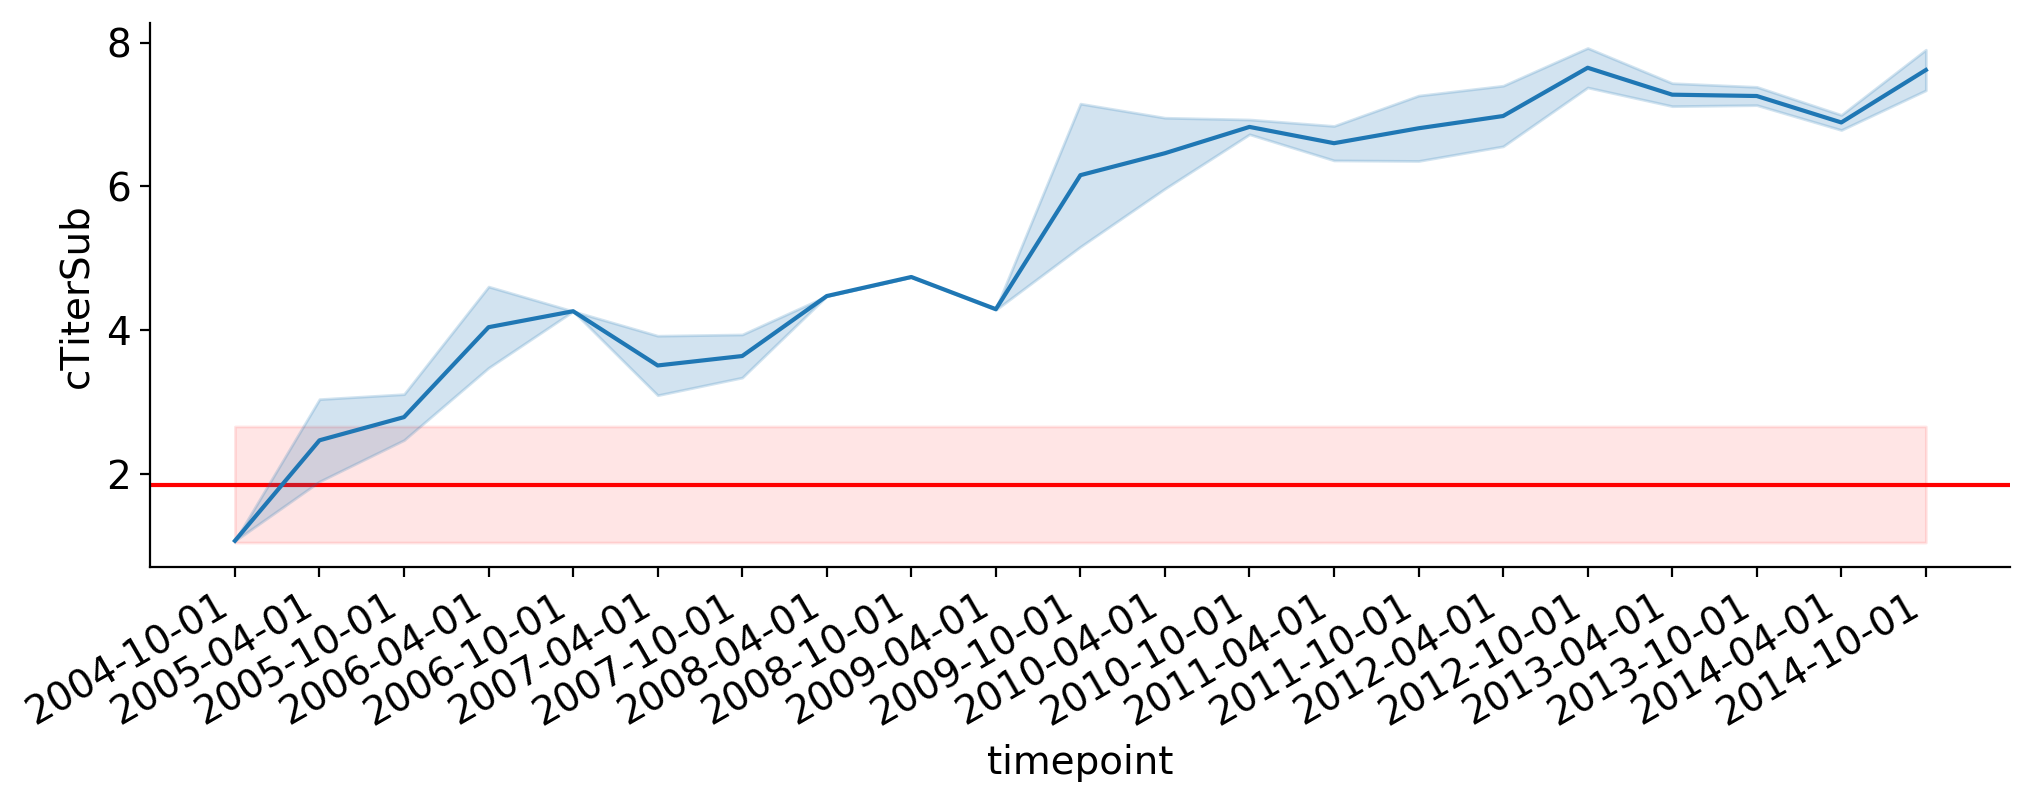

In [322]:
predictor = "cTiterSub"
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.lineplot(
    x="timepoint",
    y=predictor,
    data=raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"],
    ci="sd",
    ax=ax
)
plt.gcf().autofmt_xdate()
#ax.set_ylim(bottom=0)

# Draw the standardization mean and standard deviation for comparison.
mean = standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0]
std = np.sqrt(standardization_stats[standardization_stats["predictor"] == predictor]["var"].values[0])

ax.axhline(y=standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0], color="red", zorder=-10)
ax.fill_between(
    raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"]["timepoint"].values,
    mean - std,
    mean + std,
    color="red",
    alpha=0.1,
    zorder=-10
)

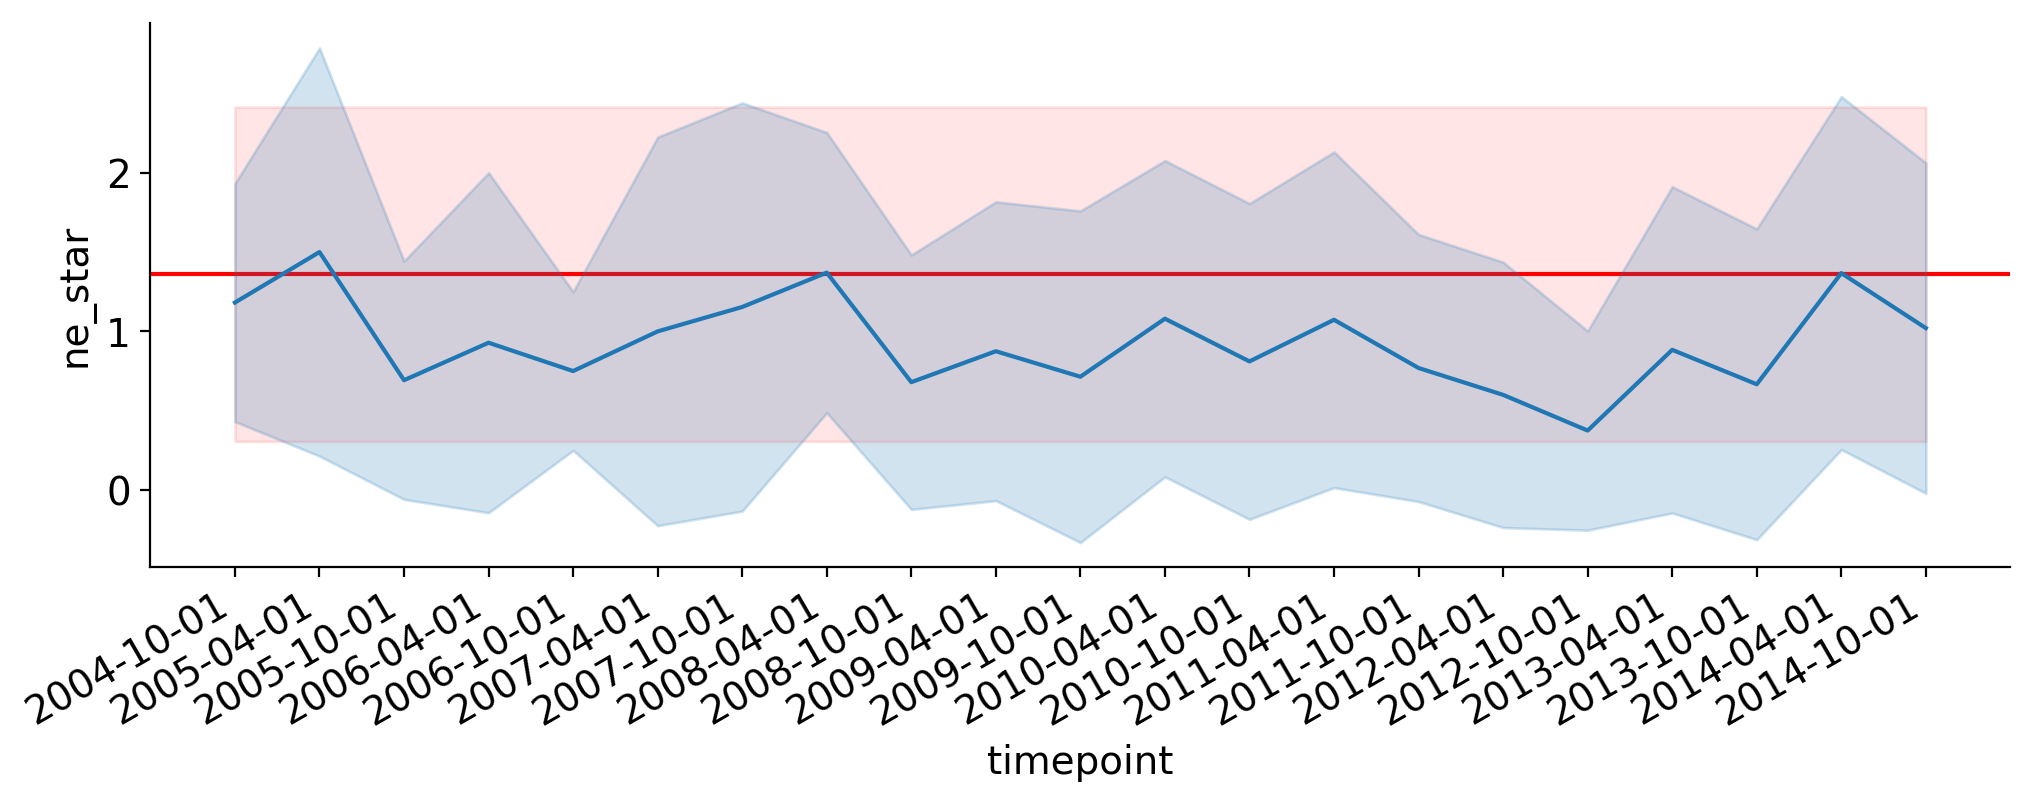

In [323]:
predictor = "ne_star"
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.lineplot(
    x="timepoint",
    y=predictor,
    data=raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"],
    ci="sd",
    ax=ax
)
plt.gcf().autofmt_xdate()
#ax.set_ylim(bottom=0)

# Draw the standardization mean and standard deviation for comparison.
mean = standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0]
std = np.sqrt(standardization_stats[standardization_stats["predictor"] == predictor]["var"].values[0])

ax.axhline(y=standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0], color="red", zorder=-10)
ax.fill_between(
    raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"]["timepoint"].values,
    mean - std,
    mean + std,
    color="red",
    alpha=0.1,
    zorder=-10
)

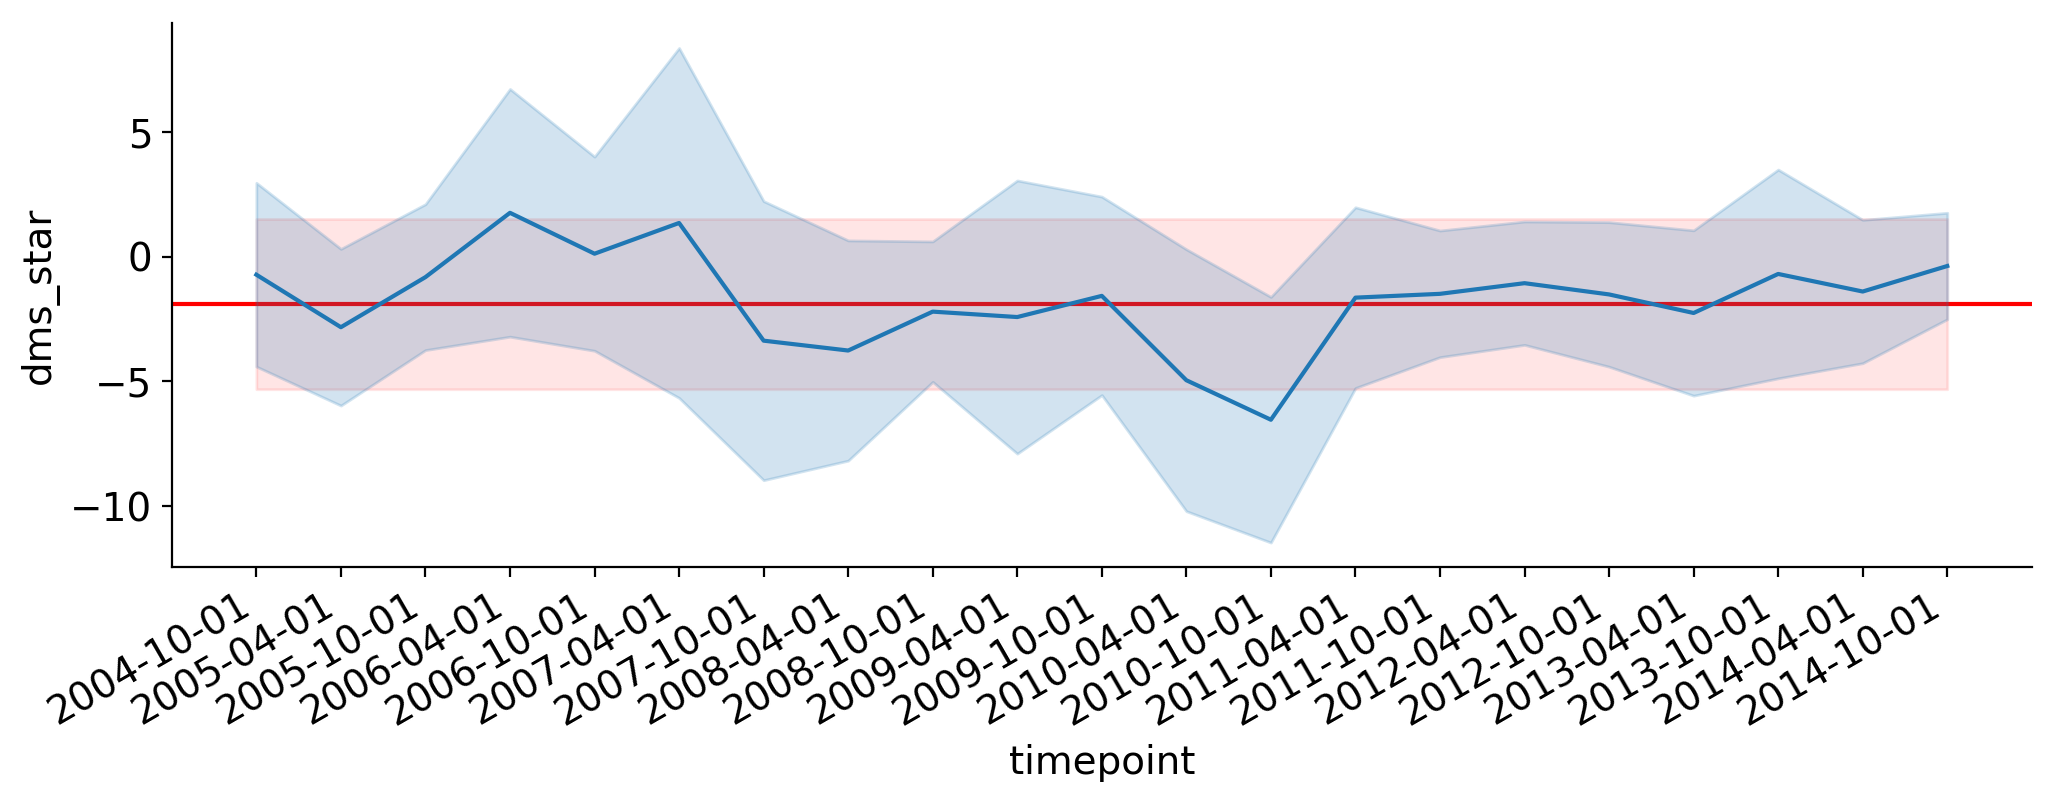

In [324]:
predictor = "dms_star"
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.lineplot(
    x="timepoint",
    y=predictor,
    data=raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"],
    ci="sd",
    ax=ax
)
plt.gcf().autofmt_xdate()
#ax.set_ylim(bottom=0)

# Draw the standardization mean and standard deviation for comparison.
mean = standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0]
std = np.sqrt(standardization_stats[standardization_stats["predictor"] == predictor]["var"].values[0])

ax.axhline(y=standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0], color="red", zorder=-10)
ax.fill_between(
    raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"]["timepoint"].values,
    mean - std,
    mean + std,
    color="red",
    alpha=0.1,
    zorder=-10
)

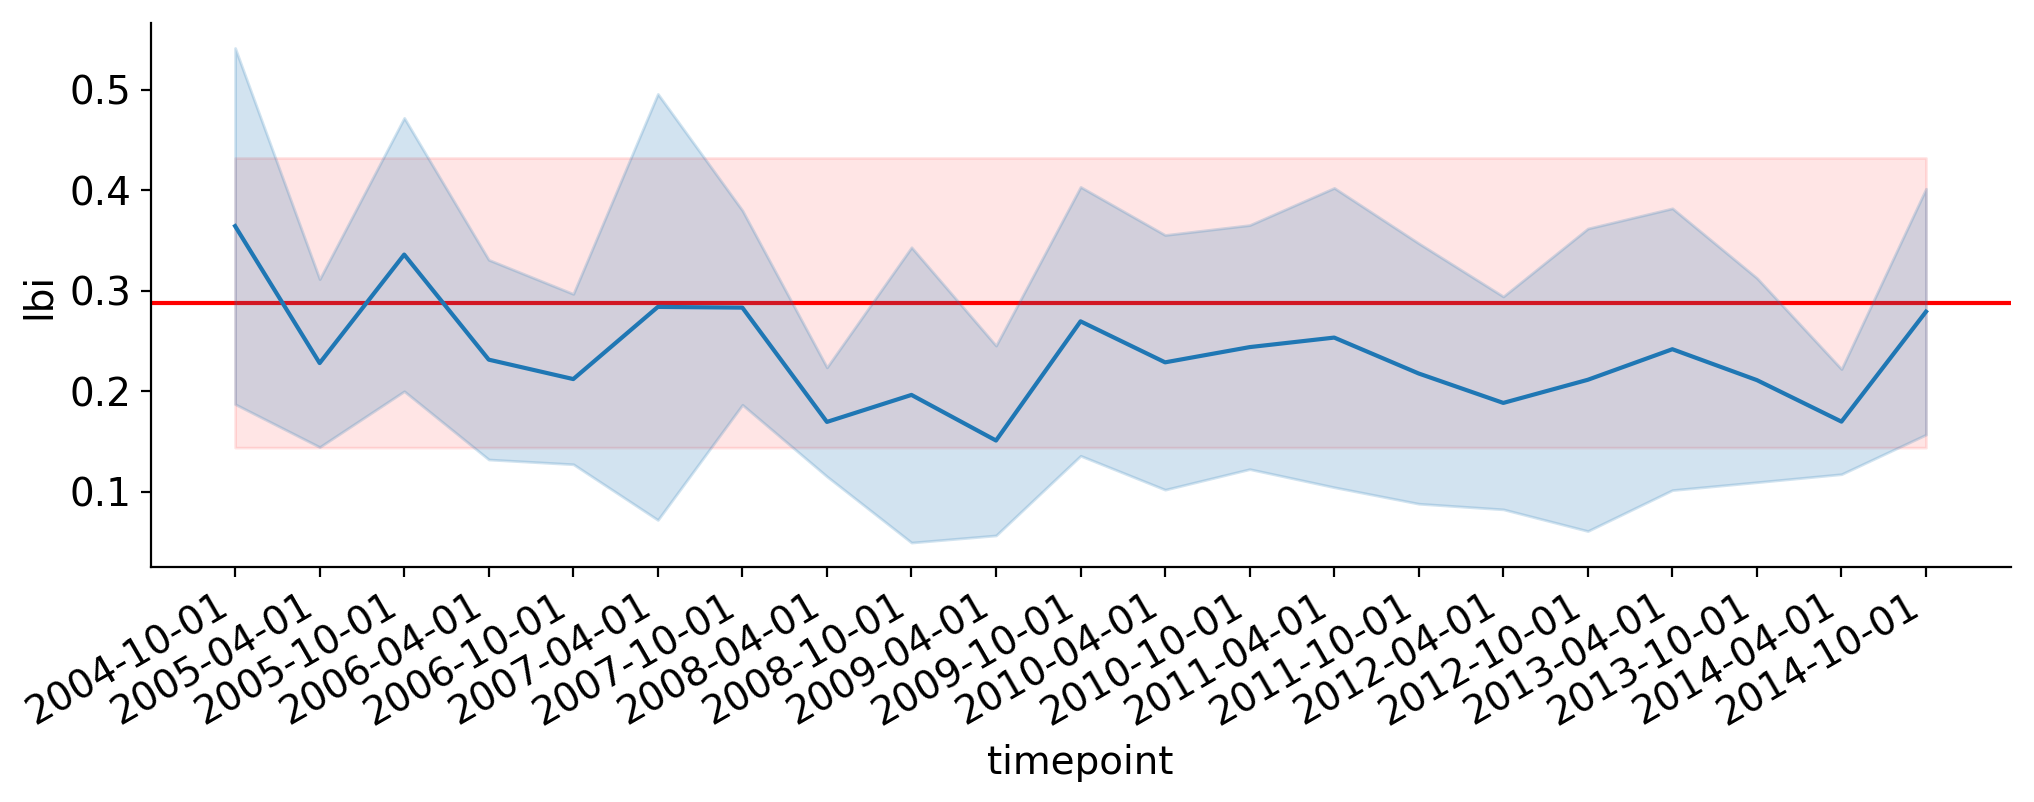

In [325]:
predictor = "lbi"
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.lineplot(
    x="timepoint",
    y=predictor,
    data=raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"],
    ci="sd",
    ax=ax
)
plt.gcf().autofmt_xdate()
#ax.set_ylim(bottom=0)

# Draw the standardization mean and standard deviation for comparison.
mean = standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0]
std = np.sqrt(standardization_stats[standardization_stats["predictor"] == predictor]["var"].values[0])

ax.axhline(y=standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0], color="red", zorder=-10)
ax.fill_between(
    raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"]["timepoint"].values,
    mean - std,
    mean + std,
    color="red",
    alpha=0.1,
    zorder=-10
)

Text(0,0.5,'std dev of lbi')

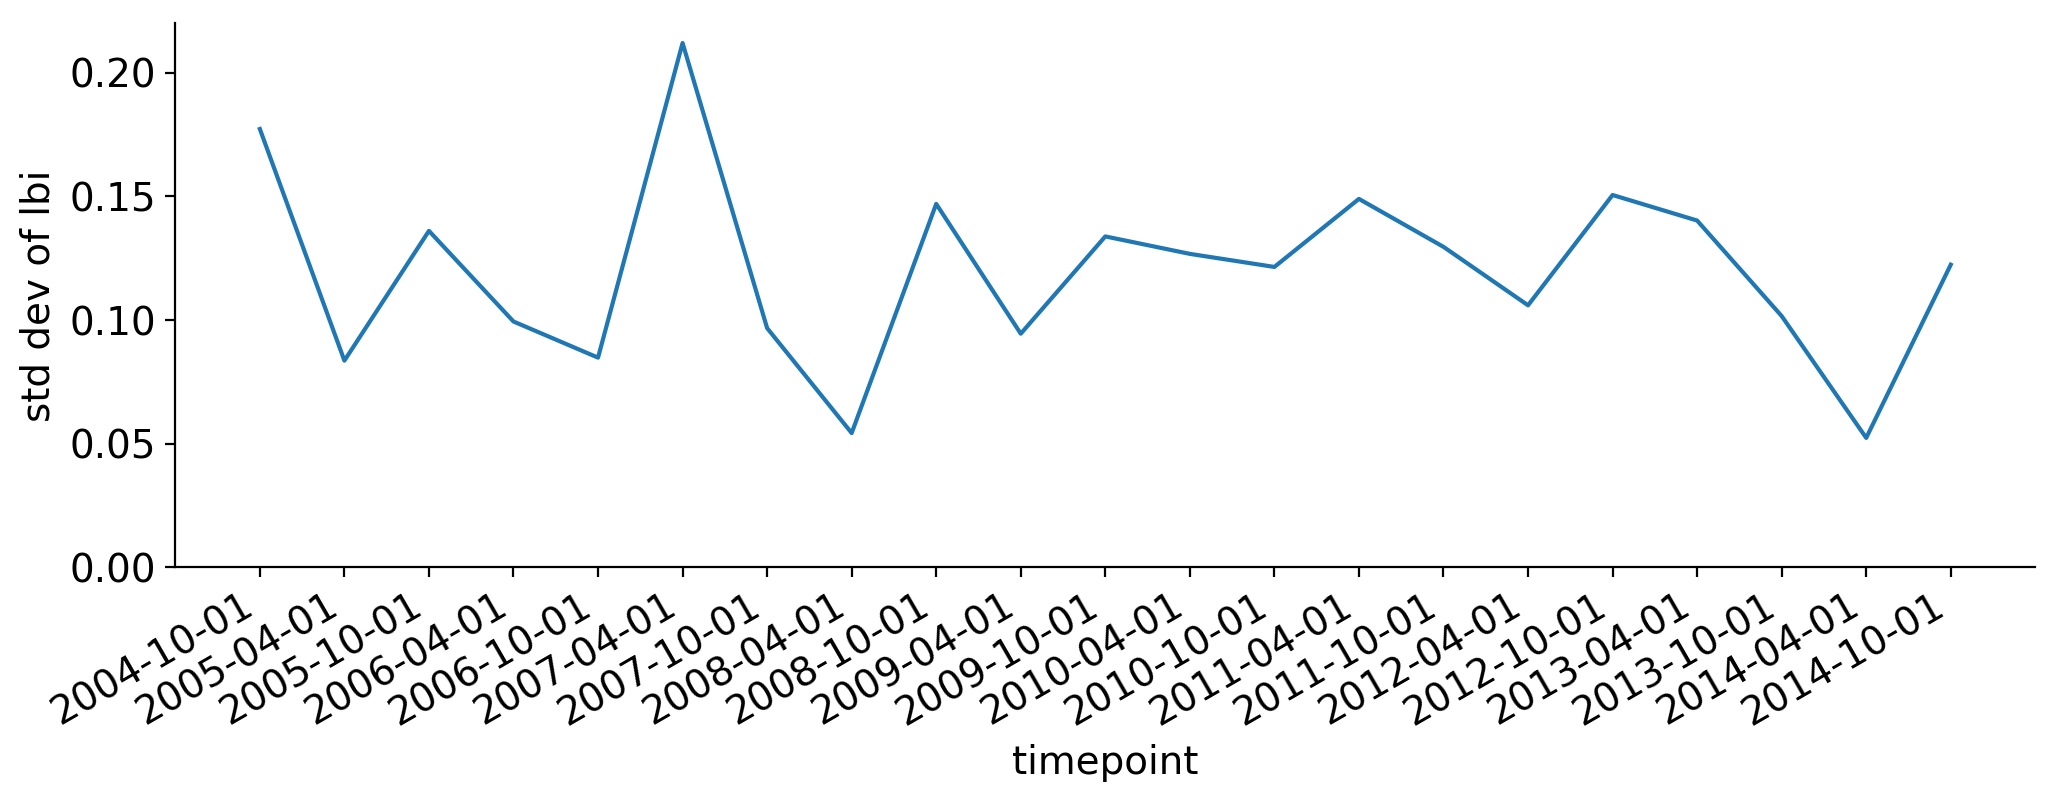

In [326]:
predictor = "lbi"
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.lineplot(
    x="timepoint",
    y=predictor,
    data=raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"],
    estimator="std",
    ci=None,
    ax=ax
)
plt.gcf().autofmt_xdate()
ax.set_ylim(bottom=0)
ax.set_ylabel("std dev of %s" % predictor)

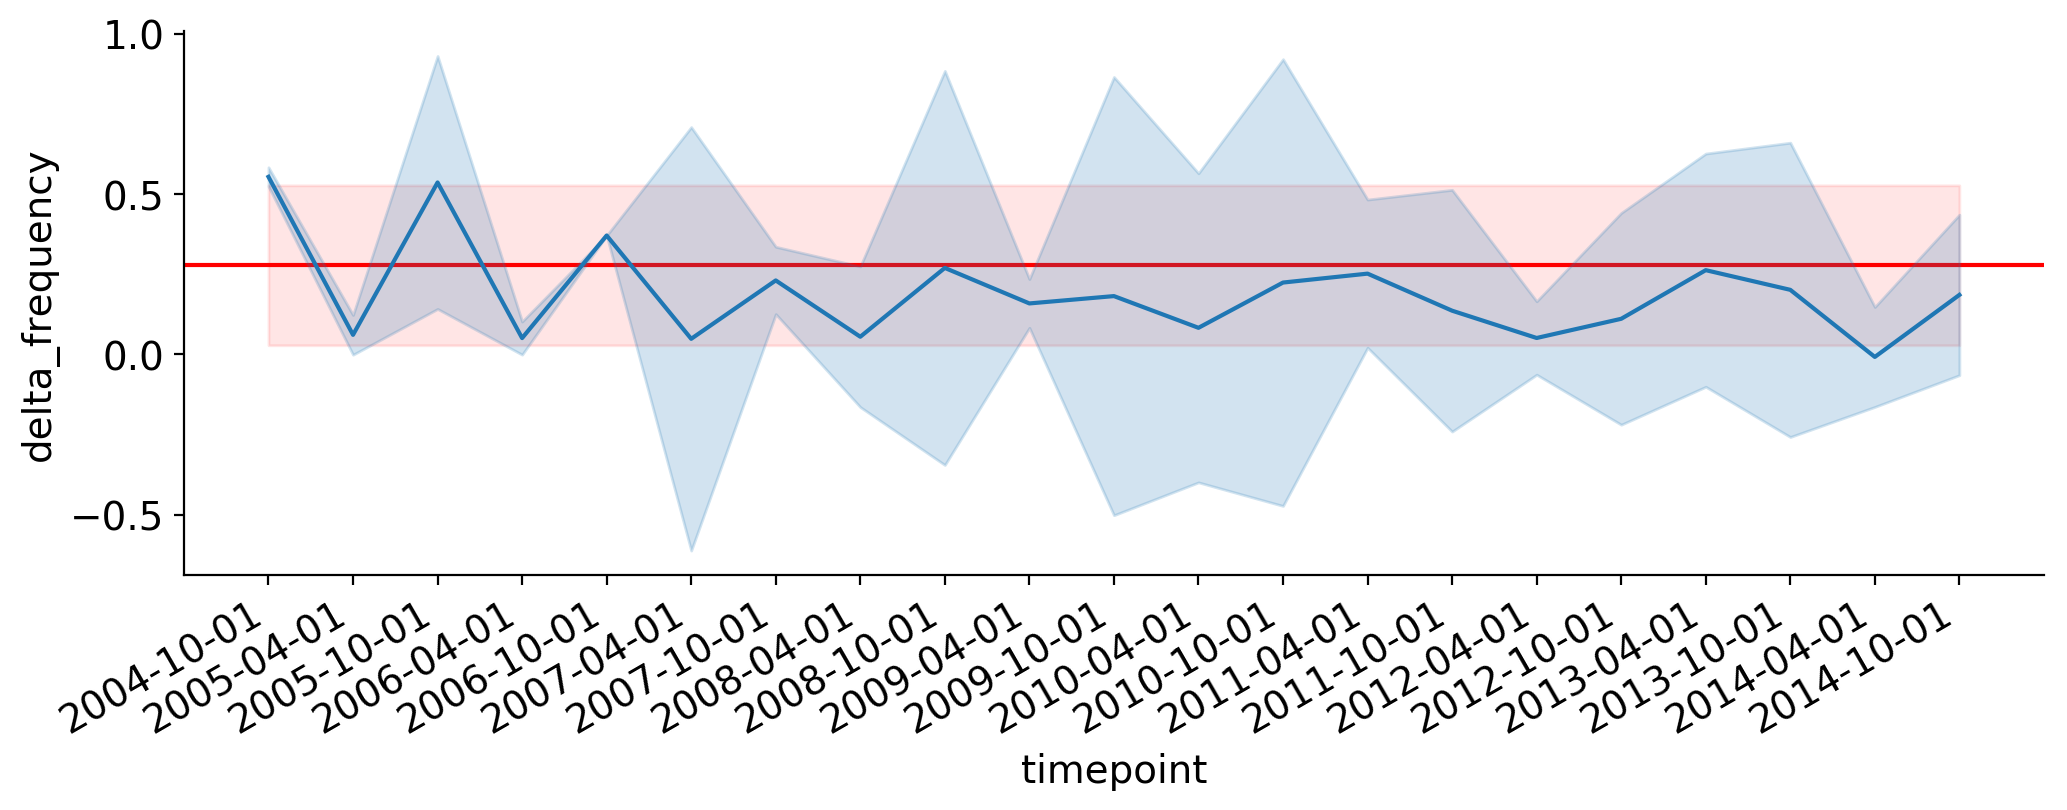

In [327]:
predictor = "delta_frequency"
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.lineplot(
    x="timepoint",
    y=predictor,
    data=raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"],
    ci="sd",
    ax=ax
)
plt.gcf().autofmt_xdate()
#ax.set_ylim(bottom=0)

# Draw the standardization mean and standard deviation for comparison.
mean = standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0]
std = np.sqrt(standardization_stats[standardization_stats["predictor"] == predictor]["var"].values[0])

ax.axhline(y=standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0], color="red", zorder=-10)
ax.fill_between(
    raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"]["timepoint"].values,
    mean - std,
    mean + std,
    color="red",
    alpha=0.1,
    zorder=-10
)

## Summarize standardized predictor distributions
[back to top](#Summarize-models)

In [328]:
tip_attributes_df.shape

(727, 34)

In [329]:
tip_attributes_df["ep_x"].head()

0    1.957755
1    0.689646
2    0.689646
3   -0.298443
4   -0.298443
Name: ep_x, dtype: float64

In [330]:
tip_attributes_df["ep_x"].dropna().shape

(727,)

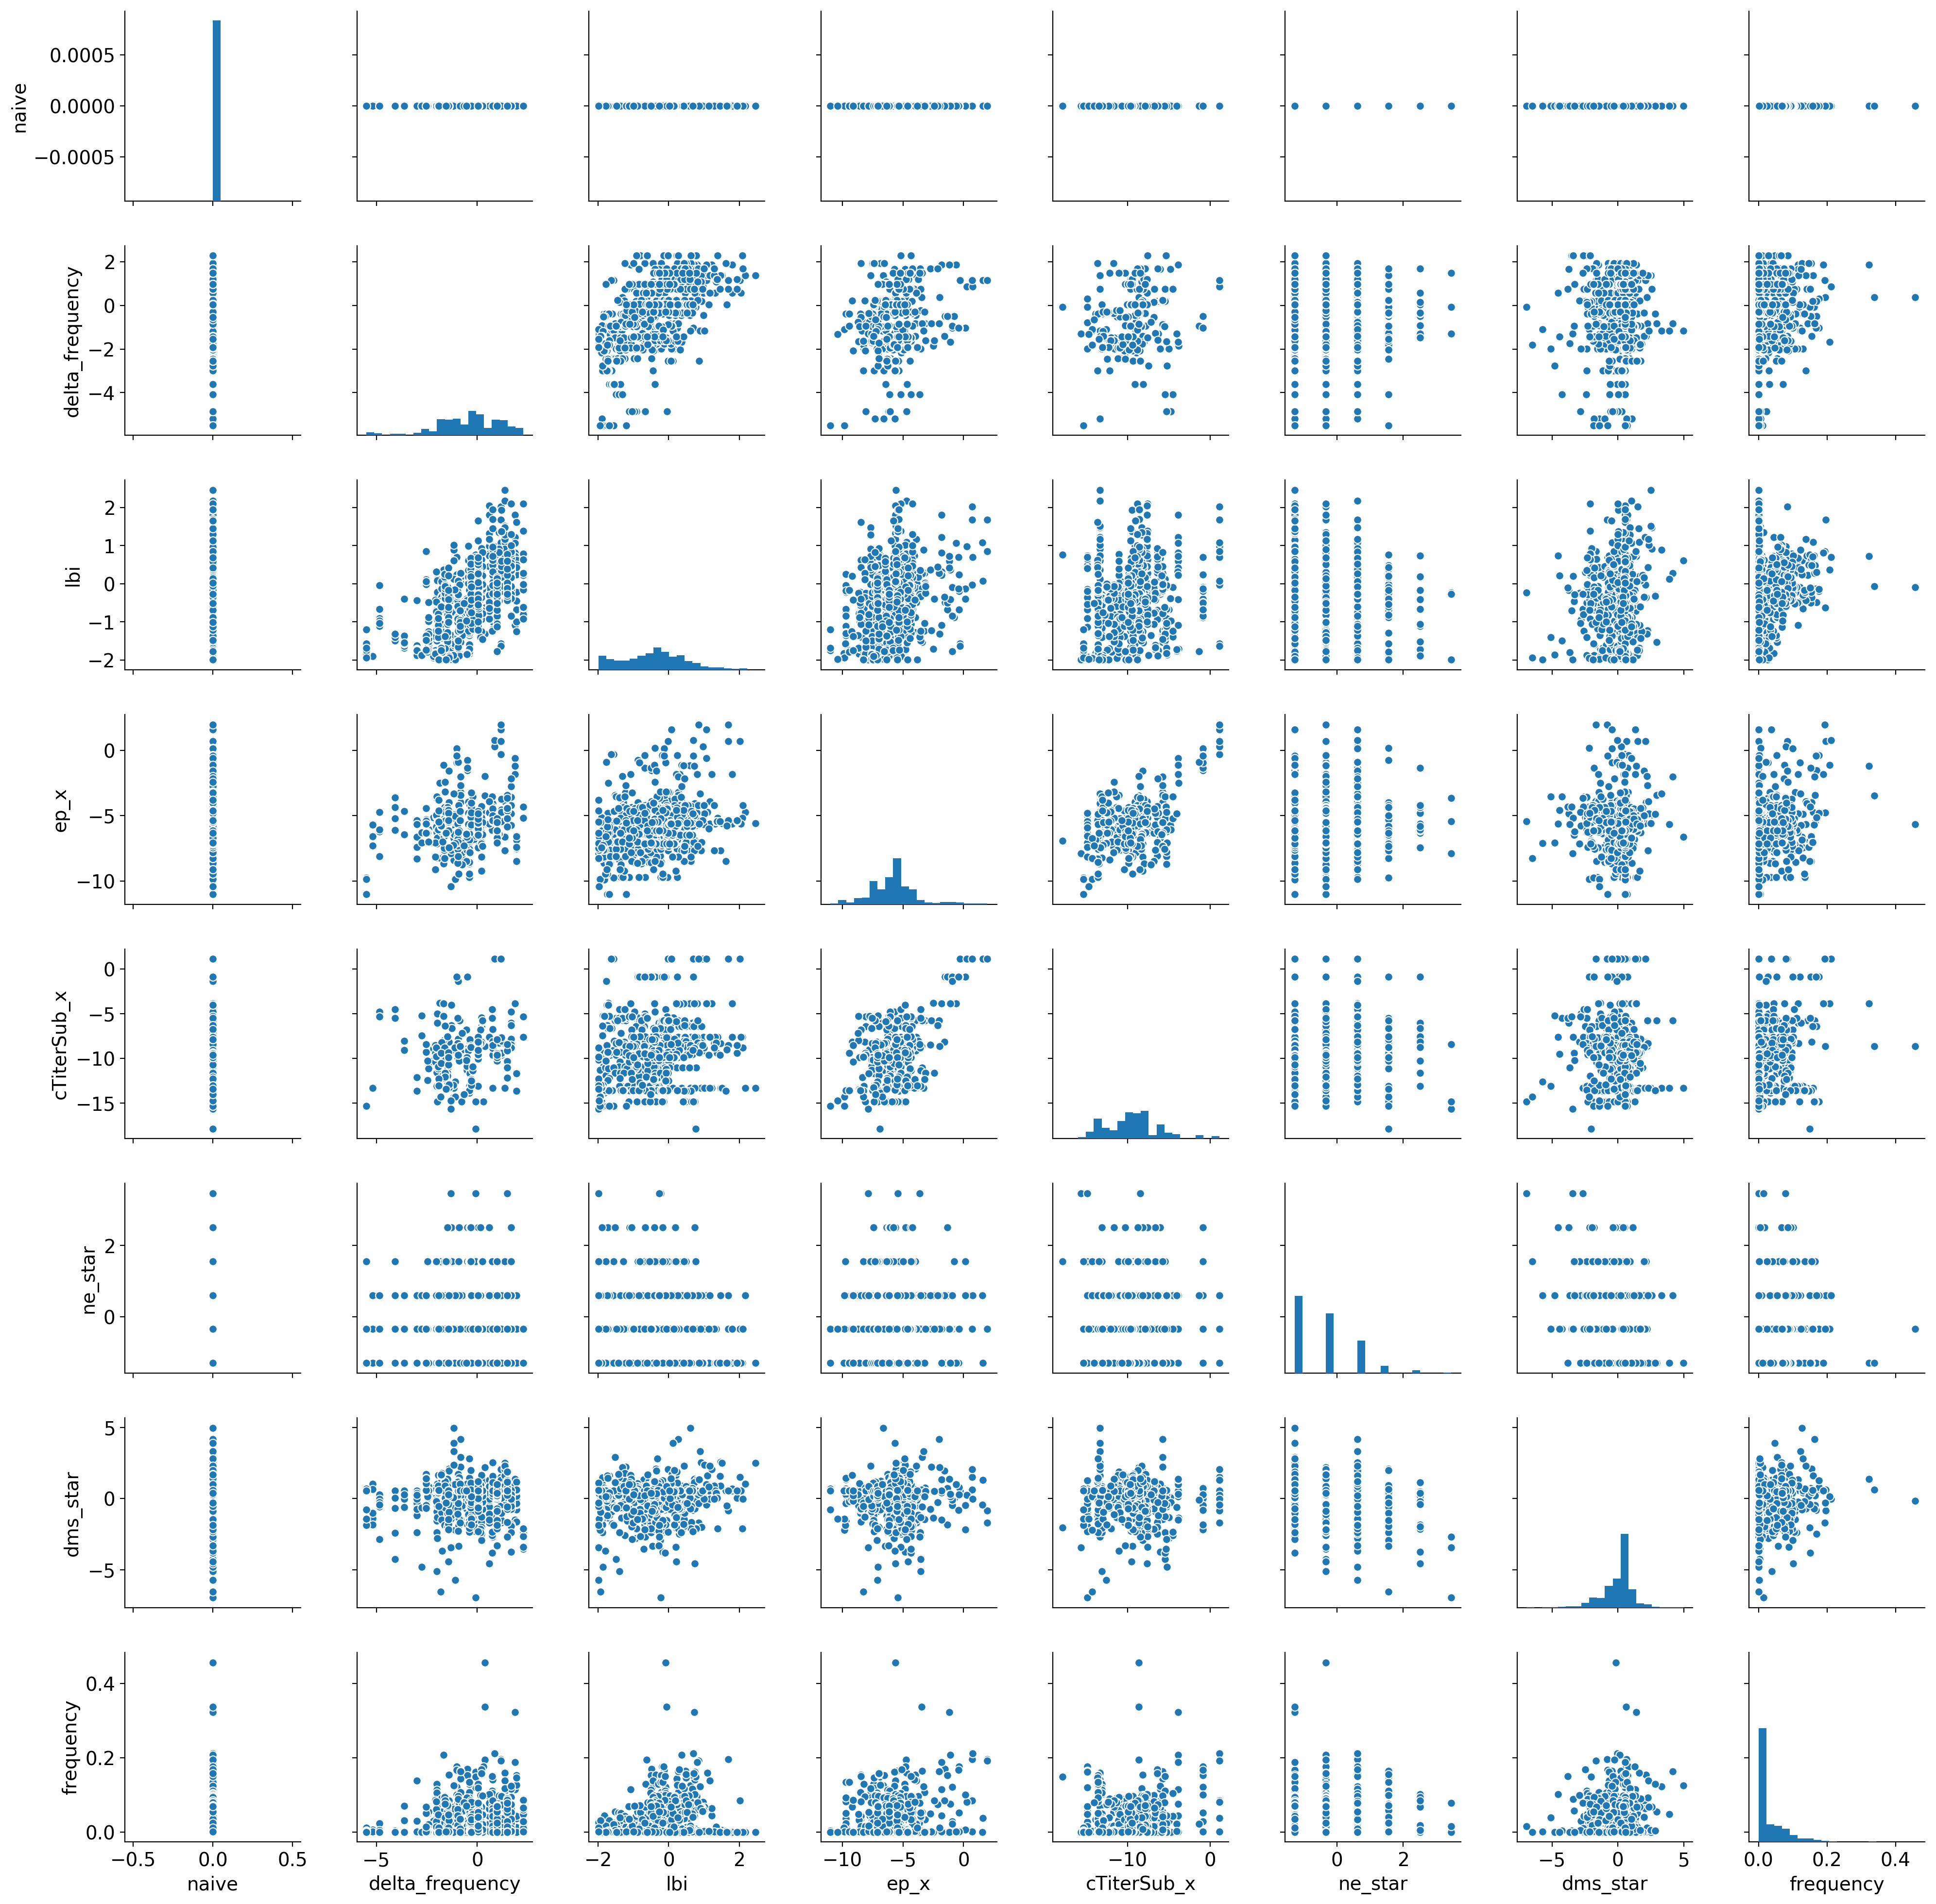

In [331]:
variables_to_plot = [predictor for predictor in predictor_names_order if not "-" in predictor] + ["frequency"]
sns.pairplot(tip_attributes_df, vars=variables_to_plot, diag_kind="hist", diag_kws={"bins": 20})

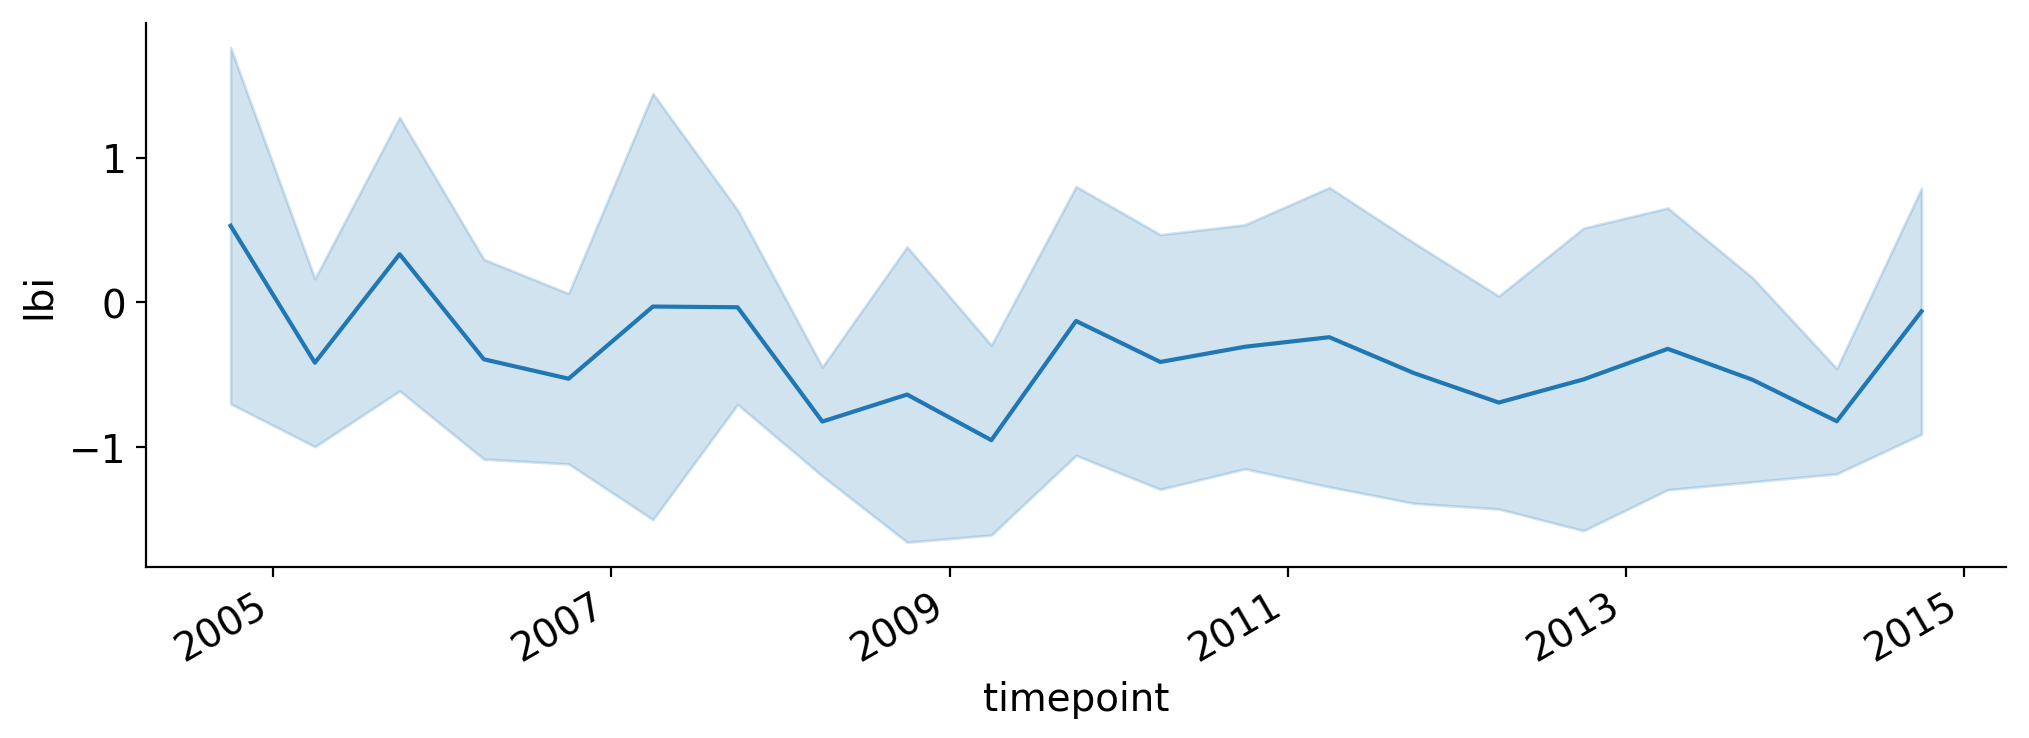

In [332]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.lineplot(
    x="timepoint",
    y="lbi",
    data=tip_attributes_df[tip_attributes_df["timepoint"] < "2015-04-01"],
    ci="sd",
    ax=ax
)
plt.gcf().autofmt_xdate()
#ax.set_ylim(bottom=0)

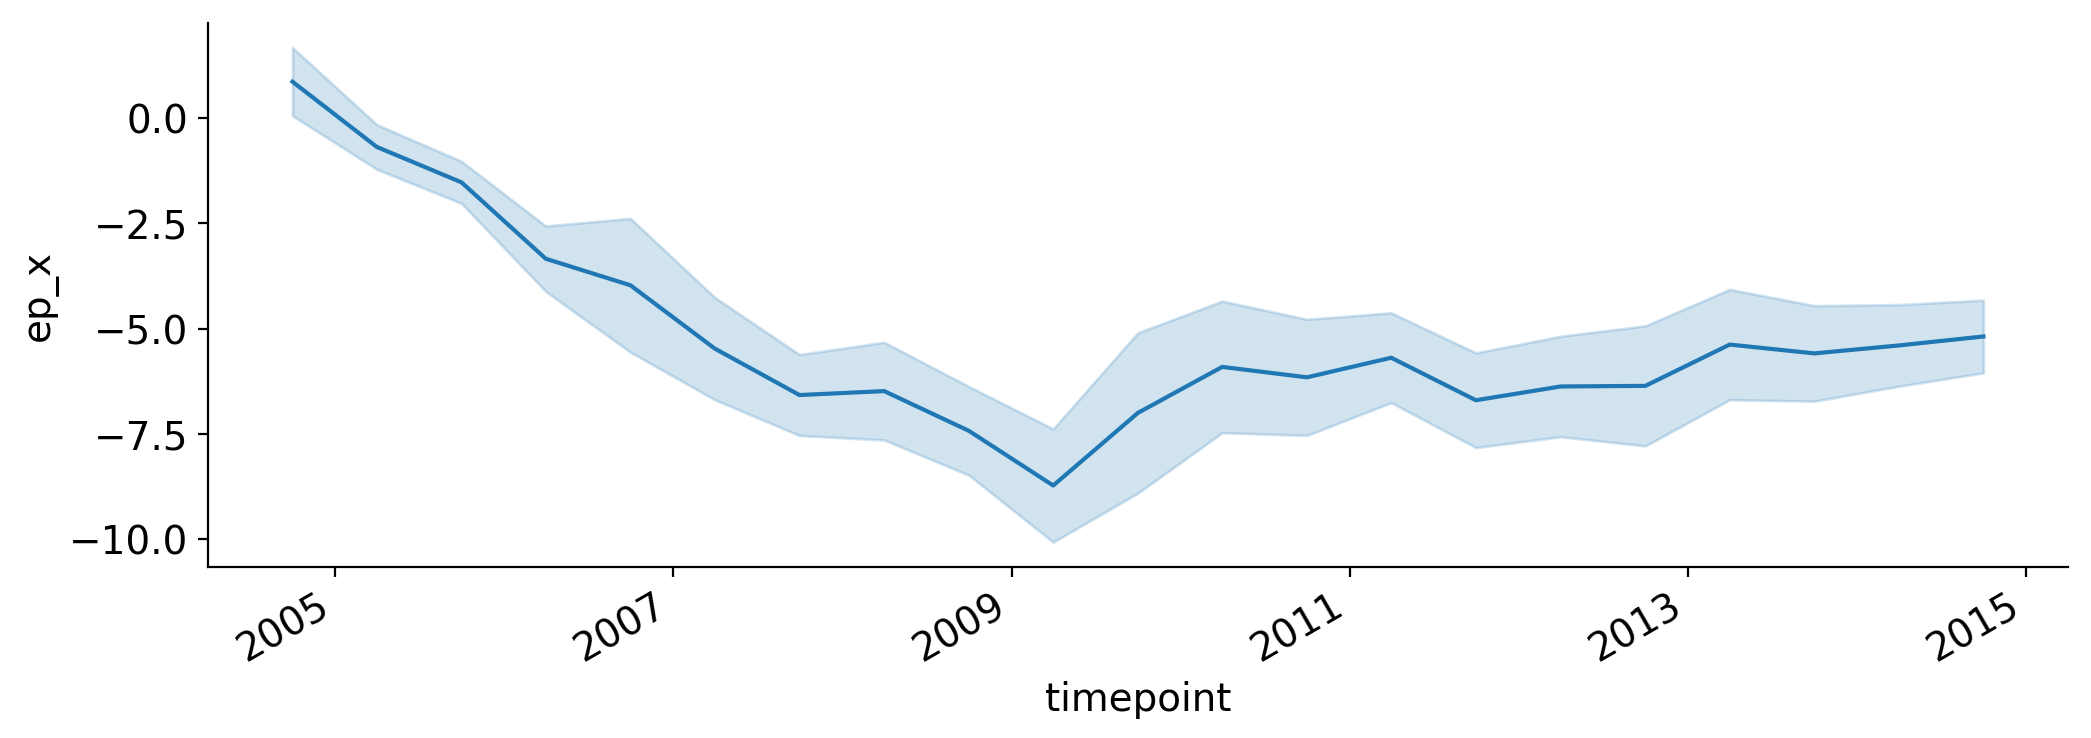

In [218]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.lineplot(
    x="timepoint",
    y="ep_x",
    data=tip_attributes_df[tip_attributes_df["timepoint"] < "2015-04-01"],
    ci="sd",
    ax=ax
)
plt.gcf().autofmt_xdate()
#ax.set_ylim(bottom=0)

In [219]:
tip_attributes_df.loc[pd.isnull(tip_attributes_df["ep_x"]), ["strain", "timepoint", "frequency"]]

Empty DataFrame
Columns: [strain, timepoint, frequency]
Index: []

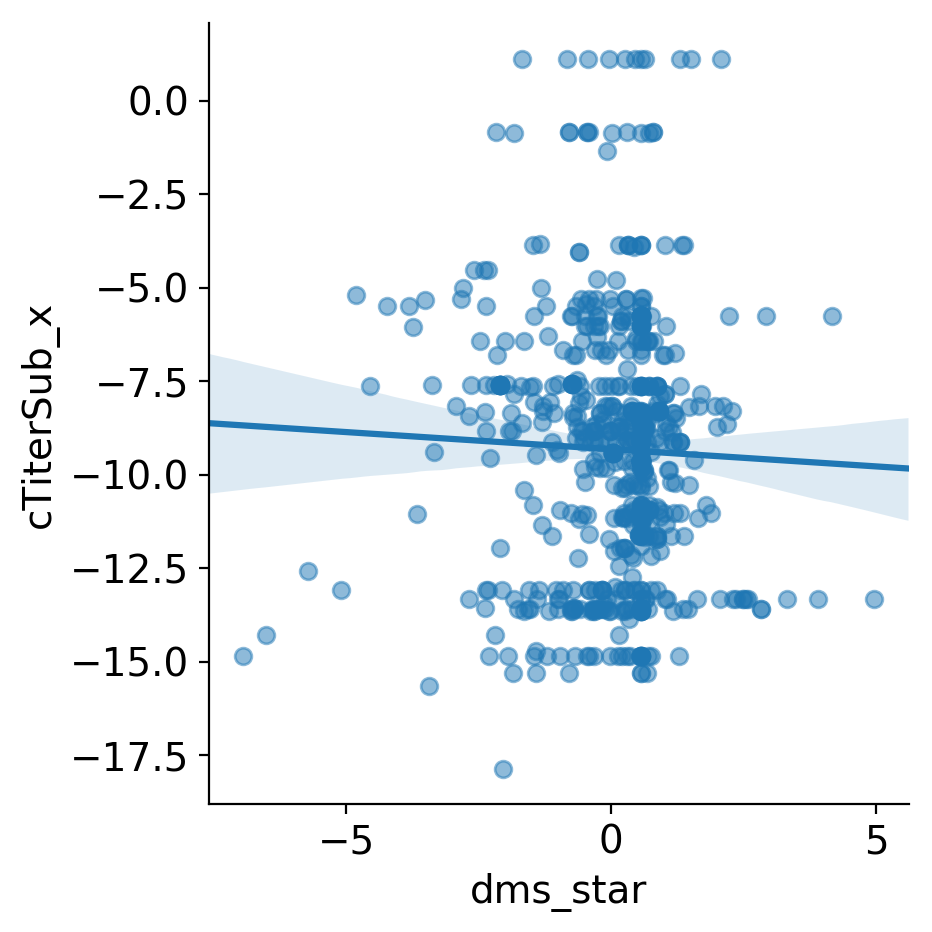

In [220]:
sns.lmplot("dms_star", "cTiterSub_x", tip_attributes_df, scatter_kws={"alpha": 0.5})

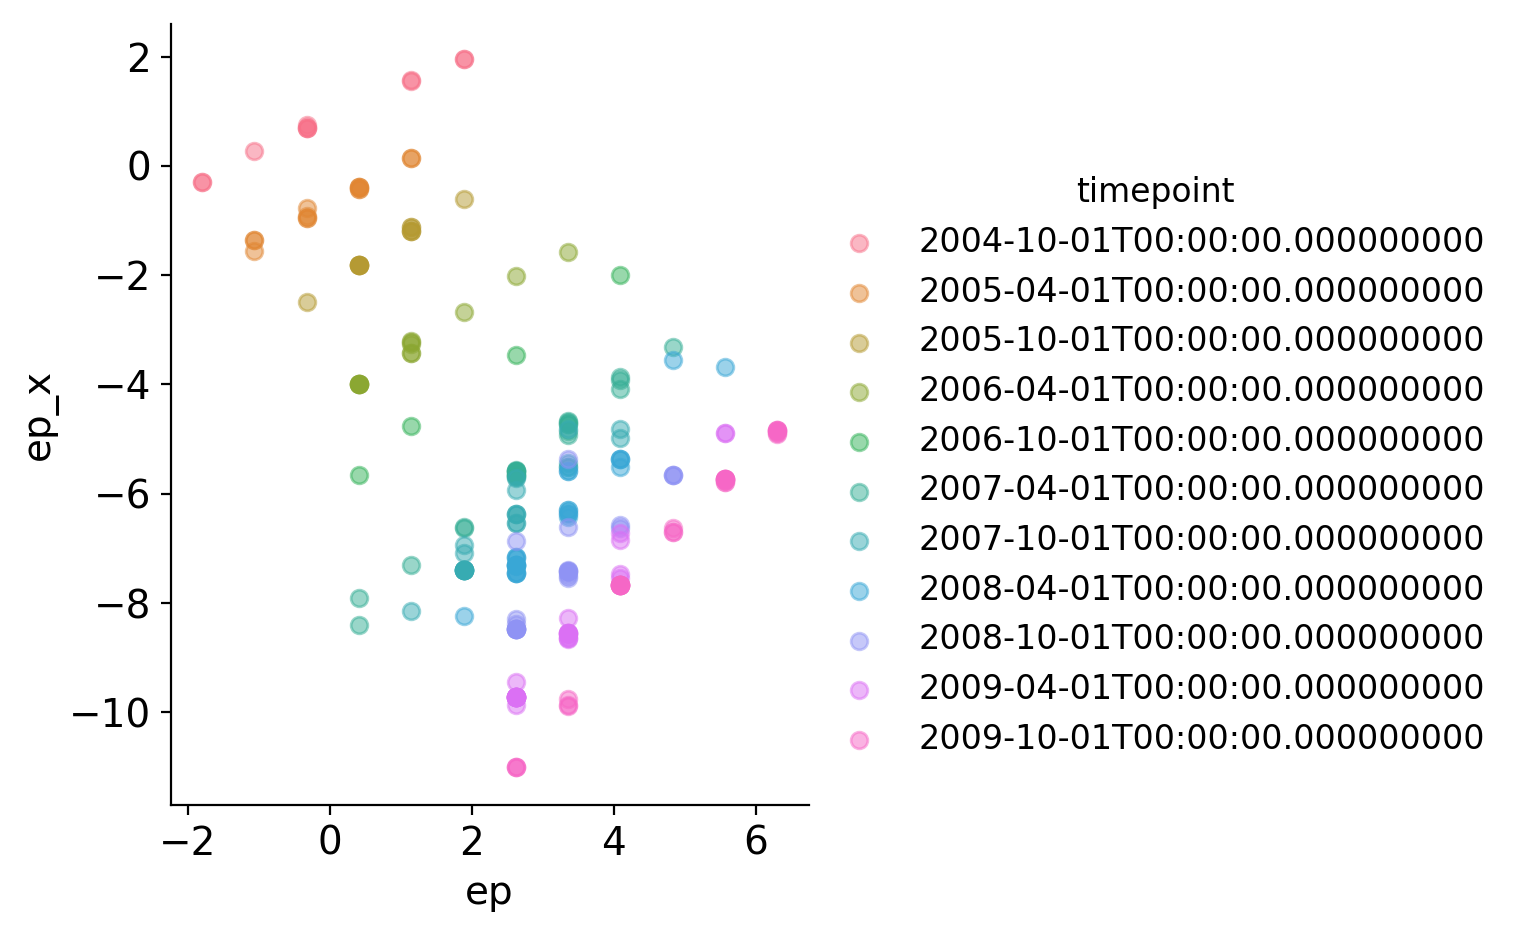

In [221]:
sns.lmplot("ep", "ep_x", tip_attributes_df[(tip_attributes_df["ep"] < 50) & (tip_attributes_df["timepoint"] < "2010-01-01")], hue="timepoint", scatter_kws={"alpha": 0.5}, fit_reg=False)



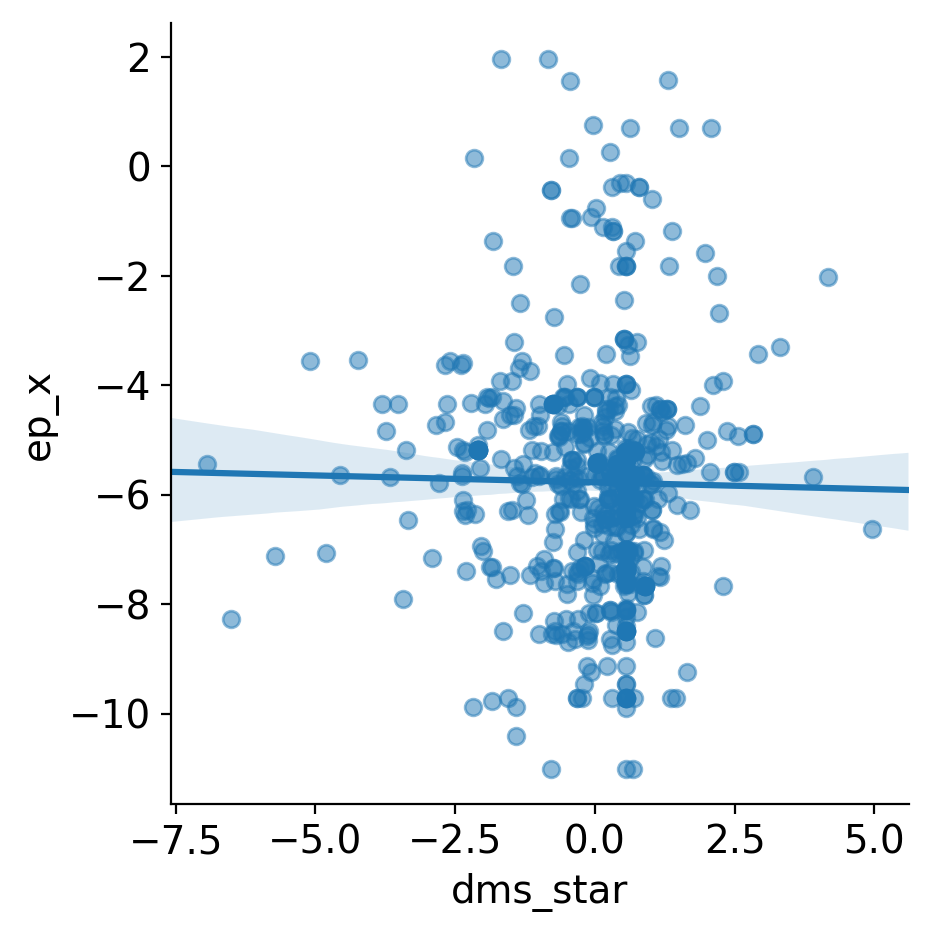

In [222]:
sns.lmplot("dms_star", "ep_x", tip_attributes_df, scatter_kws={"alpha": 0.5})

(-7, 7)

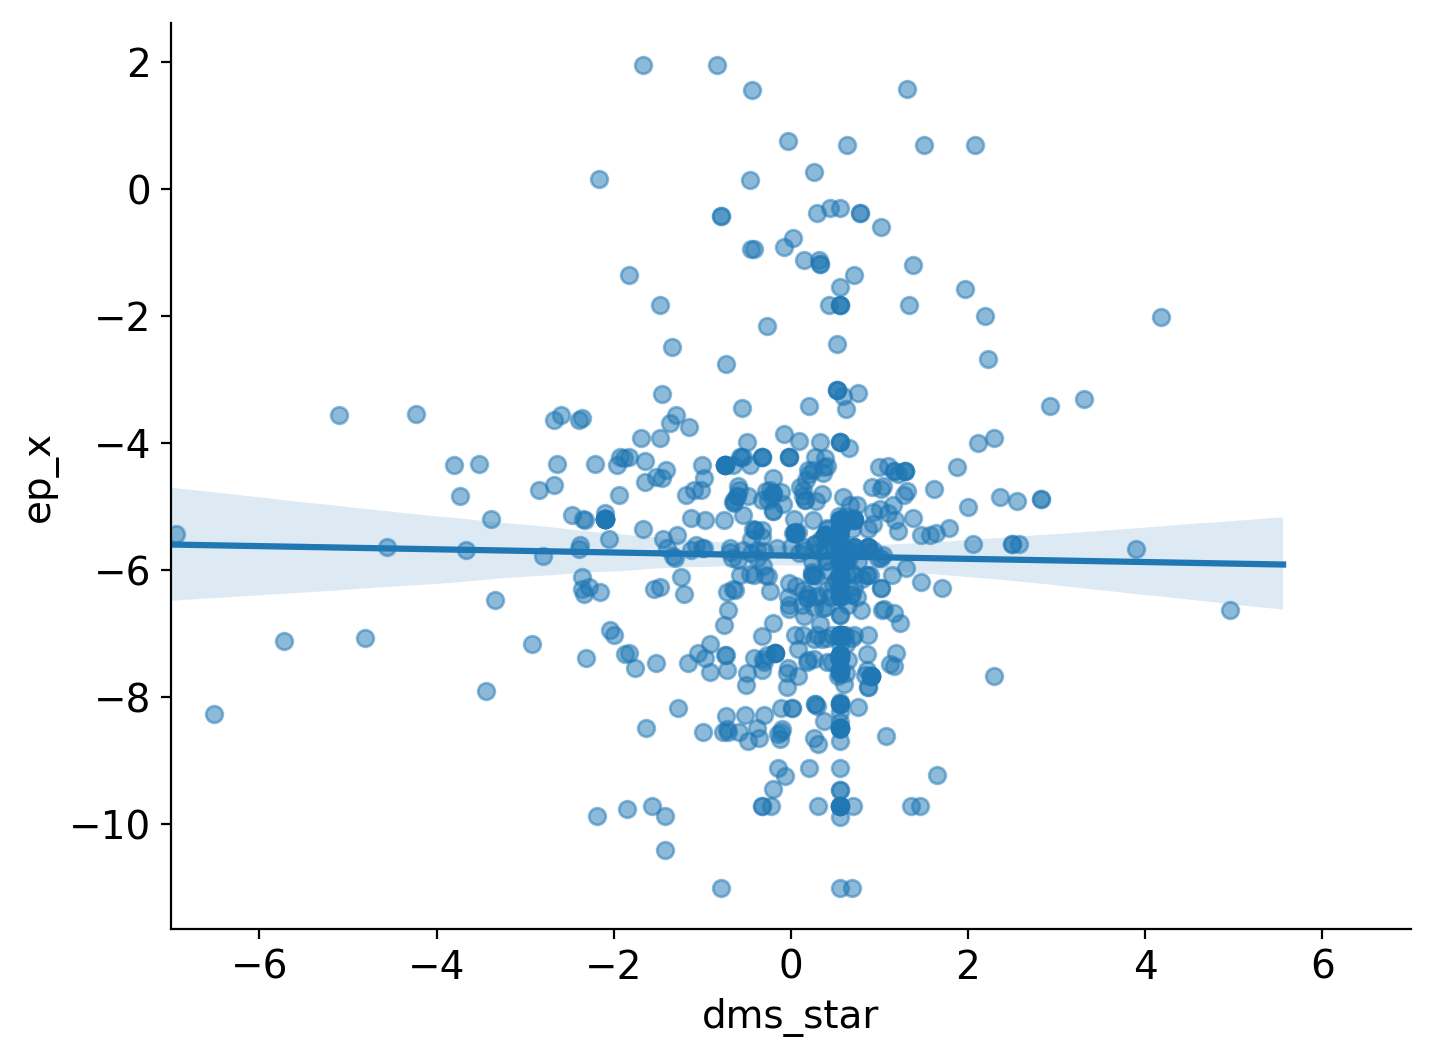

In [223]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.regplot("dms_star", "ep_x", tip_attributes_df, scatter_kws={"alpha": 0.5}, ax=ax)
ax.set_xlim(-7, 7)

In [224]:
tip_attributes_df.loc[tip_attributes_df["dms_star"] < -15, ["timepoint", "strain", "cTiterSub_x", "ep_x", "dms_star", "frequency", "raw_date"]].head()

Empty DataFrame
Columns: [timepoint, strain, cTiterSub_x, ep_x, dms_star, frequency, raw_date]
Index: []

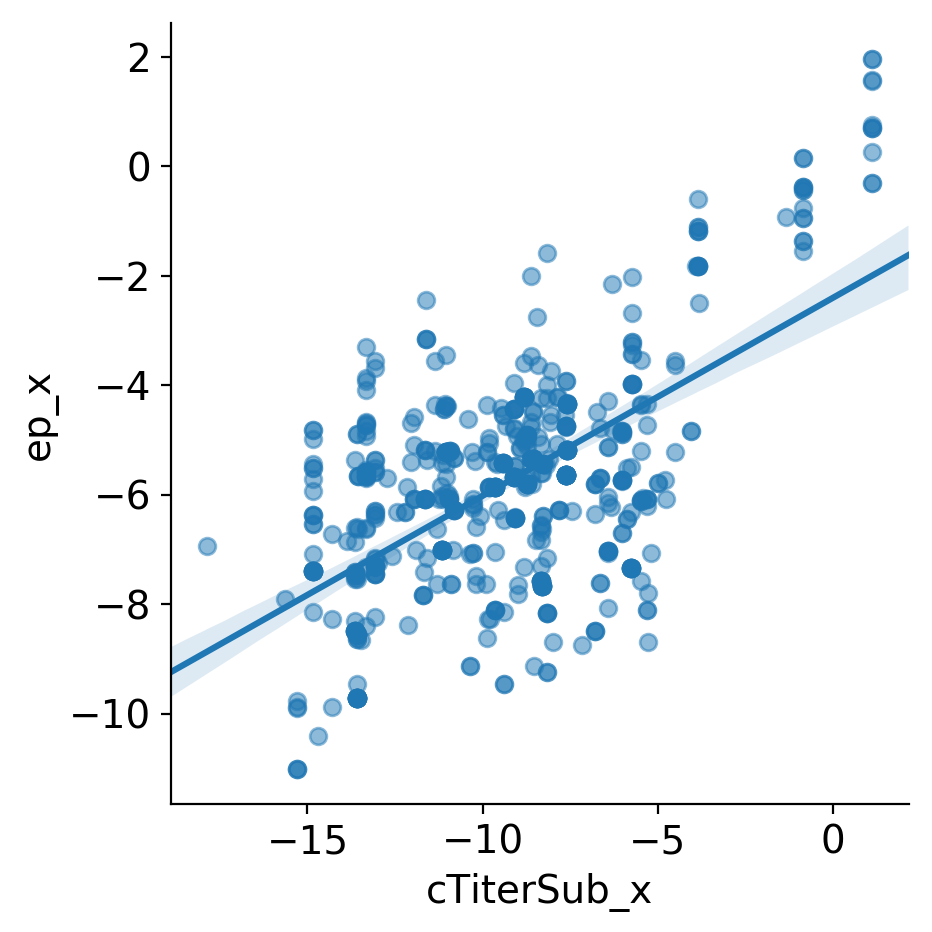

In [225]:
sns.lmplot("cTiterSub_x", "ep_x", tip_attributes_df, scatter_kws={"alpha": 0.5})

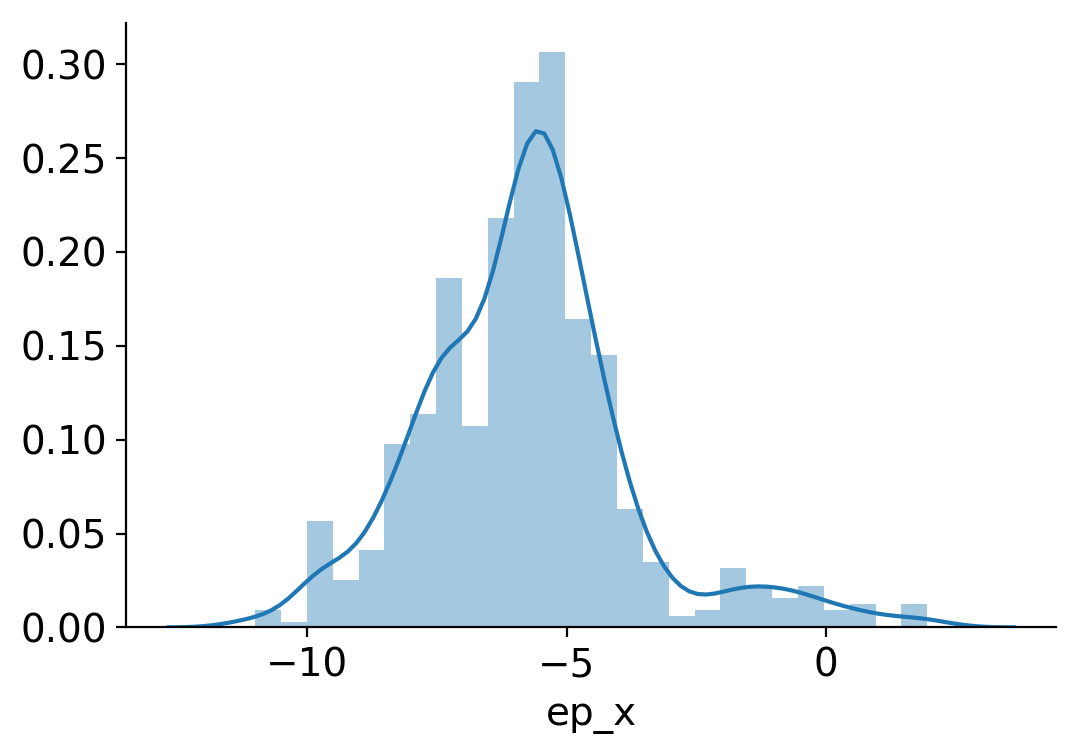

In [226]:
sns.distplot(tip_attributes_df["ep_x"])

In [227]:
tip_attributes_df["ep_x"].mean()

-5.772512926714456

In [228]:
raw_tip_attributes_df = pd.read_table(data_root + "tip_attributes.tsv")

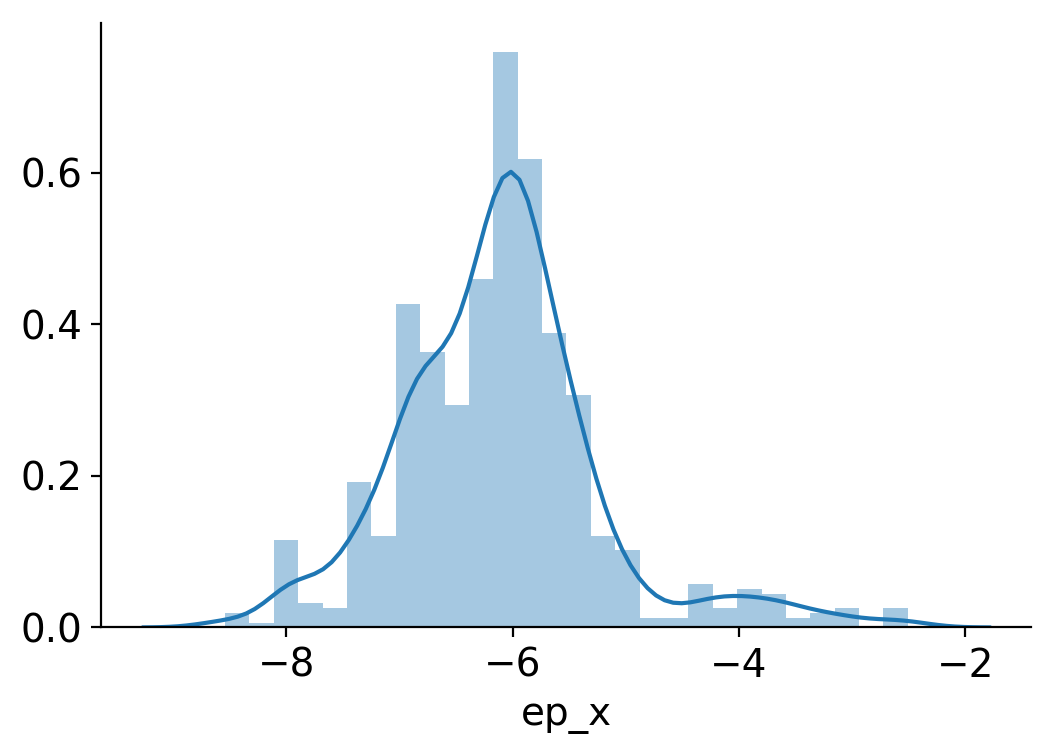

In [229]:
sns.distplot(raw_tip_attributes_df["ep_x"].dropna())

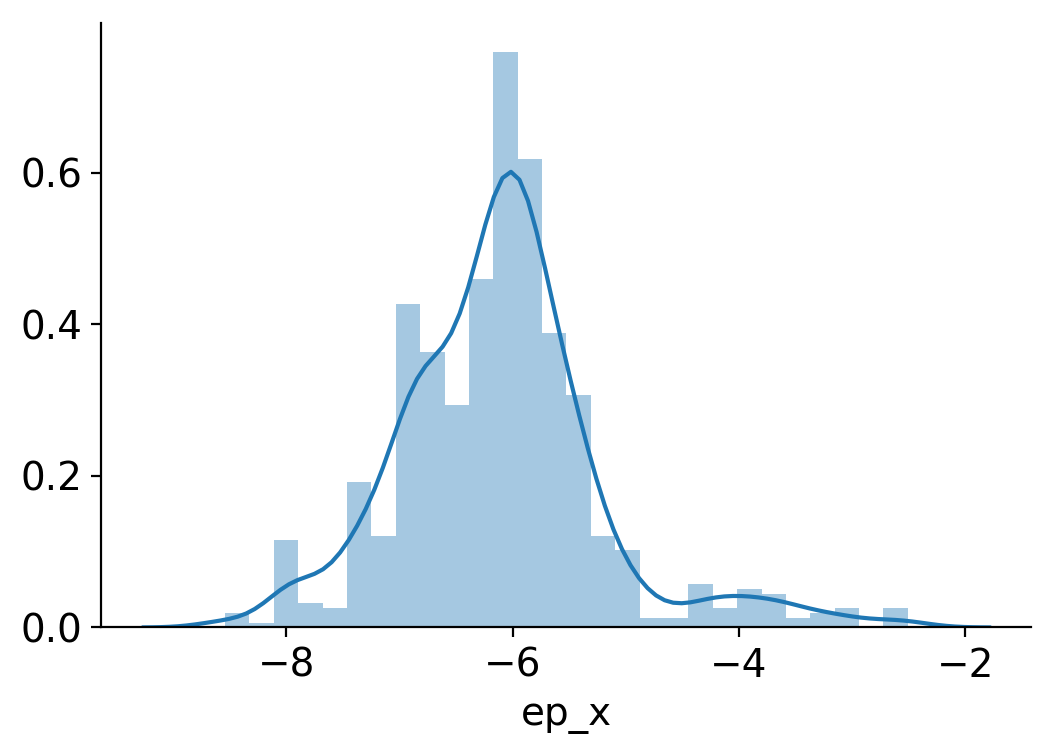

In [230]:
sns.distplot(raw_tip_attributes_df["ep_x"].fillna(0.0))

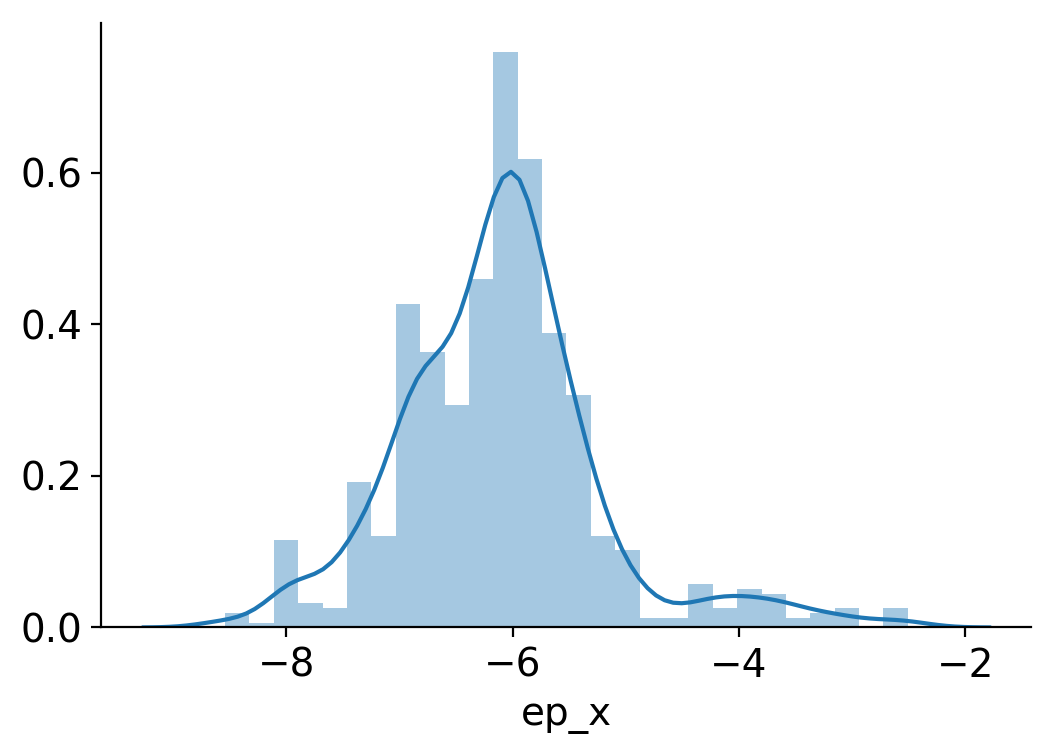

In [231]:
sns.distplot(raw_tip_attributes_df["ep_x"].fillna(raw_tip_attributes_df["ep_x"].dropna().mean()))

In [232]:
raw_tip_attributes_df["ep_x"].dropna().mean()

-6.114804726963272

In [233]:
raw_tip_attributes_df["ep_x"].dropna().std()

0.896238433387147

In [234]:
raw_tip_attributes_df["ep_x"].fillna(0.0).mean()

-6.114804726963272

In [235]:
raw_tip_attributes_df["ep_x"].fillna(0.0).std()

0.896238433387147

## Summarize model residuals
[back to top](#Summarize-models)

In [236]:
residuals_by_timepoint = residual_df.groupby(["predictors", "timepoint"])["residual"].sum().reset_index()

In [237]:
residuals_by_timepoint.head()

predictors  timepoint   residual
0  cTiterSub 2004-10-01   2.149777
1  cTiterSub 2005-04-01   5.166241
2  cTiterSub 2005-10-01   4.085026
3  cTiterSub 2006-04-01  18.347067
4  cTiterSub 2006-10-01  23.895242

In [238]:
residuals_by_timepoint.groupby("predictors")["residual"].sum()

predictors
cTiterSub          169.067680
cTiterSub_x        145.028406
delta_frequency    189.087853
dms_star           156.401581
ep                 190.587679
ep_x               190.895306
lbi                227.915069
naive              163.739086
ne_star            205.154898
Name: residual, dtype: float64

In [239]:
model_name = "lbi"

In [240]:
model_residuals_by_timepoint = residuals_by_timepoint[residuals_by_timepoint["predictors"] == model_name]

In [241]:
max_lags = 18

Text(0,0.5,'Number of clades')

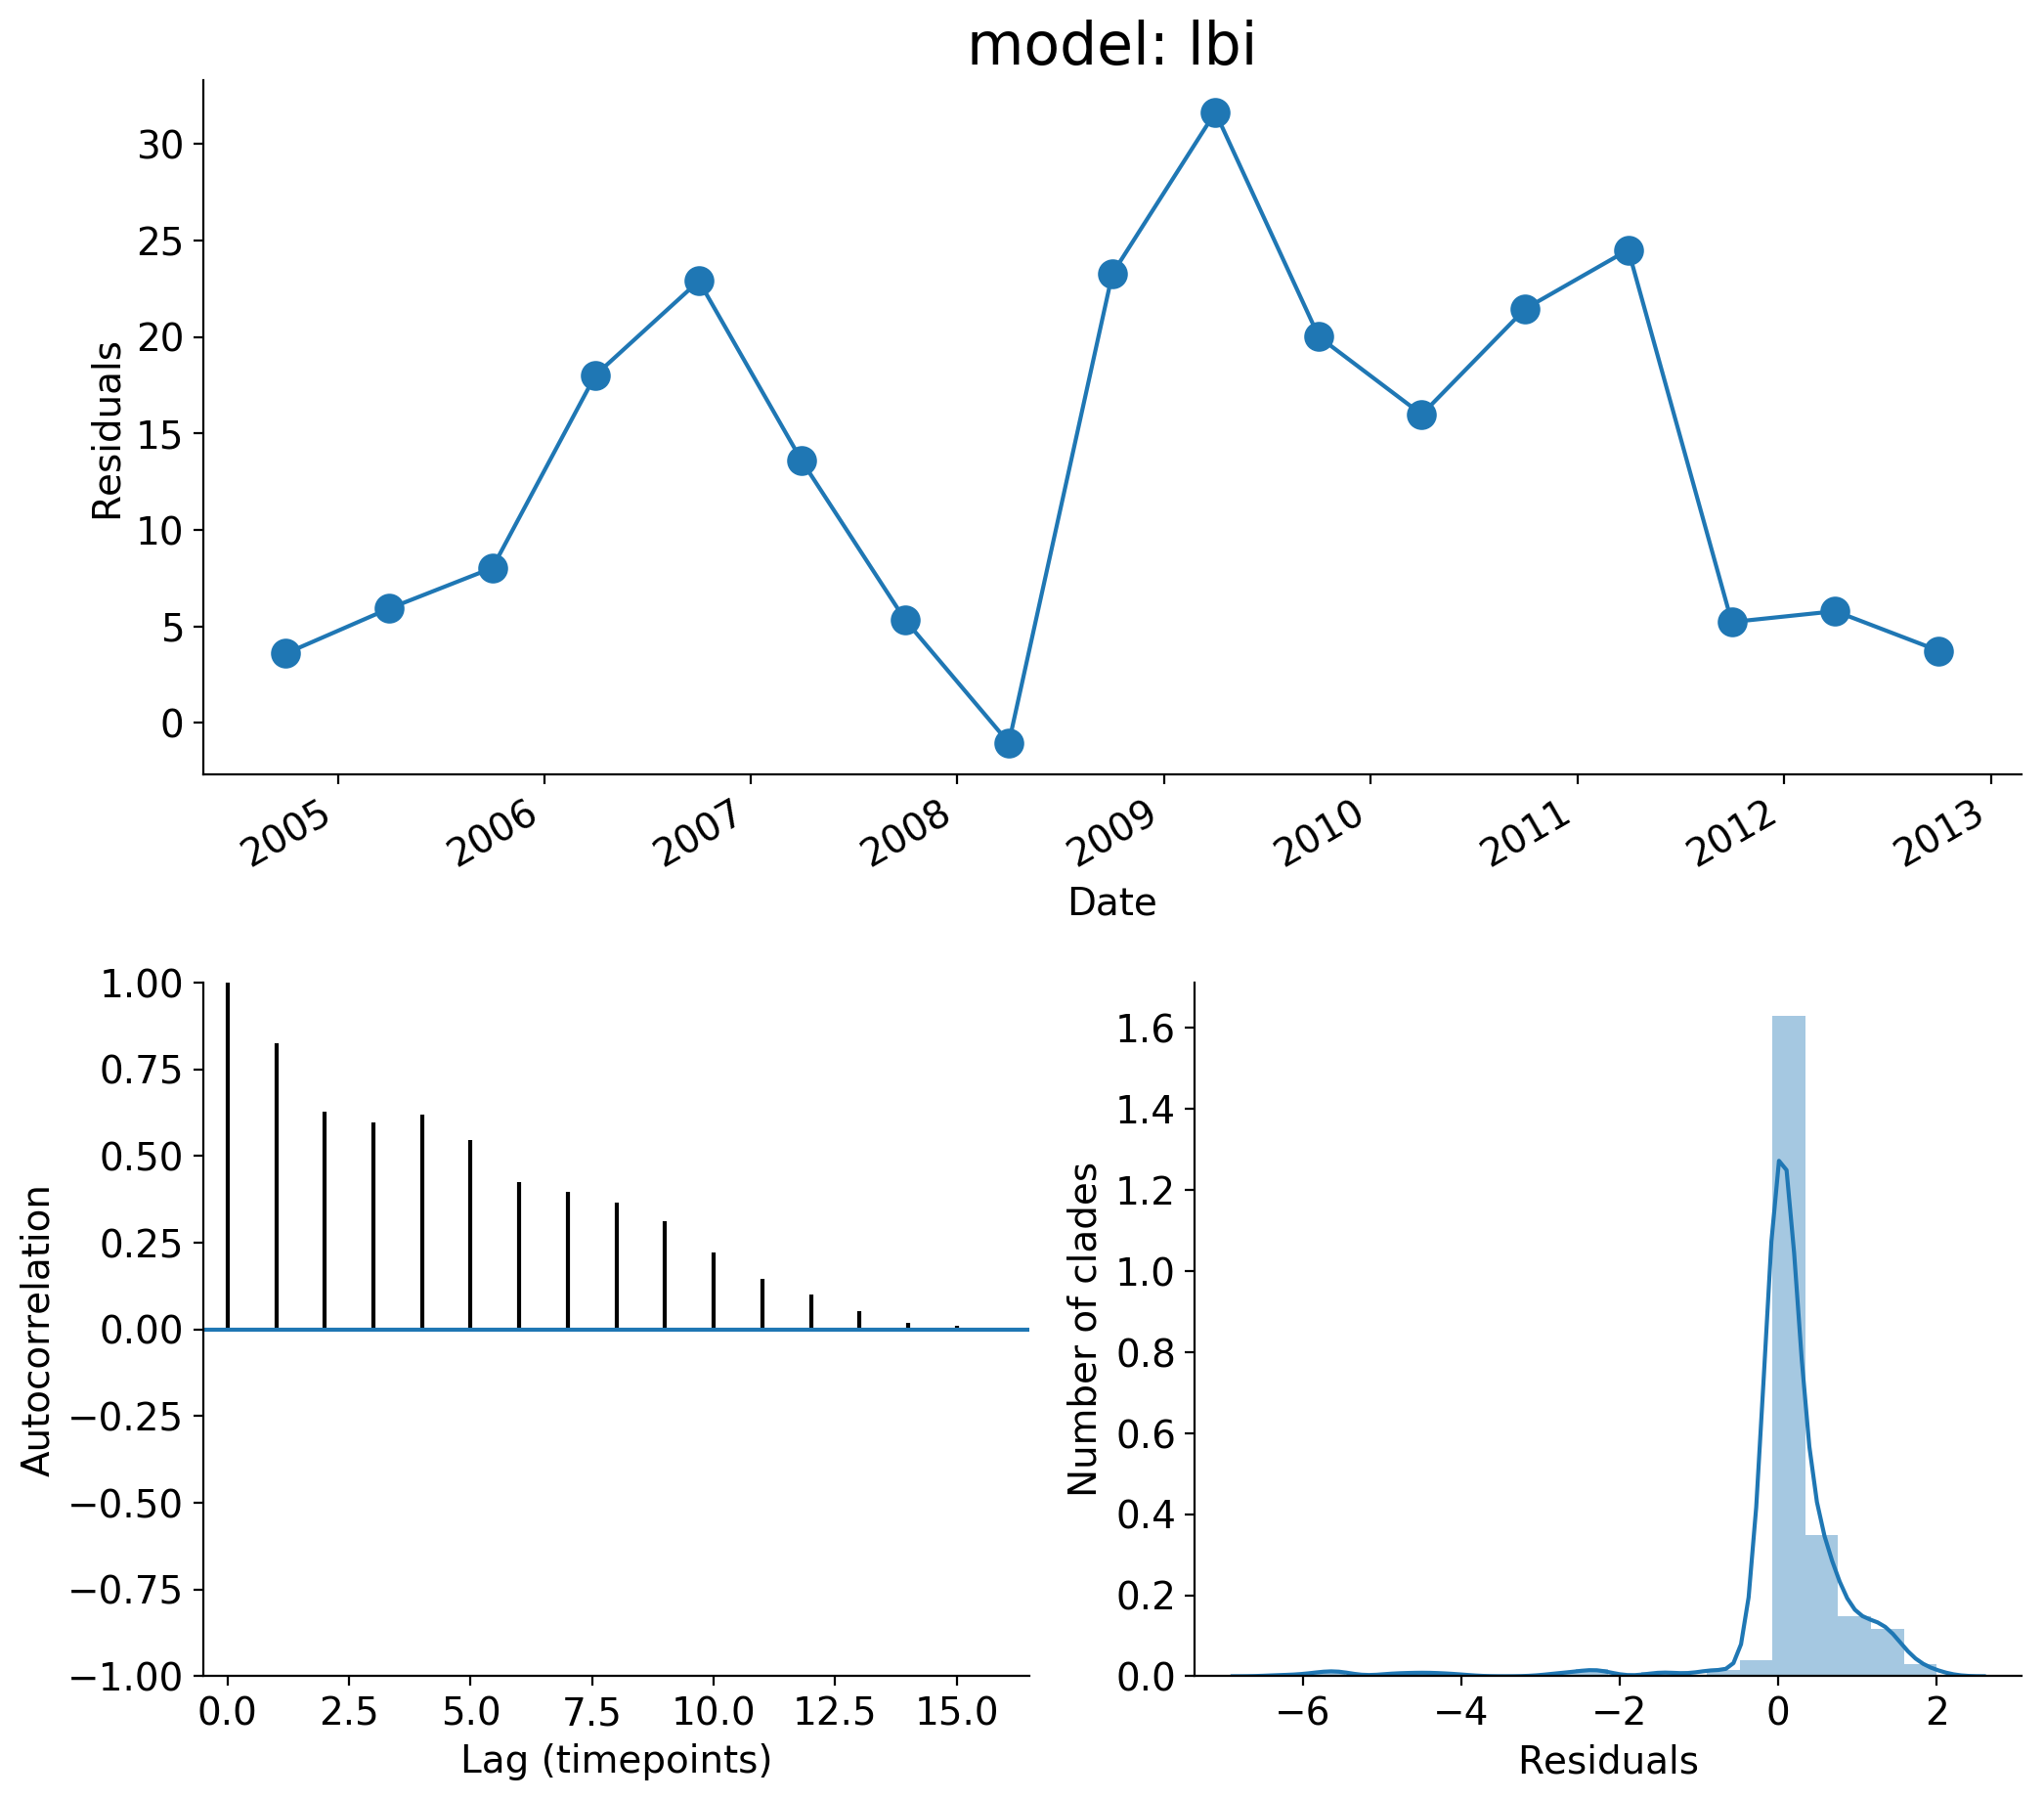

In [242]:
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(2, 2)
gs.update(hspace=0.3)

ax1 = plt.subplot(gs[0, :])
ax1.plot(model_residuals_by_timepoint["timepoint"], model_residuals_by_timepoint["residual"], "o-", markersize=10)
ax1.set_xlabel("Date")
ax1.set_ylabel("Residuals")
ax1.set_title("model: %s" % model_name)
plt.gcf().autofmt_xdate()

ax2 = plt.subplot(gs[1, :-1])
max_lags = len(model_residuals_by_timepoint["residual"]) - 1
lags, autocorrelation, lines, horizonal_lines = ax2.acorr(
    model_residuals_by_timepoint["residual"],
    maxlags=max_lags
)
ax2.set_xlabel("Lag (timepoints)")
ax2.set_ylabel("Autocorrelation")
ax2.set_xlim(-0.5, max_lags + 0.5)
ax2.set_ylim(-1, 1)

ax3 = plt.subplot(gs[1:, -1])
sns.distplot(residual_df.loc[residual_df["predictors"] == model_name, "residual"], ax=ax3, bins=20)
ax3.set_xlabel("Residuals")
ax3.set_ylabel("Number of clades")

In [243]:
residual_df.head()

strain  timepoint         y     frequency  \
0        A/California/7/2004 2004-10-01  1.248581  5.249956e-06   
1      A/Canterbury/201/2004 2004-10-01  0.912550  1.481999e-02   
2       A/Canterbury/23/2004 2004-10-01  0.307861  6.830979e-01   
3  A/HongKong/CUHK33894/2004 2004-10-01  0.000022  8.131382e-08   
4  A/HongKong/CUHK35435/2004 2004-10-01  0.001594  1.235013e-05   

   weighted_distance_to_future  weighted_distance_to_present         y_hat  \
0                     6.375681                      5.069707  2.661574e-05   
1                     4.659788                      3.853049  5.710215e-02   
2                     3.659789                      3.244720  2.216462e+00   
3                     7.374615                      6.195280  5.037619e-07   
4                     6.374616                      5.195287  6.416248e-05   

         y_diff  residual validation_timepoint predictors  
0  3.347204e-05  1.248555           2011-10-01   dms_star  
1  6.905802e-02  0.855447           2011-10-01   dms_star  
2  2.499994e+00 -1.908600           2011-10-01   dms_star  
3  5.996581e-07  0.000022           2011-10-01   dms_star  
4  7.872735e-05  0.001529           2011-10-01   dms_star

### Residuals by predictor

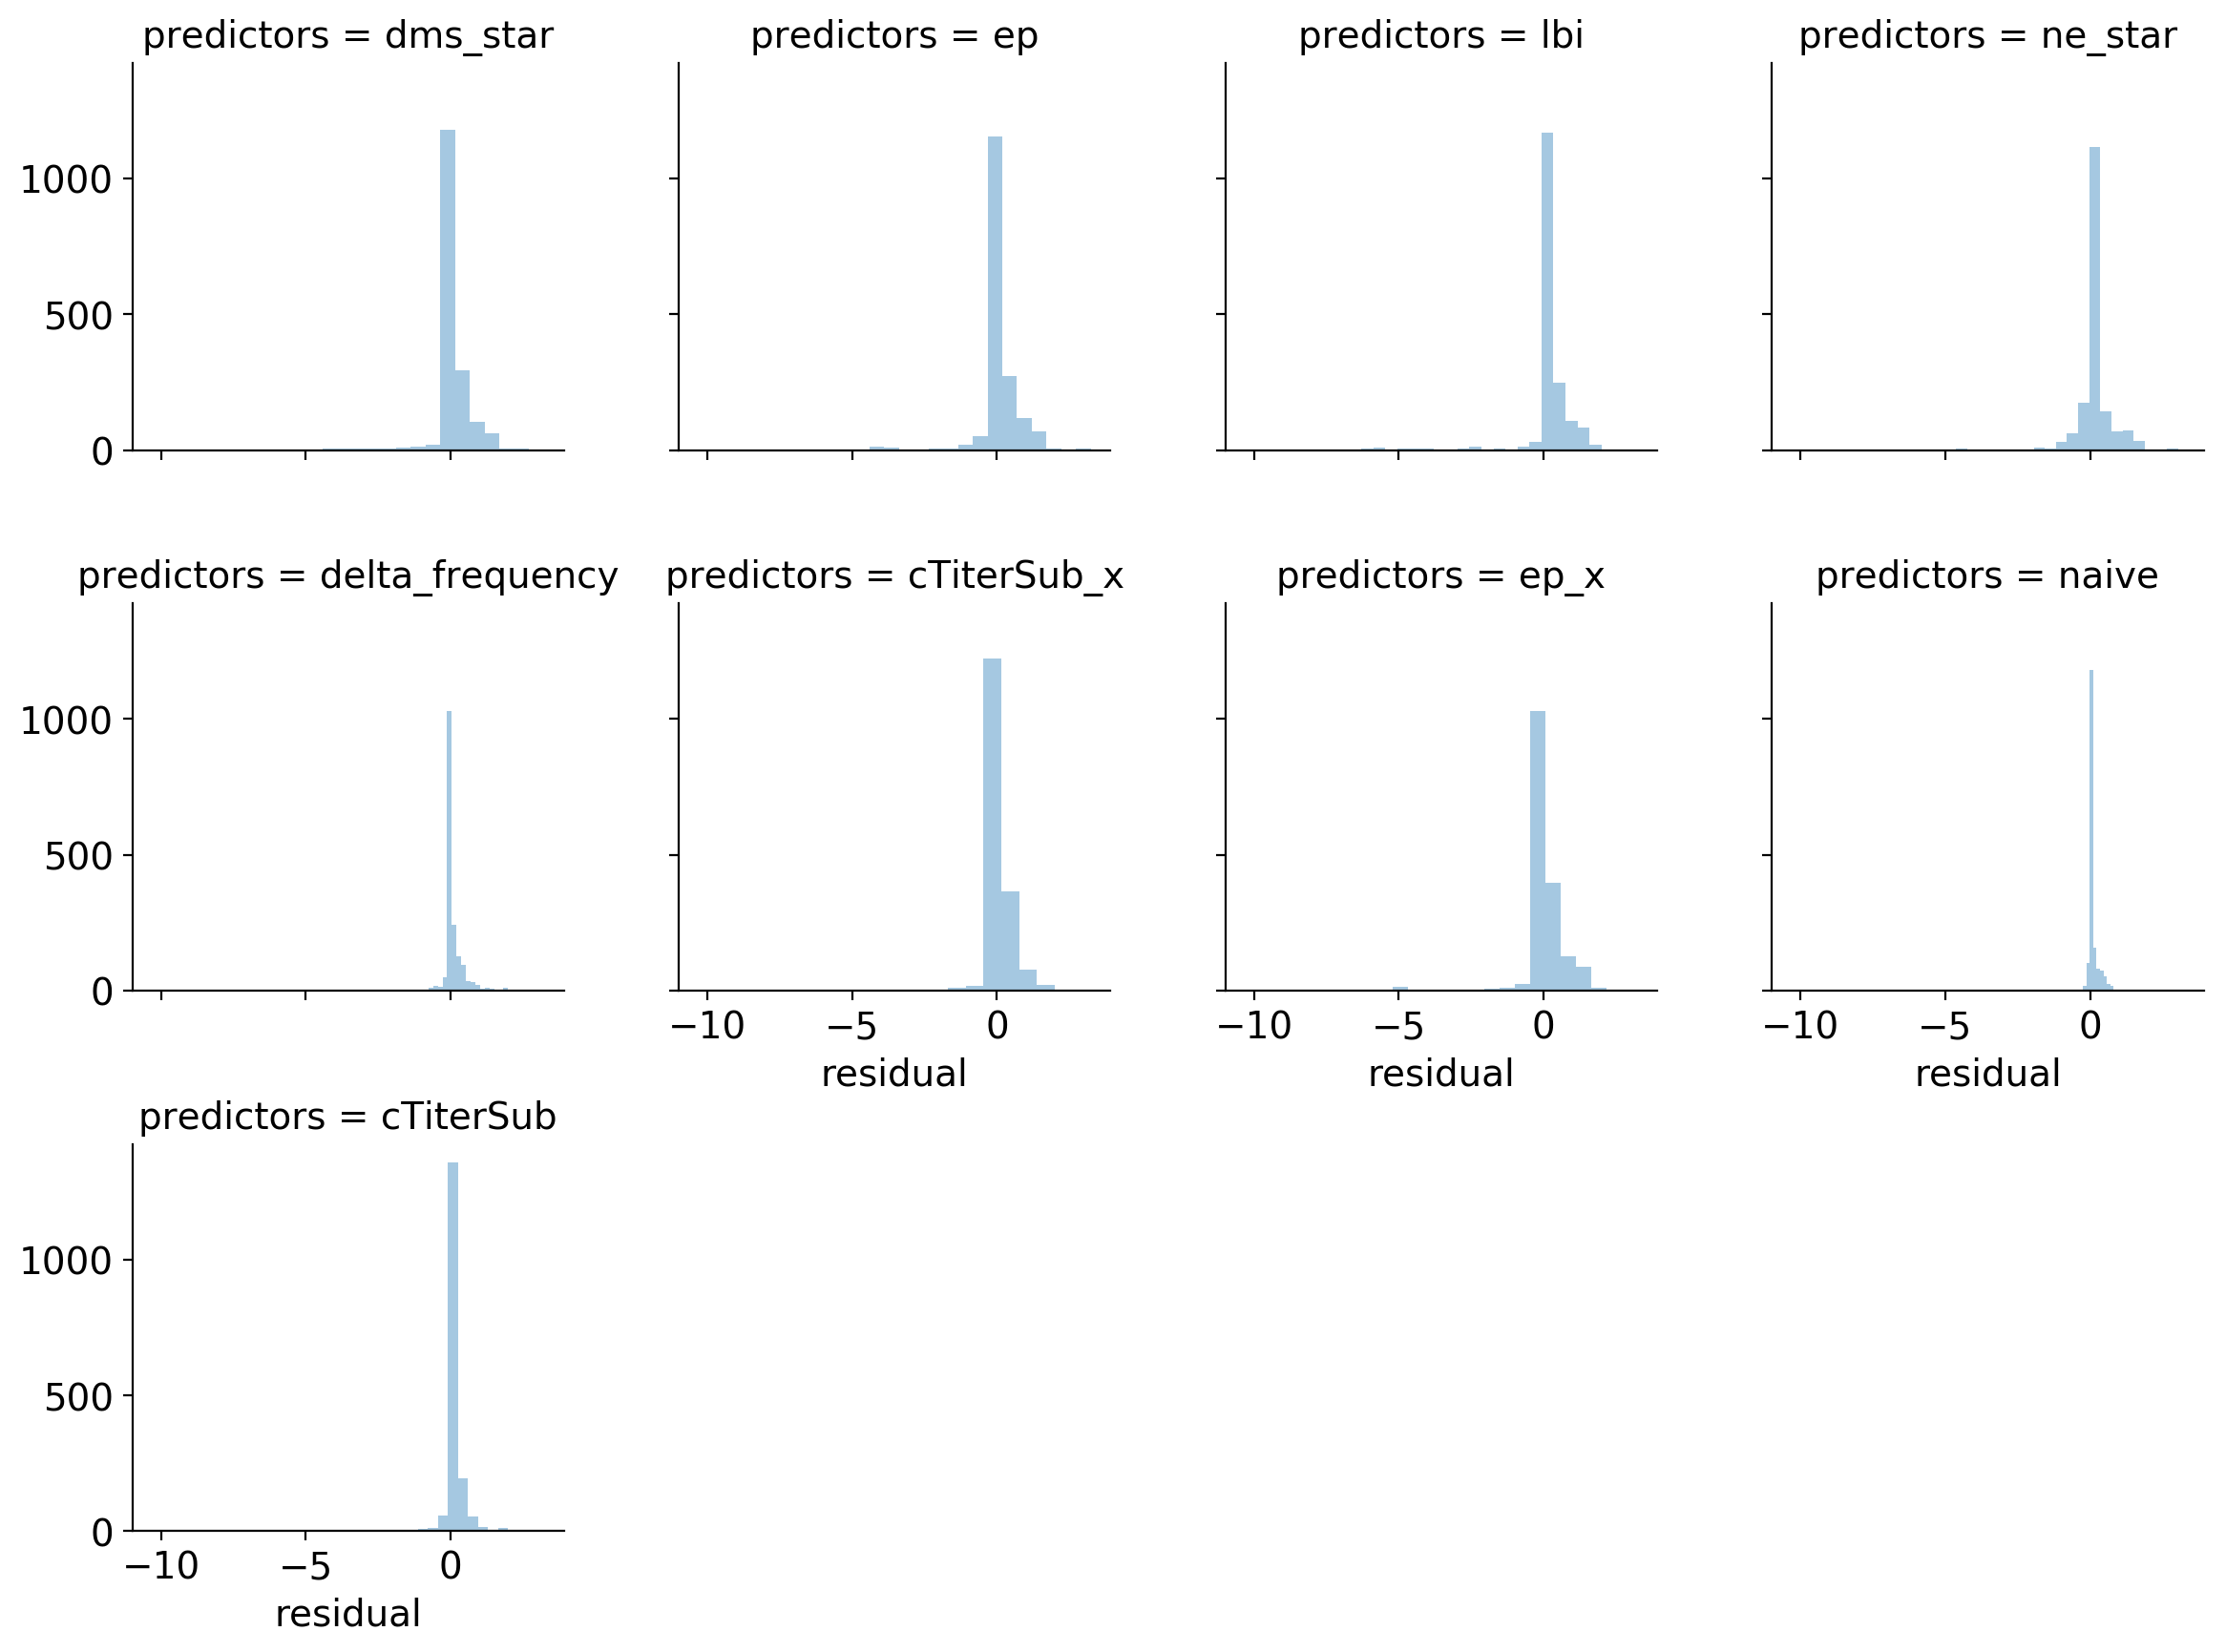

In [244]:
g = sns.FacetGrid(residual_df, col="predictors", col_wrap=4)
g.map(sns.distplot, "residual", bins=20, kde=False)

In [583]:
residual_df.groupby("predictors")["residual"].median().sort_values()

predictors
naive             -0.014657
ep_x              -0.014637
cTiterSub         -0.014290
ep                -0.014233
ne_star           -0.014044
cTiterSub_x       -0.012072
dms_star          -0.010964
delta_frequency   -0.006814
lbi               -0.006496
Name: residual, dtype: float64

In [245]:
residual_df.groupby("predictors")["residual"].count()

predictors
cTiterSub          1725
cTiterSub_x        1725
delta_frequency    1725
dms_star           1725
ep                 1725
ep_x               1725
lbi                1725
naive              1725
ne_star            1725
Name: residual, dtype: int64

In [246]:
(residual_df["residual"] < -0.01).sum()

1696

### Residuals by timepoint

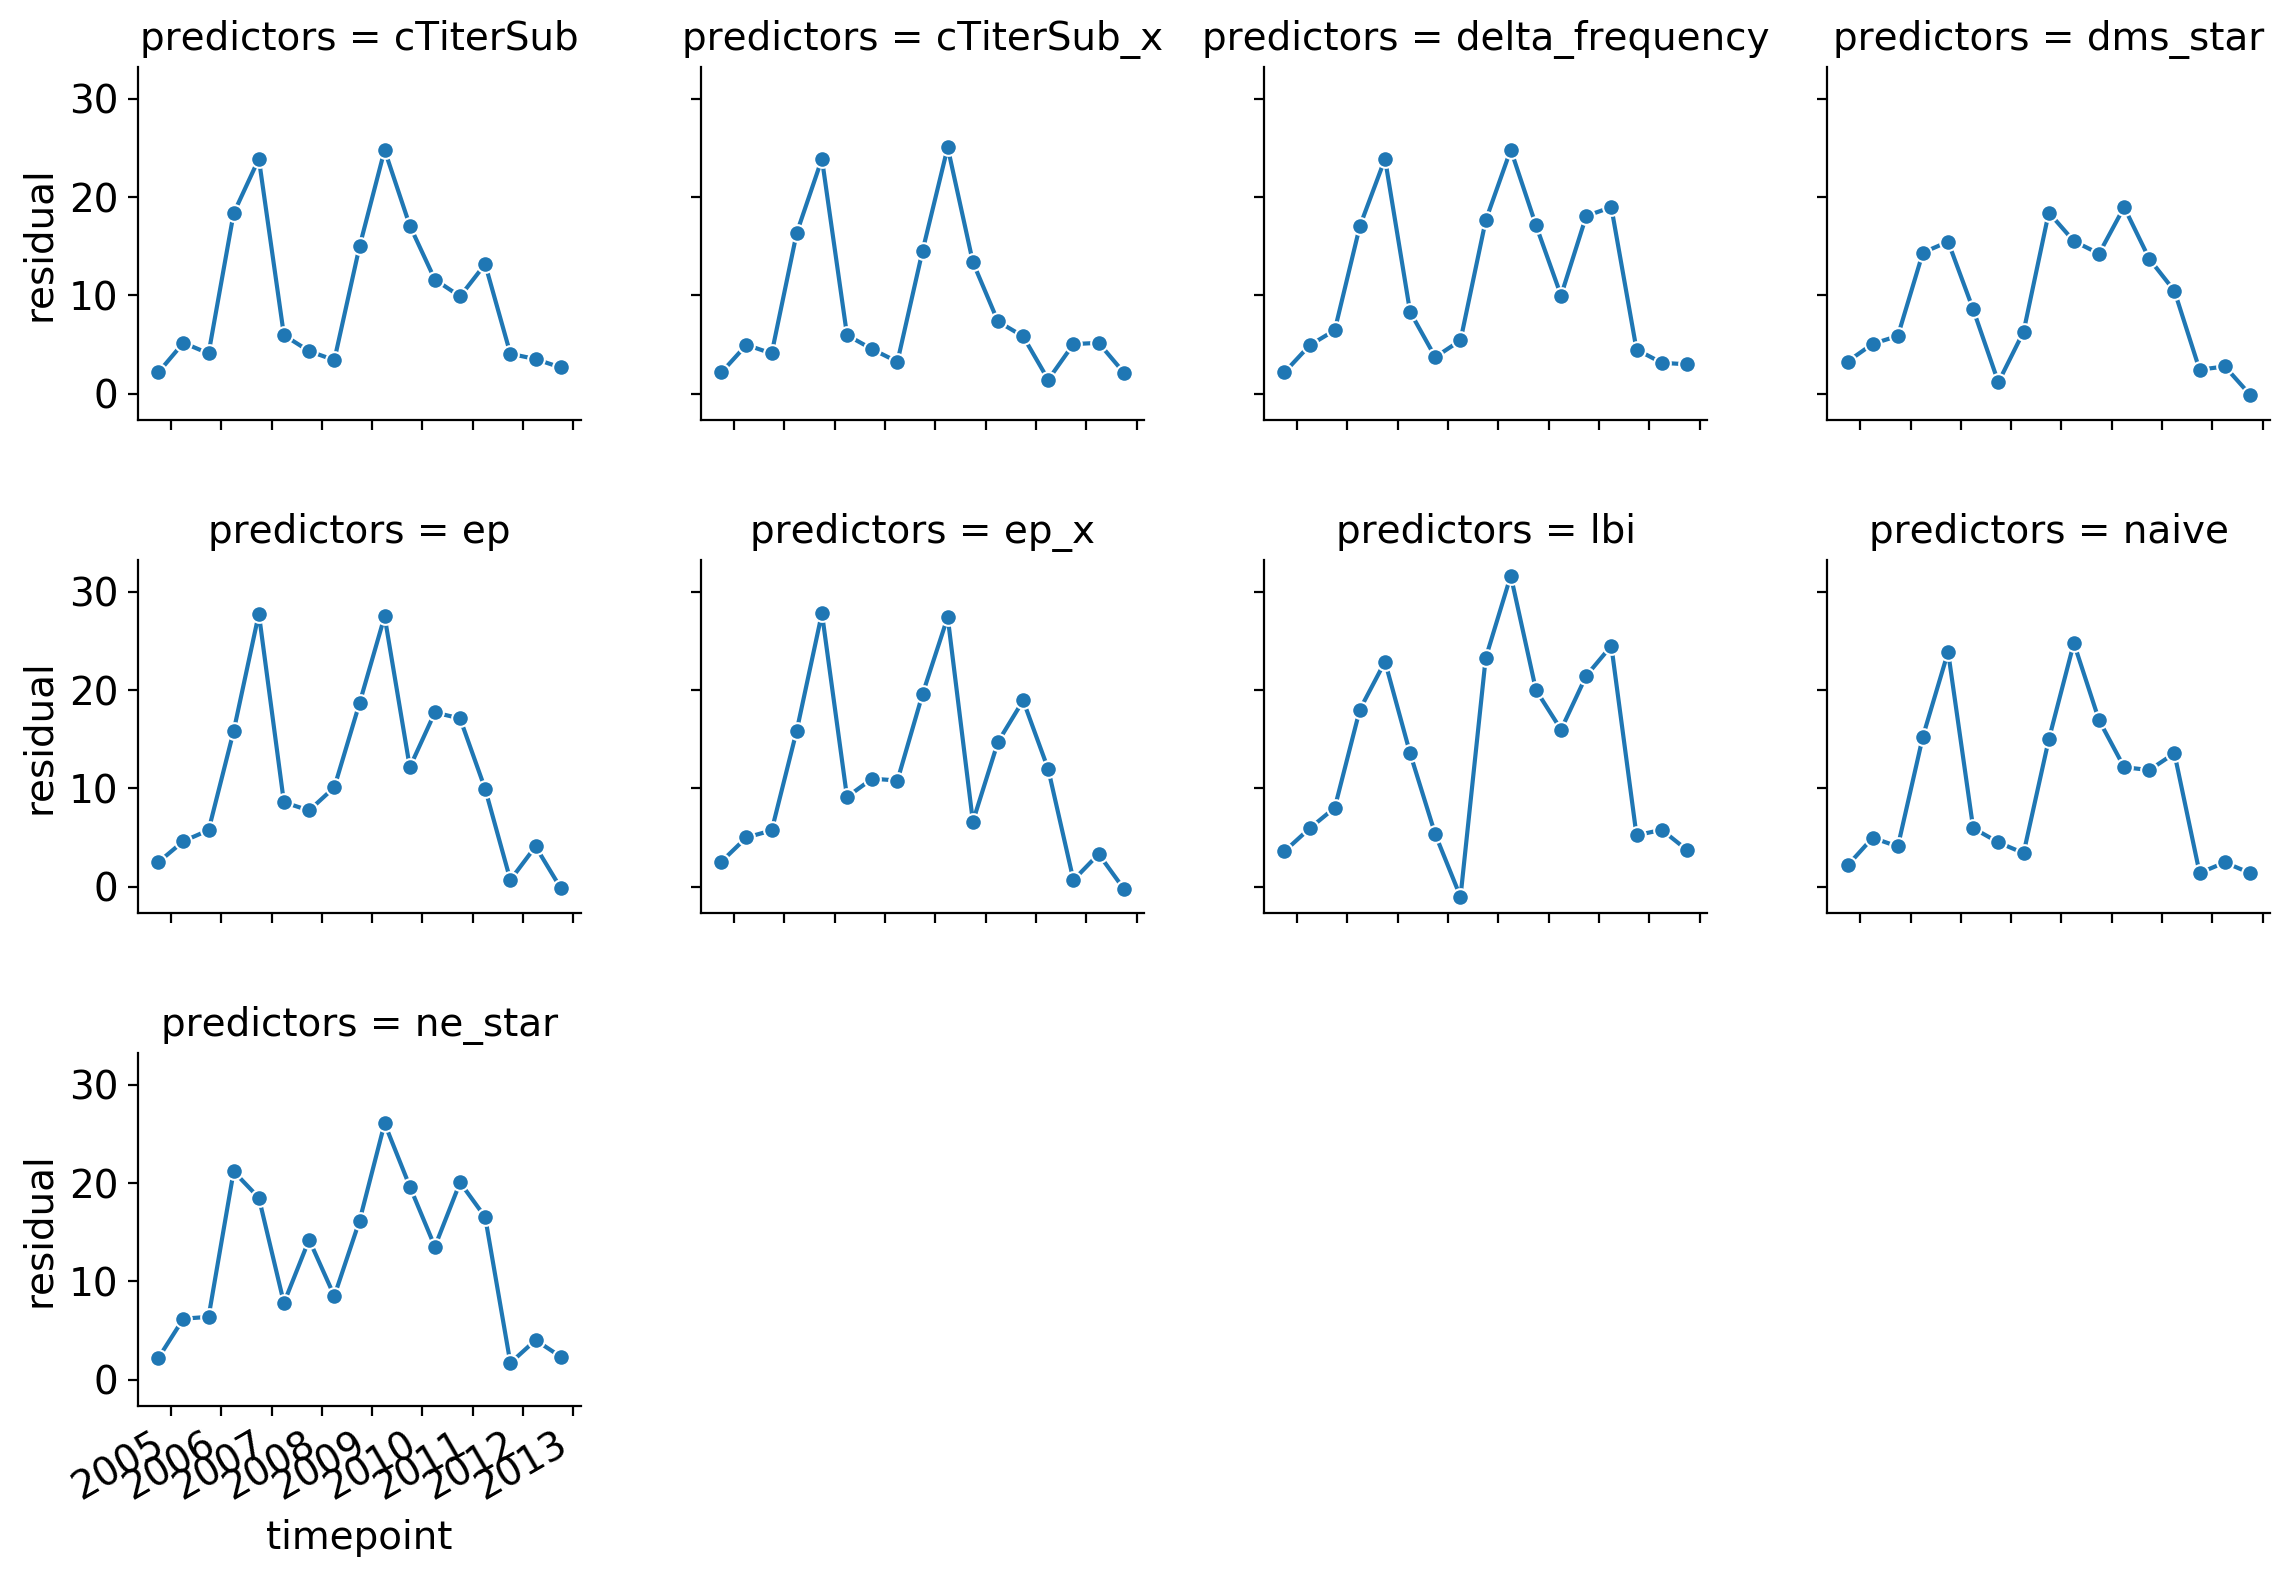

In [247]:
g = sns.FacetGrid(residuals_by_timepoint, col="predictors", col_wrap=4)
g.map(sns.lineplot, "timepoint", "residual", marker="o", linestyle="")
plt.gcf().autofmt_xdate()

In [248]:
np.abs(residuals_by_timepoint[residuals_by_timepoint["predictors"] == "lbi"]["residual"].values - residuals_by_timepoint[residuals_by_timepoint["predictors"] == "naive"]["residual"].values)

array([ 1.44352228,  0.94737935,  3.94152307,  2.73590078,  0.99324637,
        7.62136342,  0.81760808,  4.4469413 ,  8.30062256,  6.85700698,
        3.07430379,  3.82353311,  9.5980496 , 10.94452482,  3.83913529,
        3.32164563,  2.3500522 ])

### Autocorrelation of residuals

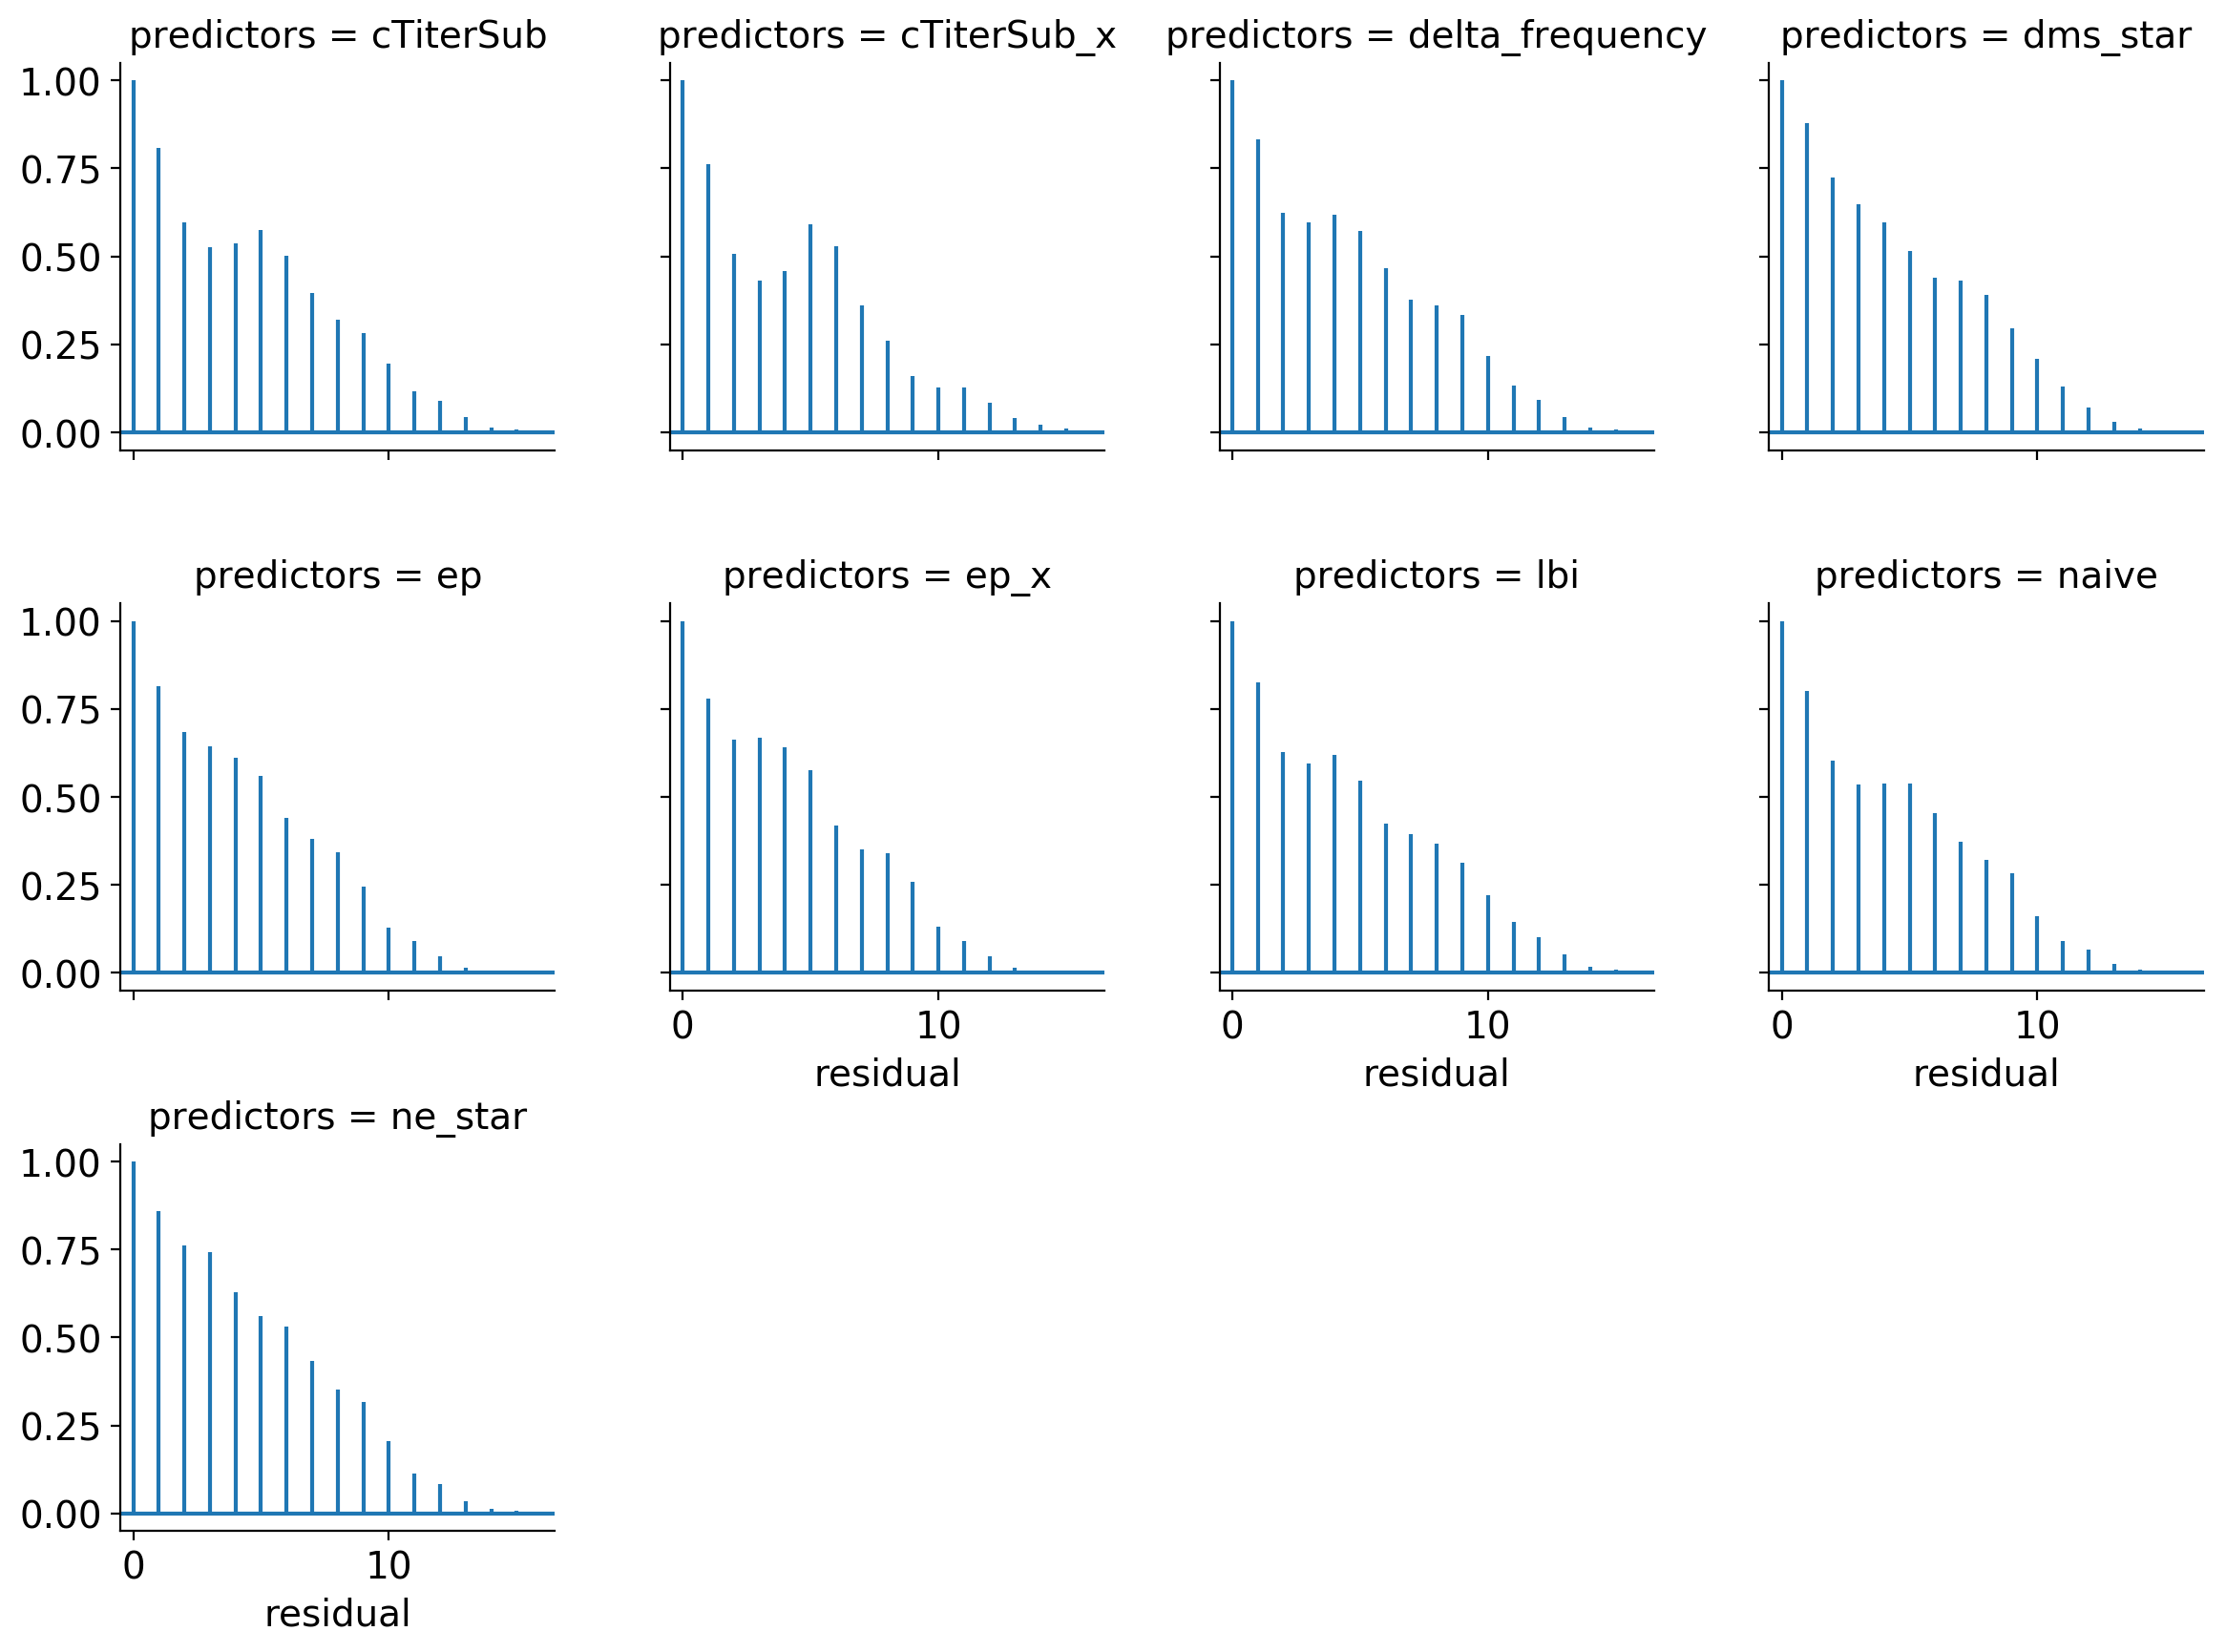

In [249]:
g = sns.FacetGrid(residuals_by_timepoint, col="predictors", col_wrap=4)
g.map(plt.acorr, "residual", maxlags=max_lags)

for ax in g.axes.flatten():
    ax.set_xlim(-0.5, max_lags + 0.5)

## Summarize observed and predicted frequencies and growth rates
[back to top](#Summarize-models)

### Observed and predicted frequencies

In [253]:
frequency_df.head()

strain  timepoint         y  frequency  \
0     A/Adjame/GR765/2011 2011-10-01  0.717610   0.000198   
1   A/Argentina/8823/2011 2011-10-01  0.117335   0.023420   
2  A/Bangladesh/3564/2011 2011-10-01  0.021536   0.000007   
3  A/Bangladesh/5006/2011 2011-10-01  0.120589   0.047458   
4  A/Bangladesh/5071/2011 2011-10-01  0.000029   0.000012   

   weighted_distance_to_future  weighted_distance_to_present     y_hat  \
0                     8.797696                      7.766503  0.001540   
1                    11.560120                      9.226488  0.216082   
2                     6.862932                      6.535858  0.000045   
3                     5.862934                      5.639843  0.267655   
4                     5.862934                      5.639843  0.000065   

     y_diff  residual validation_timepoint predictors  
0  0.001744  0.716070           2011-10-01   dms_star  
1  0.270735 -0.098747           2011-10-01   dms_star  
2  0.000047  0.021491           2011-10-01   dms_star  
3  0.278242 -0.147066           2011-10-01   dms_star  
4  0.000068 -0.000036           2011-10-01   dms_star

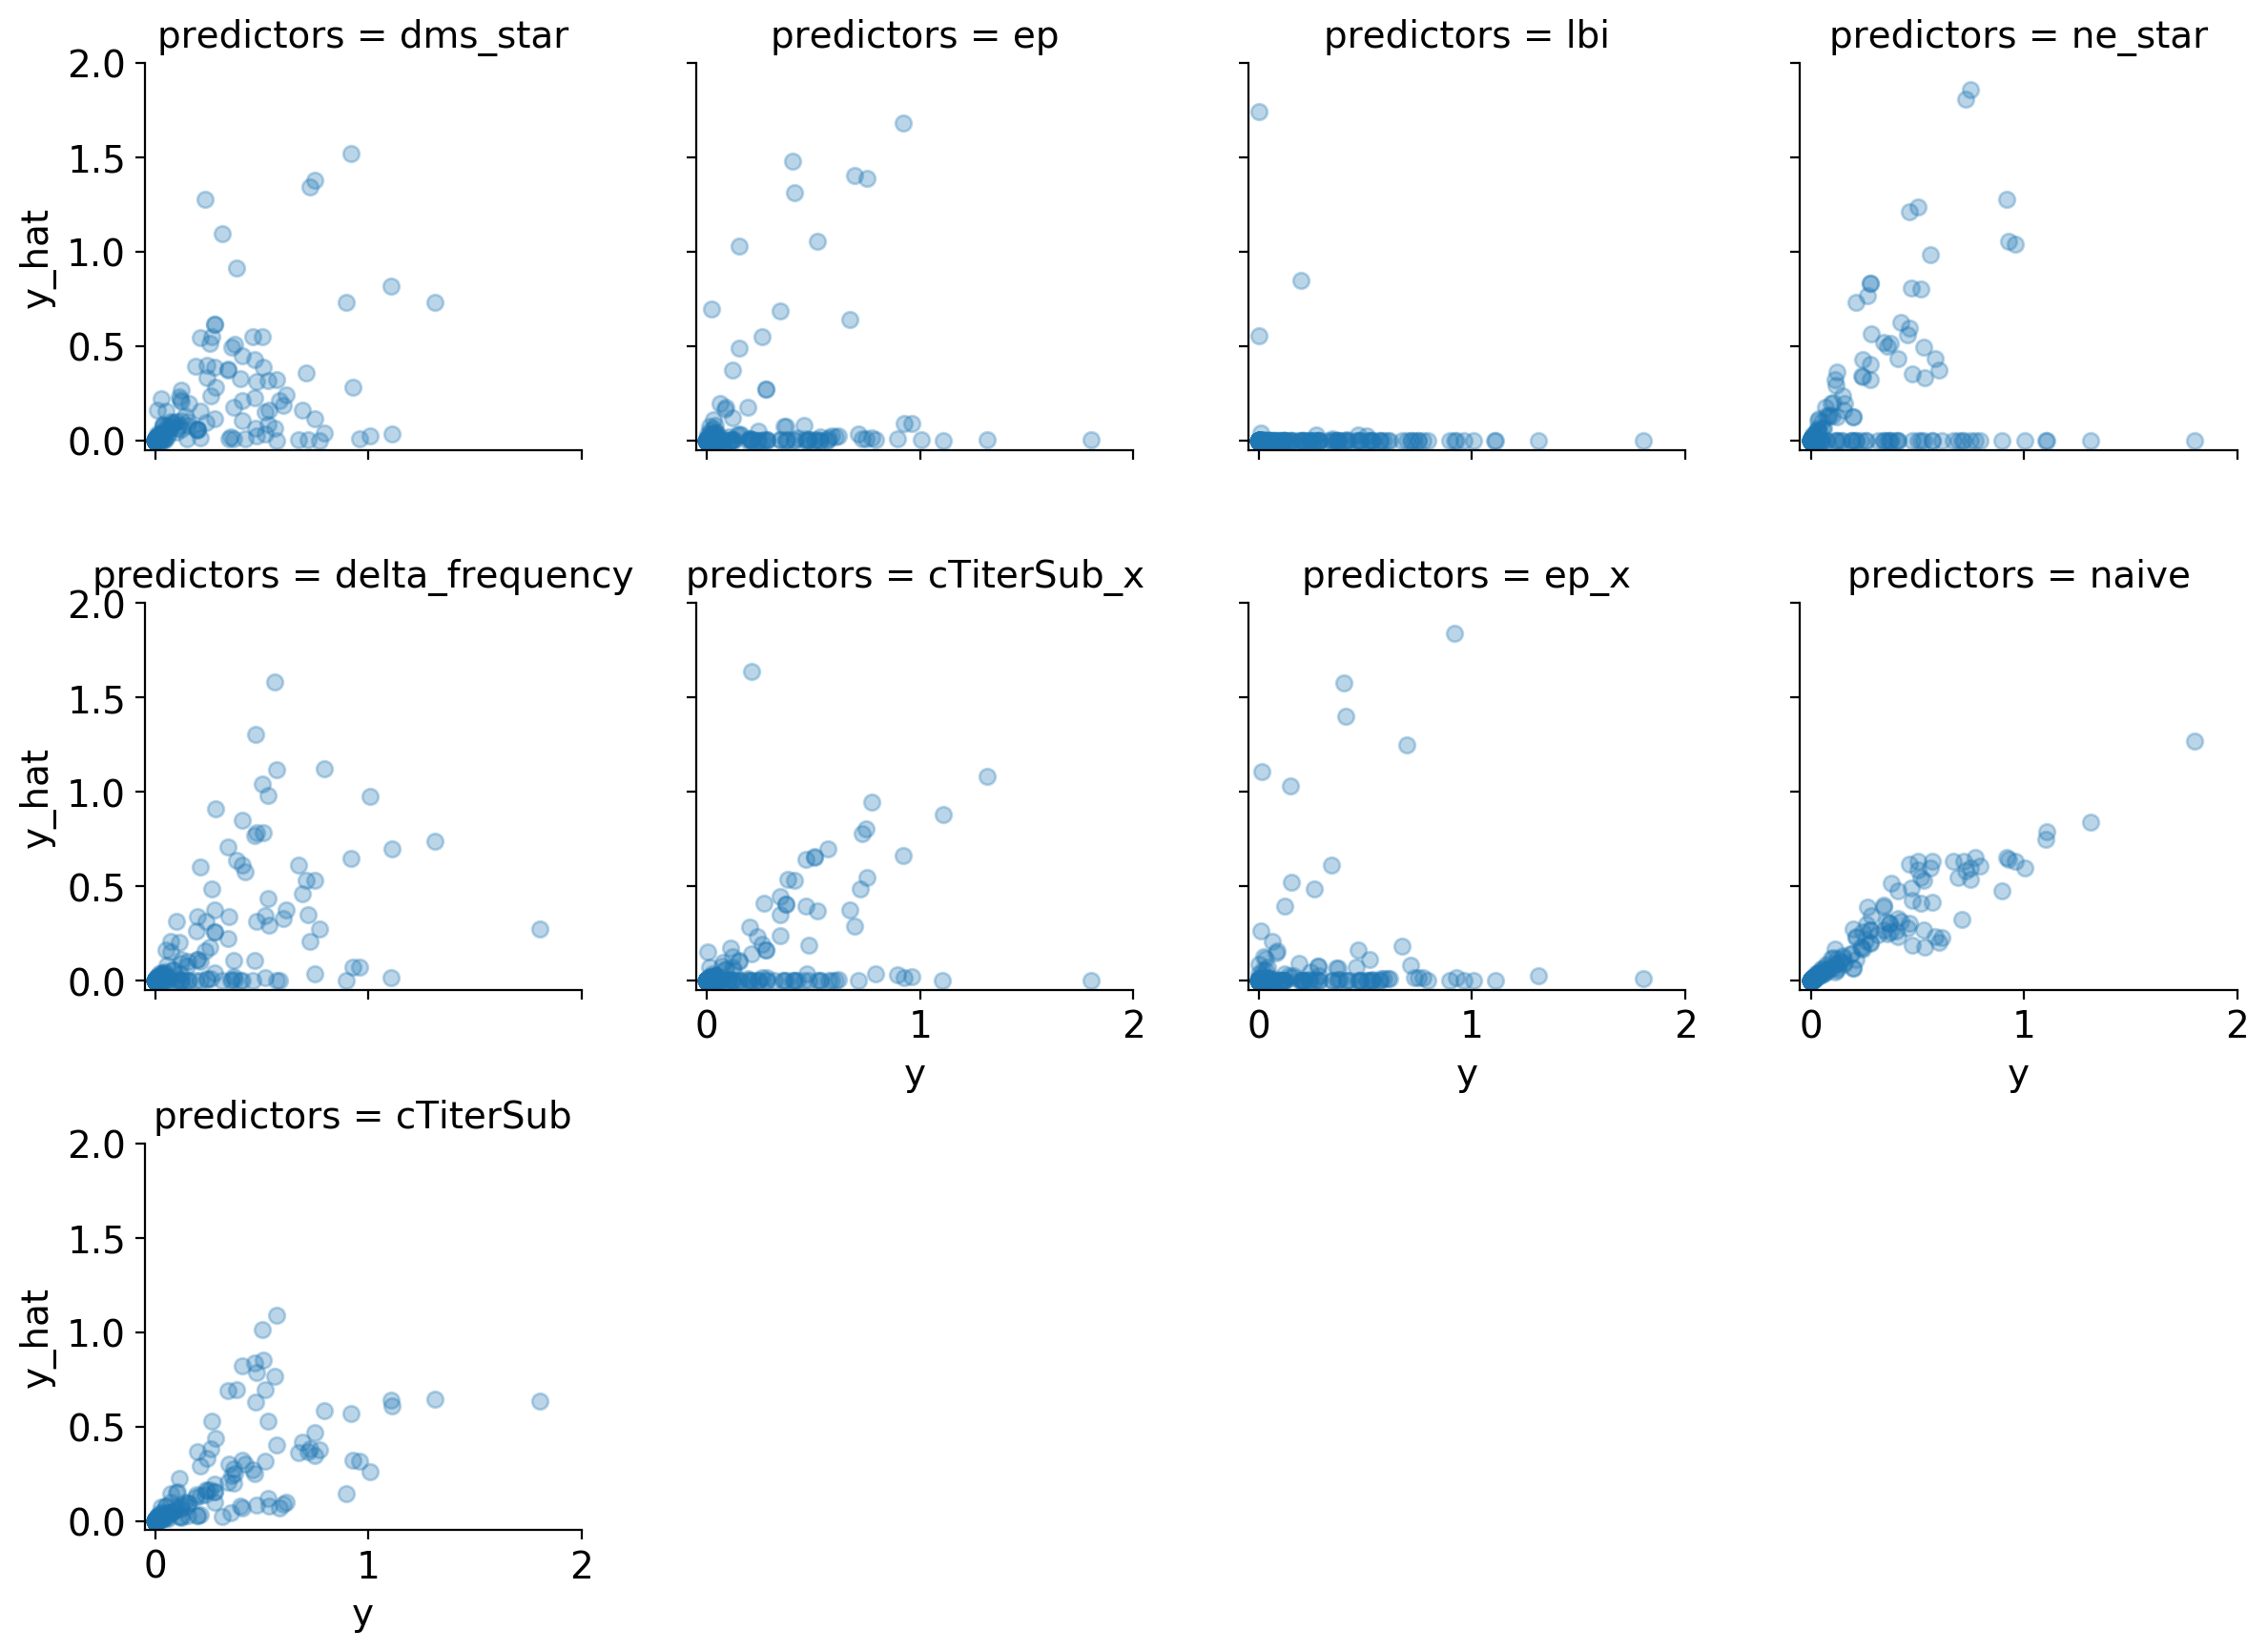

In [260]:
g = sns.FacetGrid(frequency_df, col="predictors", col_wrap=4)
g.map(plt.plot, "y", "y_hat", marker="o", linestyle="", alpha=0.3)

for ax in g.axes.flatten():
    ax.set_xlim(-0.05, 2)
    ax.set_ylim(-0.05, 2)

## Summarize model forecasting error
[back to top](#Summarize-models)

### Weighted distances

In [458]:
errors_by_time_df.head()

predictors  validation_error  validation_n validation_timepoint
0   dms_star          7.547656            39           2011-10-01
1   dms_star          9.605958            45           2012-04-01
2   dms_star         12.734542            40           2012-10-01
3   dms_star          6.848601            43           2013-04-01
4   dms_star          7.737192            42           2013-10-01

In [459]:
negative_information_gain_df = errors_by_time_df.groupby("predictors")["validation_error"].aggregate([
    "sum",
    "mean",
    "median"
]).sort_values(by="sum").reset_index()

In [460]:
negative_information_gain_df

predictors        sum       mean    median
0              lbi  46.815804   6.687972  5.312626
1  delta_frequency  55.747278   7.963897  8.333603
2          ne_star  55.769799   7.967114  7.891813
3        cTiterSub  58.365640   8.337949  8.015869
4            naive  59.601918   8.514560  8.402123
5      cTiterSub_x  63.184121   9.026303  8.685229
6         dms_star  63.568732   9.081247  9.113377
7               ep  67.639023   9.662718  8.562084
8             ep_x  70.034182  10.004883  8.666760

In [461]:
negative_information_gain_df.loc[negative_information_gain_df["predictors"] == "naive", "sum"].values[0]

59.6019177400226

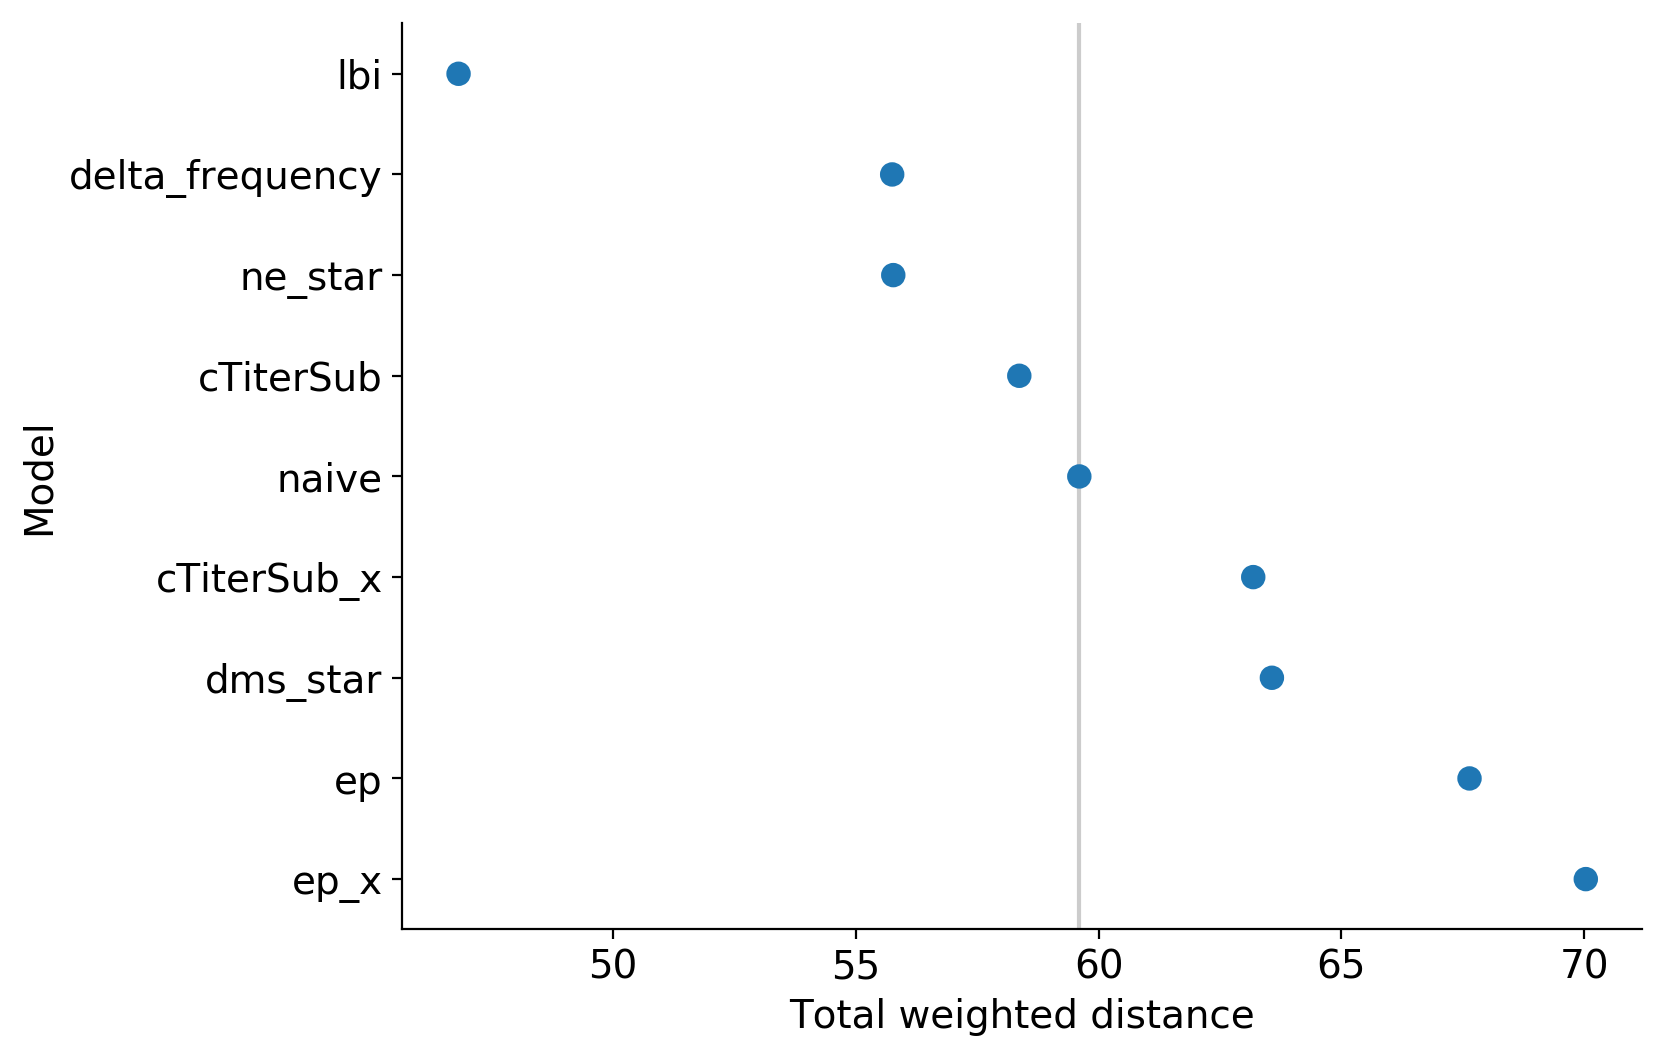

In [462]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.pointplot(
    x="sum",
    y="predictors",
    data=negative_information_gain_df,
    join=False,
    ax=ax
)
#ax.set_xlim(left=0)
ax.set_xlabel("Total weighted distance")
ax.set_ylabel("Model")
ax.axvline(
    x=negative_information_gain_df.loc[negative_information_gain_df["predictors"] == "naive", "sum"].values[0],
    color="#cccccc",
    zorder=-10
)

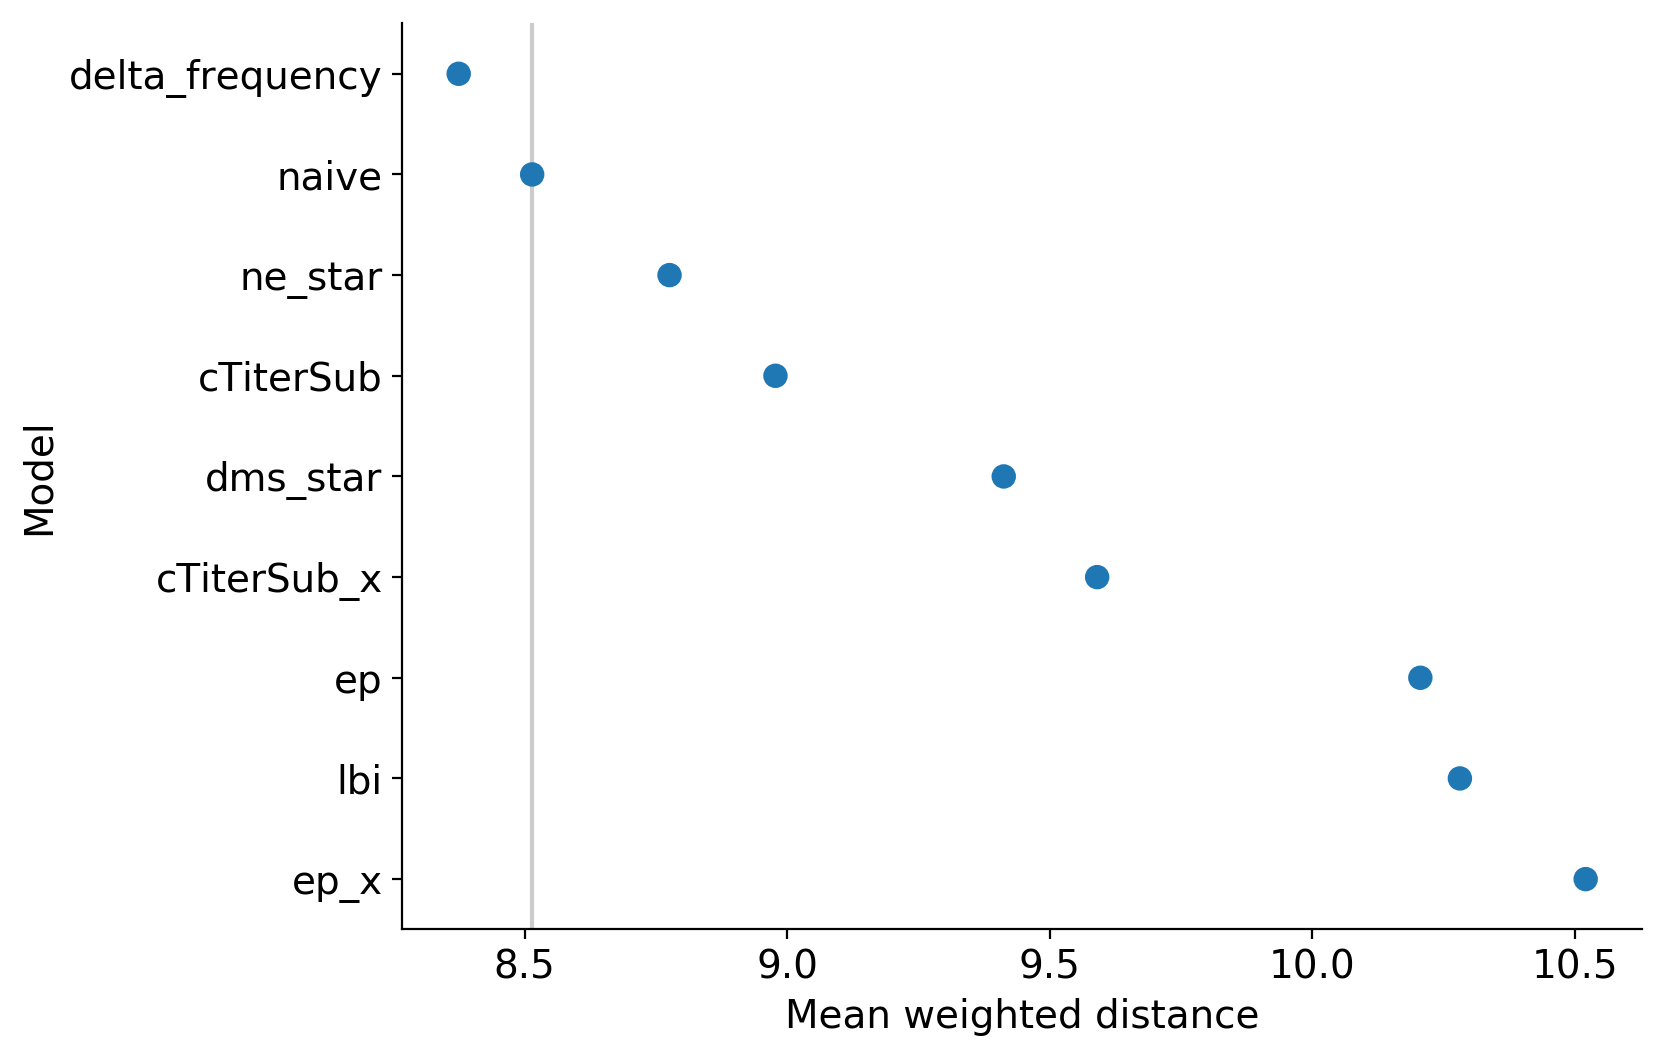

In [413]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.pointplot(
    x="mean",
    y="predictors",
    data=negative_information_gain_df,
    join=False,
    ax=ax
)
#ax.set_xlim(left=0)
ax.set_xlabel("Mean weighted distance")
ax.set_ylabel("Model")

ax.axvline(
    x=negative_information_gain_df.loc[negative_information_gain_df["predictors"] == "naive", "mean"].values[0],
    color="#cccccc",
    zorder=-10
)

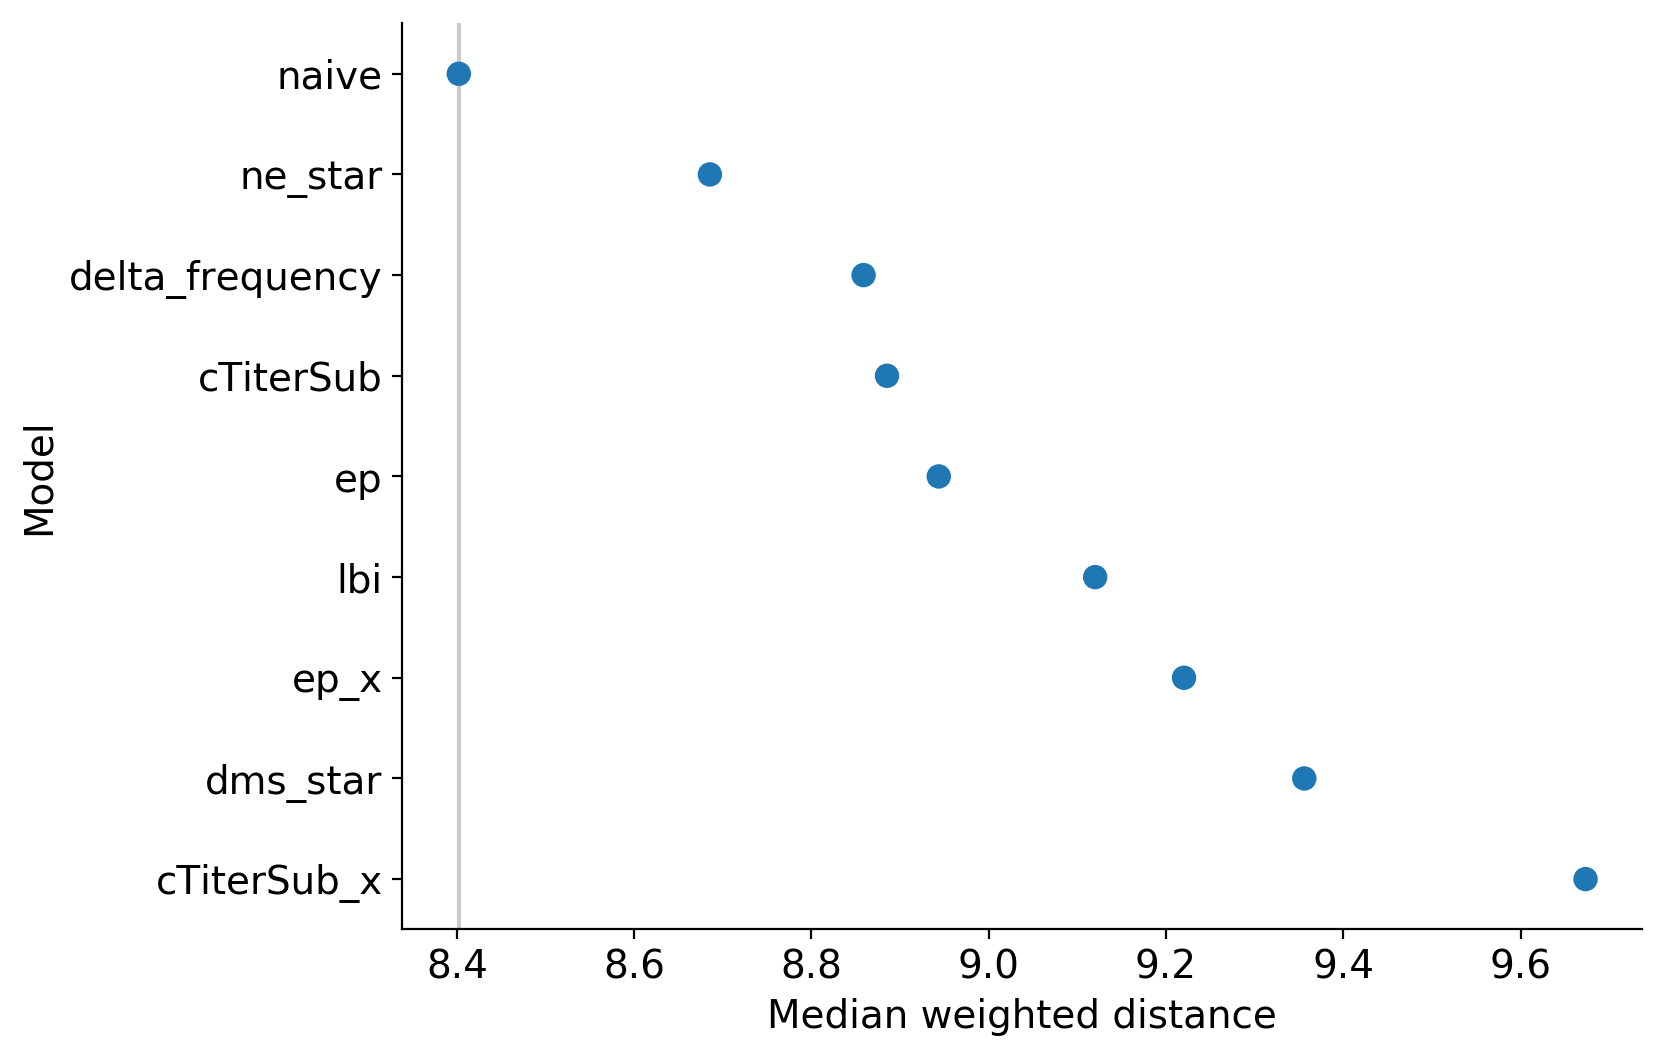

In [414]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.pointplot(
    x="median",
    y="predictors",
    data=negative_information_gain_df,
    join=False,
    ax=ax,
    order=negative_information_gain_df.sort_values("median").loc[:, "predictors"]
)
#ax.set_xlim(left=0)
ax.set_xlabel("Median weighted distance")
ax.set_ylabel("Model")

ax.axvline(
    x=negative_information_gain_df.loc[negative_information_gain_df["predictors"] == "naive", "median"].values[0],
    color="#cccccc",
    zorder=-10
)

In [415]:
errors_by_time_df.head()

predictors  validation_error  validation_n validation_timepoint
0   dms_star          8.490168            39           2011-10-01
1   dms_star          9.930164            45           2012-04-01
2   dms_star         12.884151            40           2012-10-01
3   dms_star          7.158733            43           2013-04-01
4   dms_star          7.957403            42           2013-10-01

(0, 15.133583417322754)

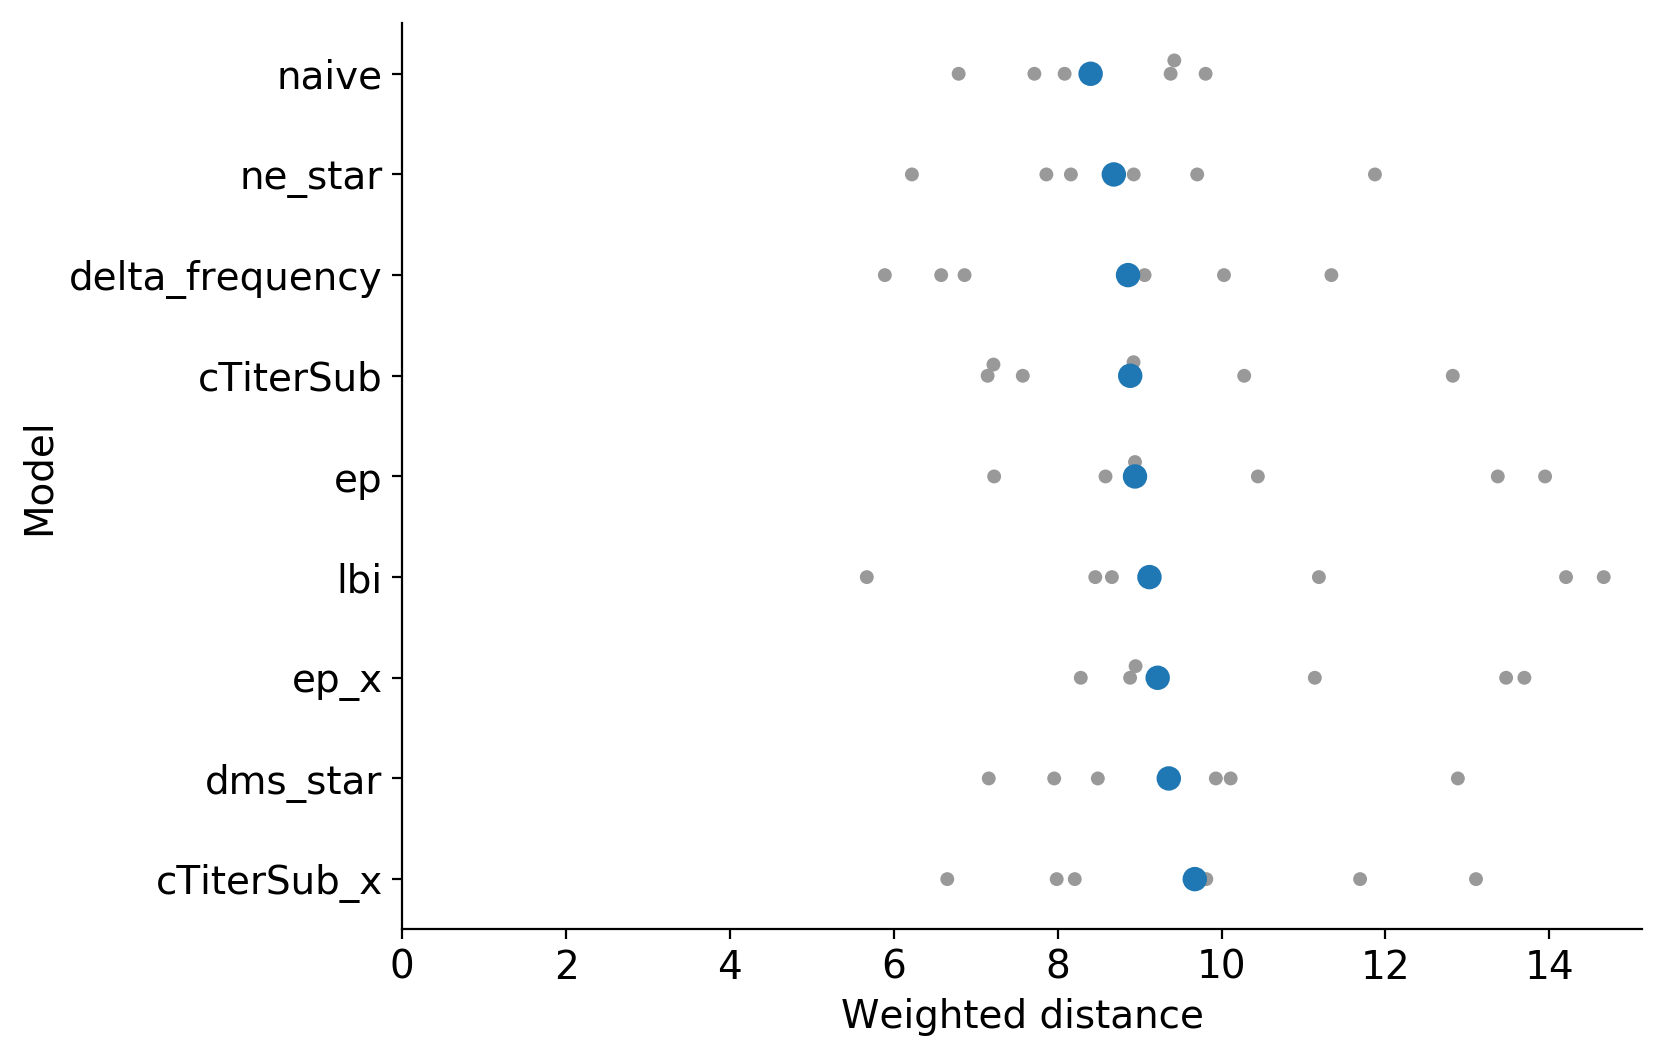

In [416]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

sns.swarmplot(
    x="validation_error",
    y="predictors",
    data=errors_by_time_df,
    ax=ax,
    order=negative_information_gain_df.sort_values("median").loc[:, "predictors"],
    color="#999999",
    zorder=-10
)

sns.pointplot(
    x="median",
    y="predictors",
    data=negative_information_gain_df,
    join=False,
    ax=ax,
    order=negative_information_gain_df.sort_values("median").loc[:, "predictors"]
)

ax.set_xlabel("Weighted distance")
ax.set_ylabel("Model")
ax.set_xlim(left=0)

In [417]:
predictor_type_order = [
    "naive",
    "ep",
    "cTiterSub",
    "ep_x",
    "cTiterSub_x",
    "ne_star",
    "dms_star",
    "lbi",
    "delta_frequency"
]

In [418]:
predictor_names = [
    "null",
    "epitope mutations",
    "HI phenotypes",
    "epitope cross-immunity",
    "HI cross-immunity",
    "non-epitope mutations",
    "DMS mutation effects",
    "LBI",
    "delta frequency"
]

In [419]:
predictor_name_by_id = dict(zip(predictor_type_order, predictor_names))

In [420]:
predictor_name_by_id

{'naive': 'null',
 'ep': 'epitope mutations',
 'cTiterSub': 'HI phenotypes',
 'ep_x': 'epitope cross-immunity',
 'cTiterSub_x': 'HI cross-immunity',
 'ne_star': 'non-epitope mutations',
 'dms_star': 'DMS mutation effects',
 'lbi': 'LBI',
 'delta_frequency': 'delta frequency'}

In [421]:
errors_by_time_df["predictors_name"] = errors_by_time_df["predictors"].map(predictor_name_by_id)

In [422]:
errors_by_time_df[errors_by_time_df["predictors"] == "naive"]

predictors  validation_error  validation_n validation_timepoint  \
49      naive          7.715725            39           2011-10-01   
50      naive          9.378652            45           2012-04-01   
51      naive          8.402123            40           2012-10-01   
52      naive          6.791494            43           2013-04-01   
53      naive          8.084953            42           2013-10-01   
54      naive          9.423493            49           2014-04-01   
55      naive          9.805478            48           2014-10-01   

   predictors_name  
49            null  
50            null  
51            null  
52            null  
53            null  
54            null  
55            null

In [423]:
individual_median_errors = []
for predictor in predictor_type_order:
    individual_median_errors.append(
        negative_information_gain_df.loc[negative_information_gain_df["predictors"] == predictor, "median"].values[0]
    )

In [424]:
individual_median_errors

[8.402122941917883,
 8.943628028900443,
 8.885244502054872,
 9.220361287435829,
 9.673362240631414,
 8.685380632010167,
 9.356022646074026,
 9.120111363546519,
 8.858783756671963]

(0, 15.13276602152645)

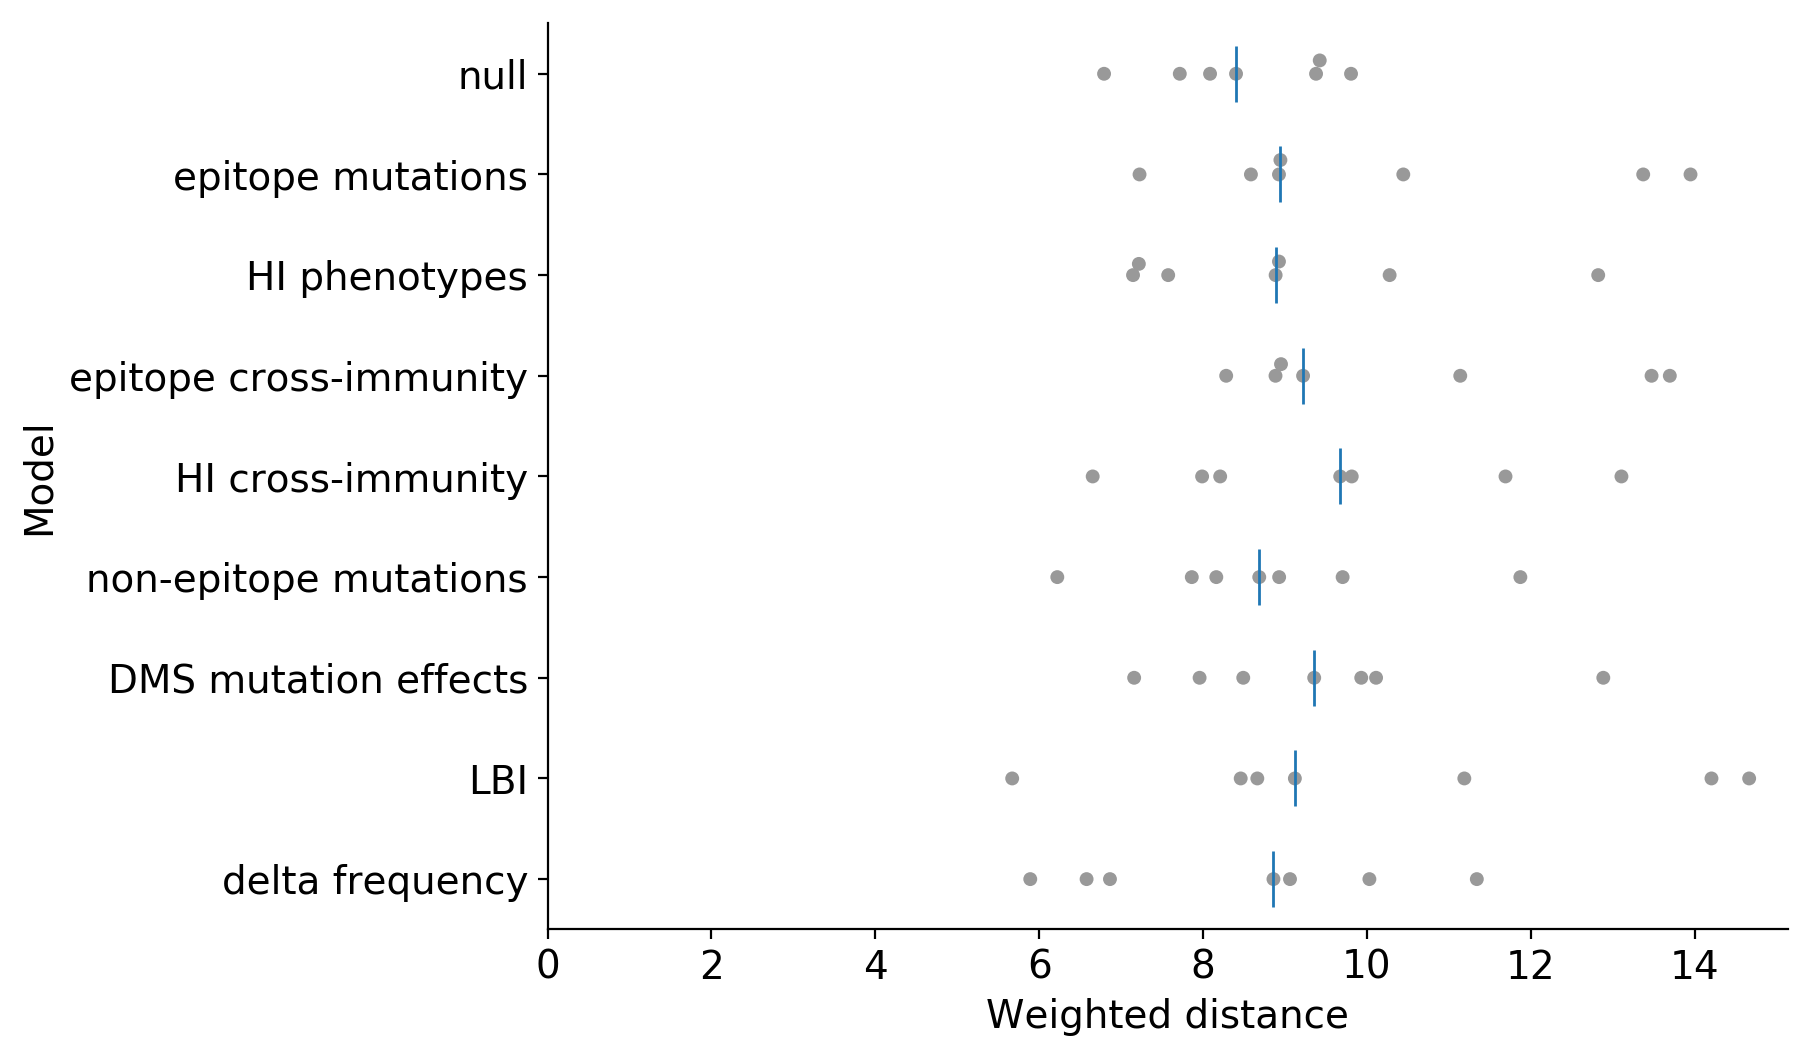

In [425]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(
    individual_median_errors,
    predictor_type_order,
    marker="|",
    markersize=20,
    linestyle=""
)

ax = sns.swarmplot(
    x="validation_error",
    y="predictors",
    data=errors_by_time_df,
    ax=ax,
    order=predictor_type_order,
    color="#999999",
    zorder=-10
)

ax.set_yticklabels(predictor_names)

ax.set_xlabel("Weighted distance")
ax.set_ylabel("Model")
ax.set_xlim(left=0)

In [426]:
errors_by_time_df[errors_by_time_df["predictors"].str.contains("-")]["predictors"].unique()

array([], dtype=object)

In [427]:
composite_predictors_order = [
    "lbi",
    "delta_frequency",
    "cTiterSub_x",
    "lbi-delta_frequency",
    "lbi-cTiterSub_x",
    "lbi-dms_star-cTiterSub_x",
    "lbi-ep_x-ne_star"
]

In [428]:
composite_predictor_names = [
    "LBI",
    "delta frequency",
    "HI cross.",
    "LBI, delta frequency",
    "LBI, HI cross.",
    "LBI, DMS, HI cross.",
    "Luksza and Lassig"
]

In [429]:
median_errors = []
for predictor in composite_predictors_order:
    median_errors.append(negative_information_gain_df.loc[negative_information_gain_df["predictors"] == predictor, "median"].values[0])

IndexError: index 0 is out of bounds for axis 0 with size 0

In [61]:
composite_predictors_order = [
    "lbi",
    "delta_frequency",
    "cTiterSub_x",
    "lbi-delta_frequency",
    "lbi-cTiterSub_x",
    "lbi-dms_star-cTiterSub_x",
    "lbi-ep_x-ne_star"
]

composite_predictor_names = [
    "LBI",
    "delta frequency",
    "HI phenotypes",
    "LBI, delta frequency",
    "LBI, HI phenotypes",
    "LBI, DMS, HI phenotypes",
    "Luksza and Lassig"
]

In [62]:
median_errors

[-0.16505950120175164,
 -0.1592386259224665,
 -0.11271069732935608,
 -0.11898042476648953,
 -0.24991481682649808,
 -0.0347586939378452,
 0.04376848640274728]

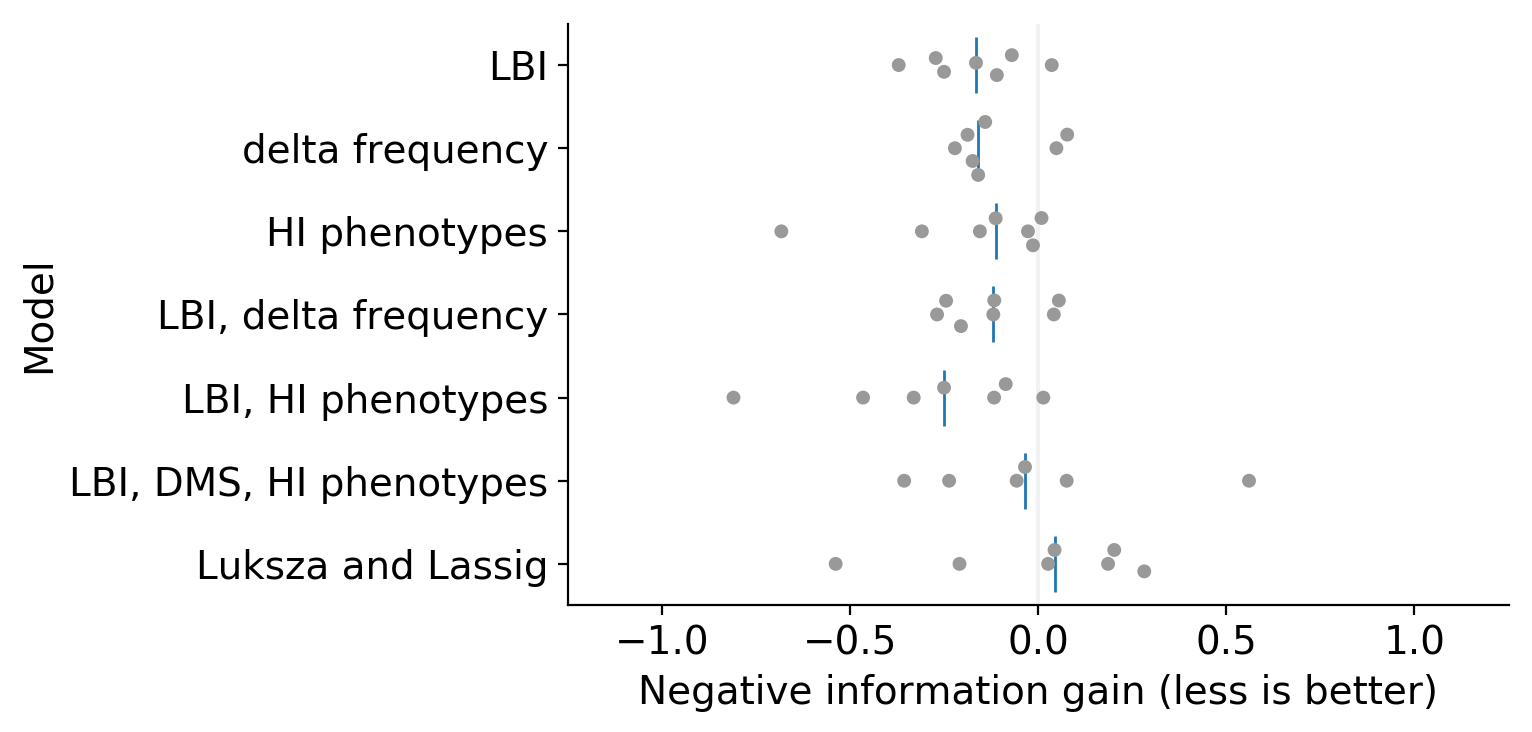

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax = sns.swarmplot(
    x="validation_error",
    y="predictors",
    data=errors_by_time_df,
    ax=ax,
    color="#999999",
    order=composite_predictors_order
)

ax.plot(
    median_errors,
    composite_predictors_order,
    marker="|",
    markersize=20,
    linestyle=""
)

ax.set_xlim(-1.25, 1.25)
ax.set_yticklabels(composite_predictor_names)

#labels = ax.get_yticklabels()
#output = plt.setp(labels, rotation=30)

ax.set_xlabel("Negative information gain (less is better)")
ax.set_ylabel("Model")
ax.axvline(x=0.0, color="#cccccc", zorder=-20, alpha=0.25)

plt.tight_layout()

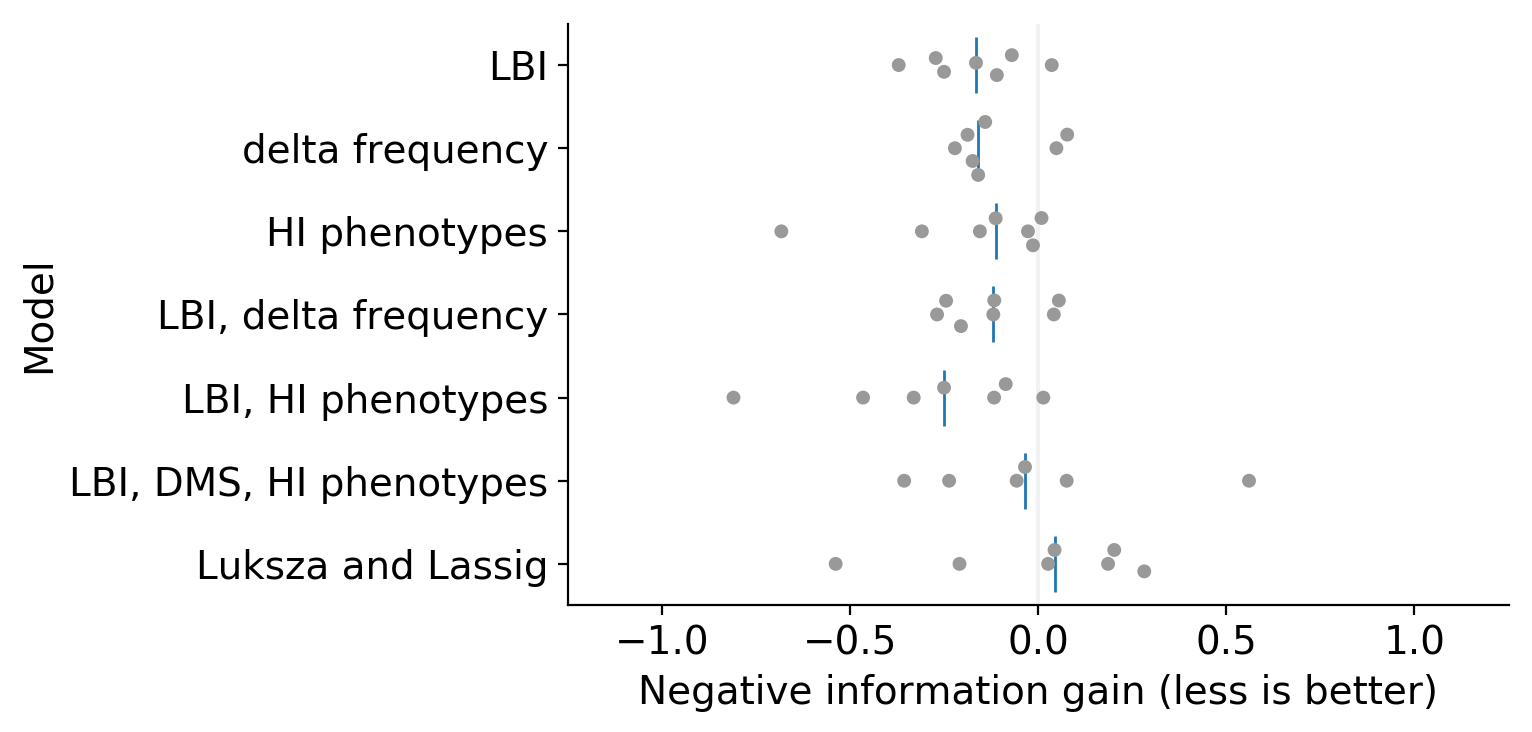

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax = sns.swarmplot(
    x="validation_error",
    y="predictors",
    data=errors_by_time_df,
    ax=ax,
    color="#999999",
    order=composite_predictors_order
)

ax.plot(
    median_errors,
    composite_predictors_order,
    marker="|",
    markersize=20,
    linestyle=""
)

ax.set_xlim(-1.25, 1.25)
ax.set_yticklabels(composite_predictor_names)

#labels = ax.get_yticklabels()
#output = plt.setp(labels, rotation=30)

ax.set_xlabel("Negative information gain (less is better)")
ax.set_ylabel("Model")
ax.axvline(x=0.0, color="#cccccc", zorder=-20, alpha=0.25)

plt.tight_layout()

In [354]:
errors_by_time_df.loc[pd.isnull(errors_by_time_df["predictors_name"]), "predictors_name"] = errors_by_time_df.loc[
    pd.isnull(errors_by_time_df["predictors_name"]), "predictors"
]

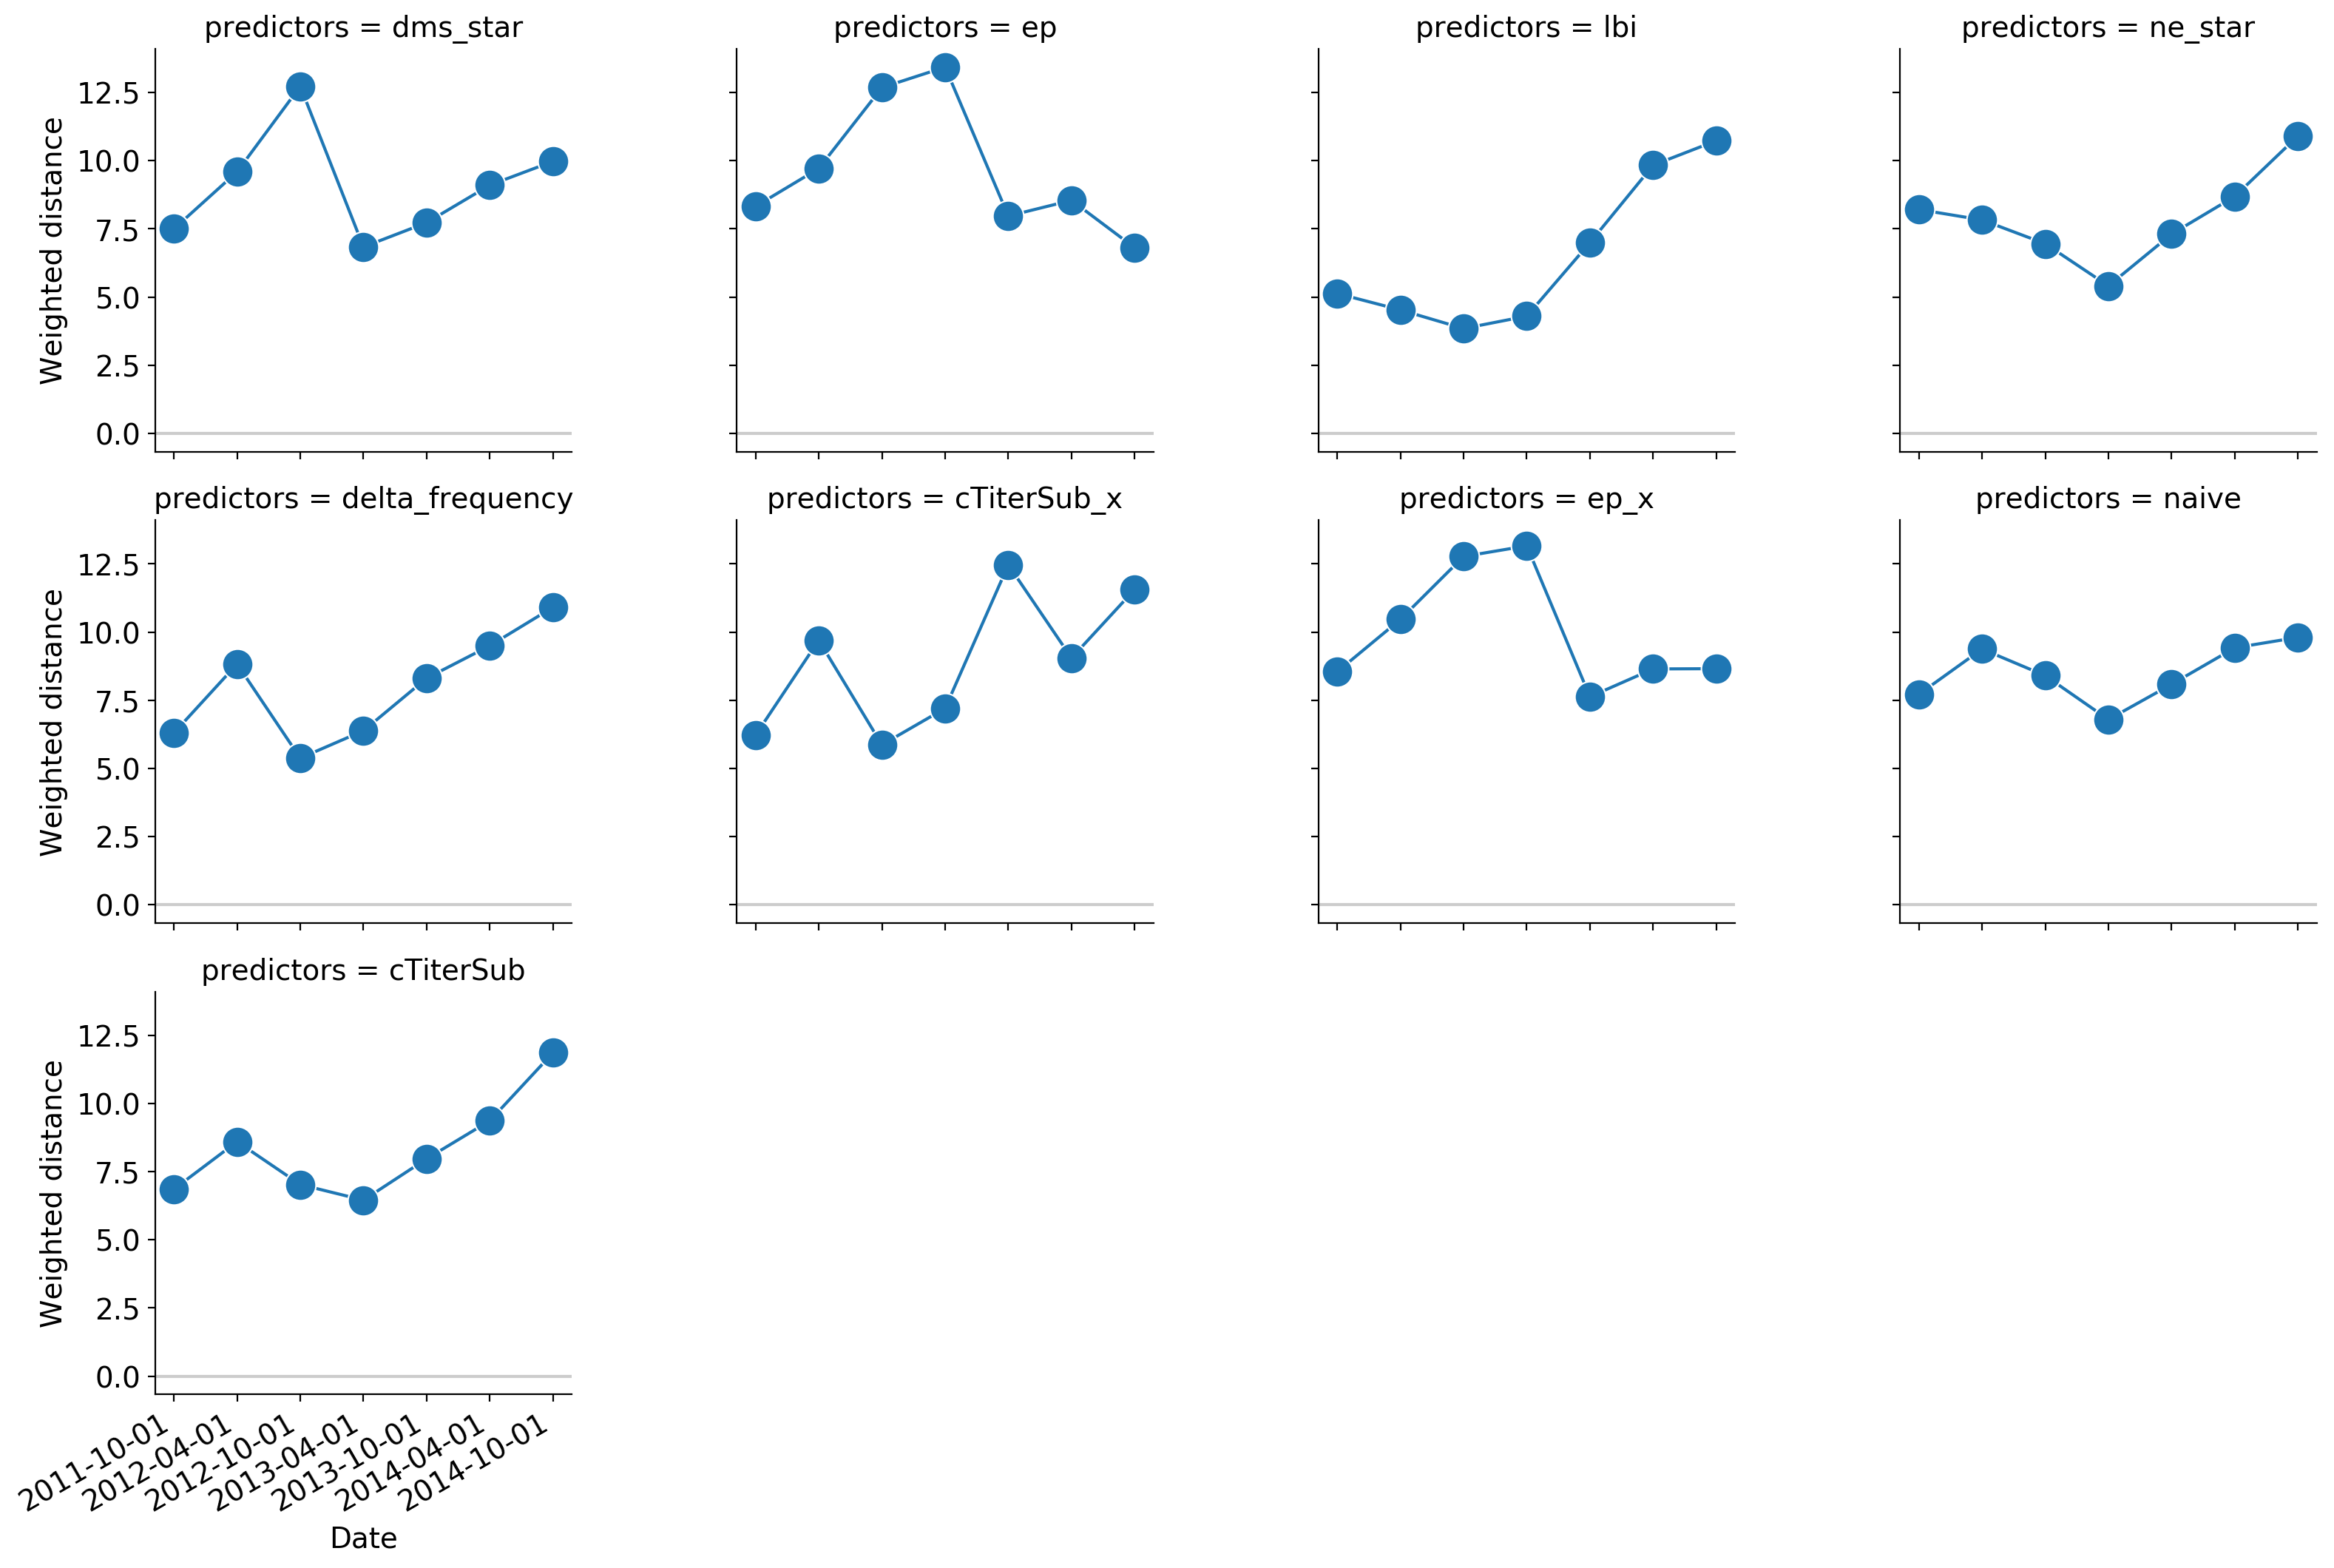

In [355]:
g = facet_time_plot(errors_by_time_df, "validation_error", "Weighted distance", timepoint_column="validation_timepoint")

In [356]:
predictor_type_order

['naive',
 'ep',
 'cTiterSub',
 'ep_x',
 'cTiterSub_x',
 'ne_star',
 'dms_star',
 'lbi',
 'delta_frequency']

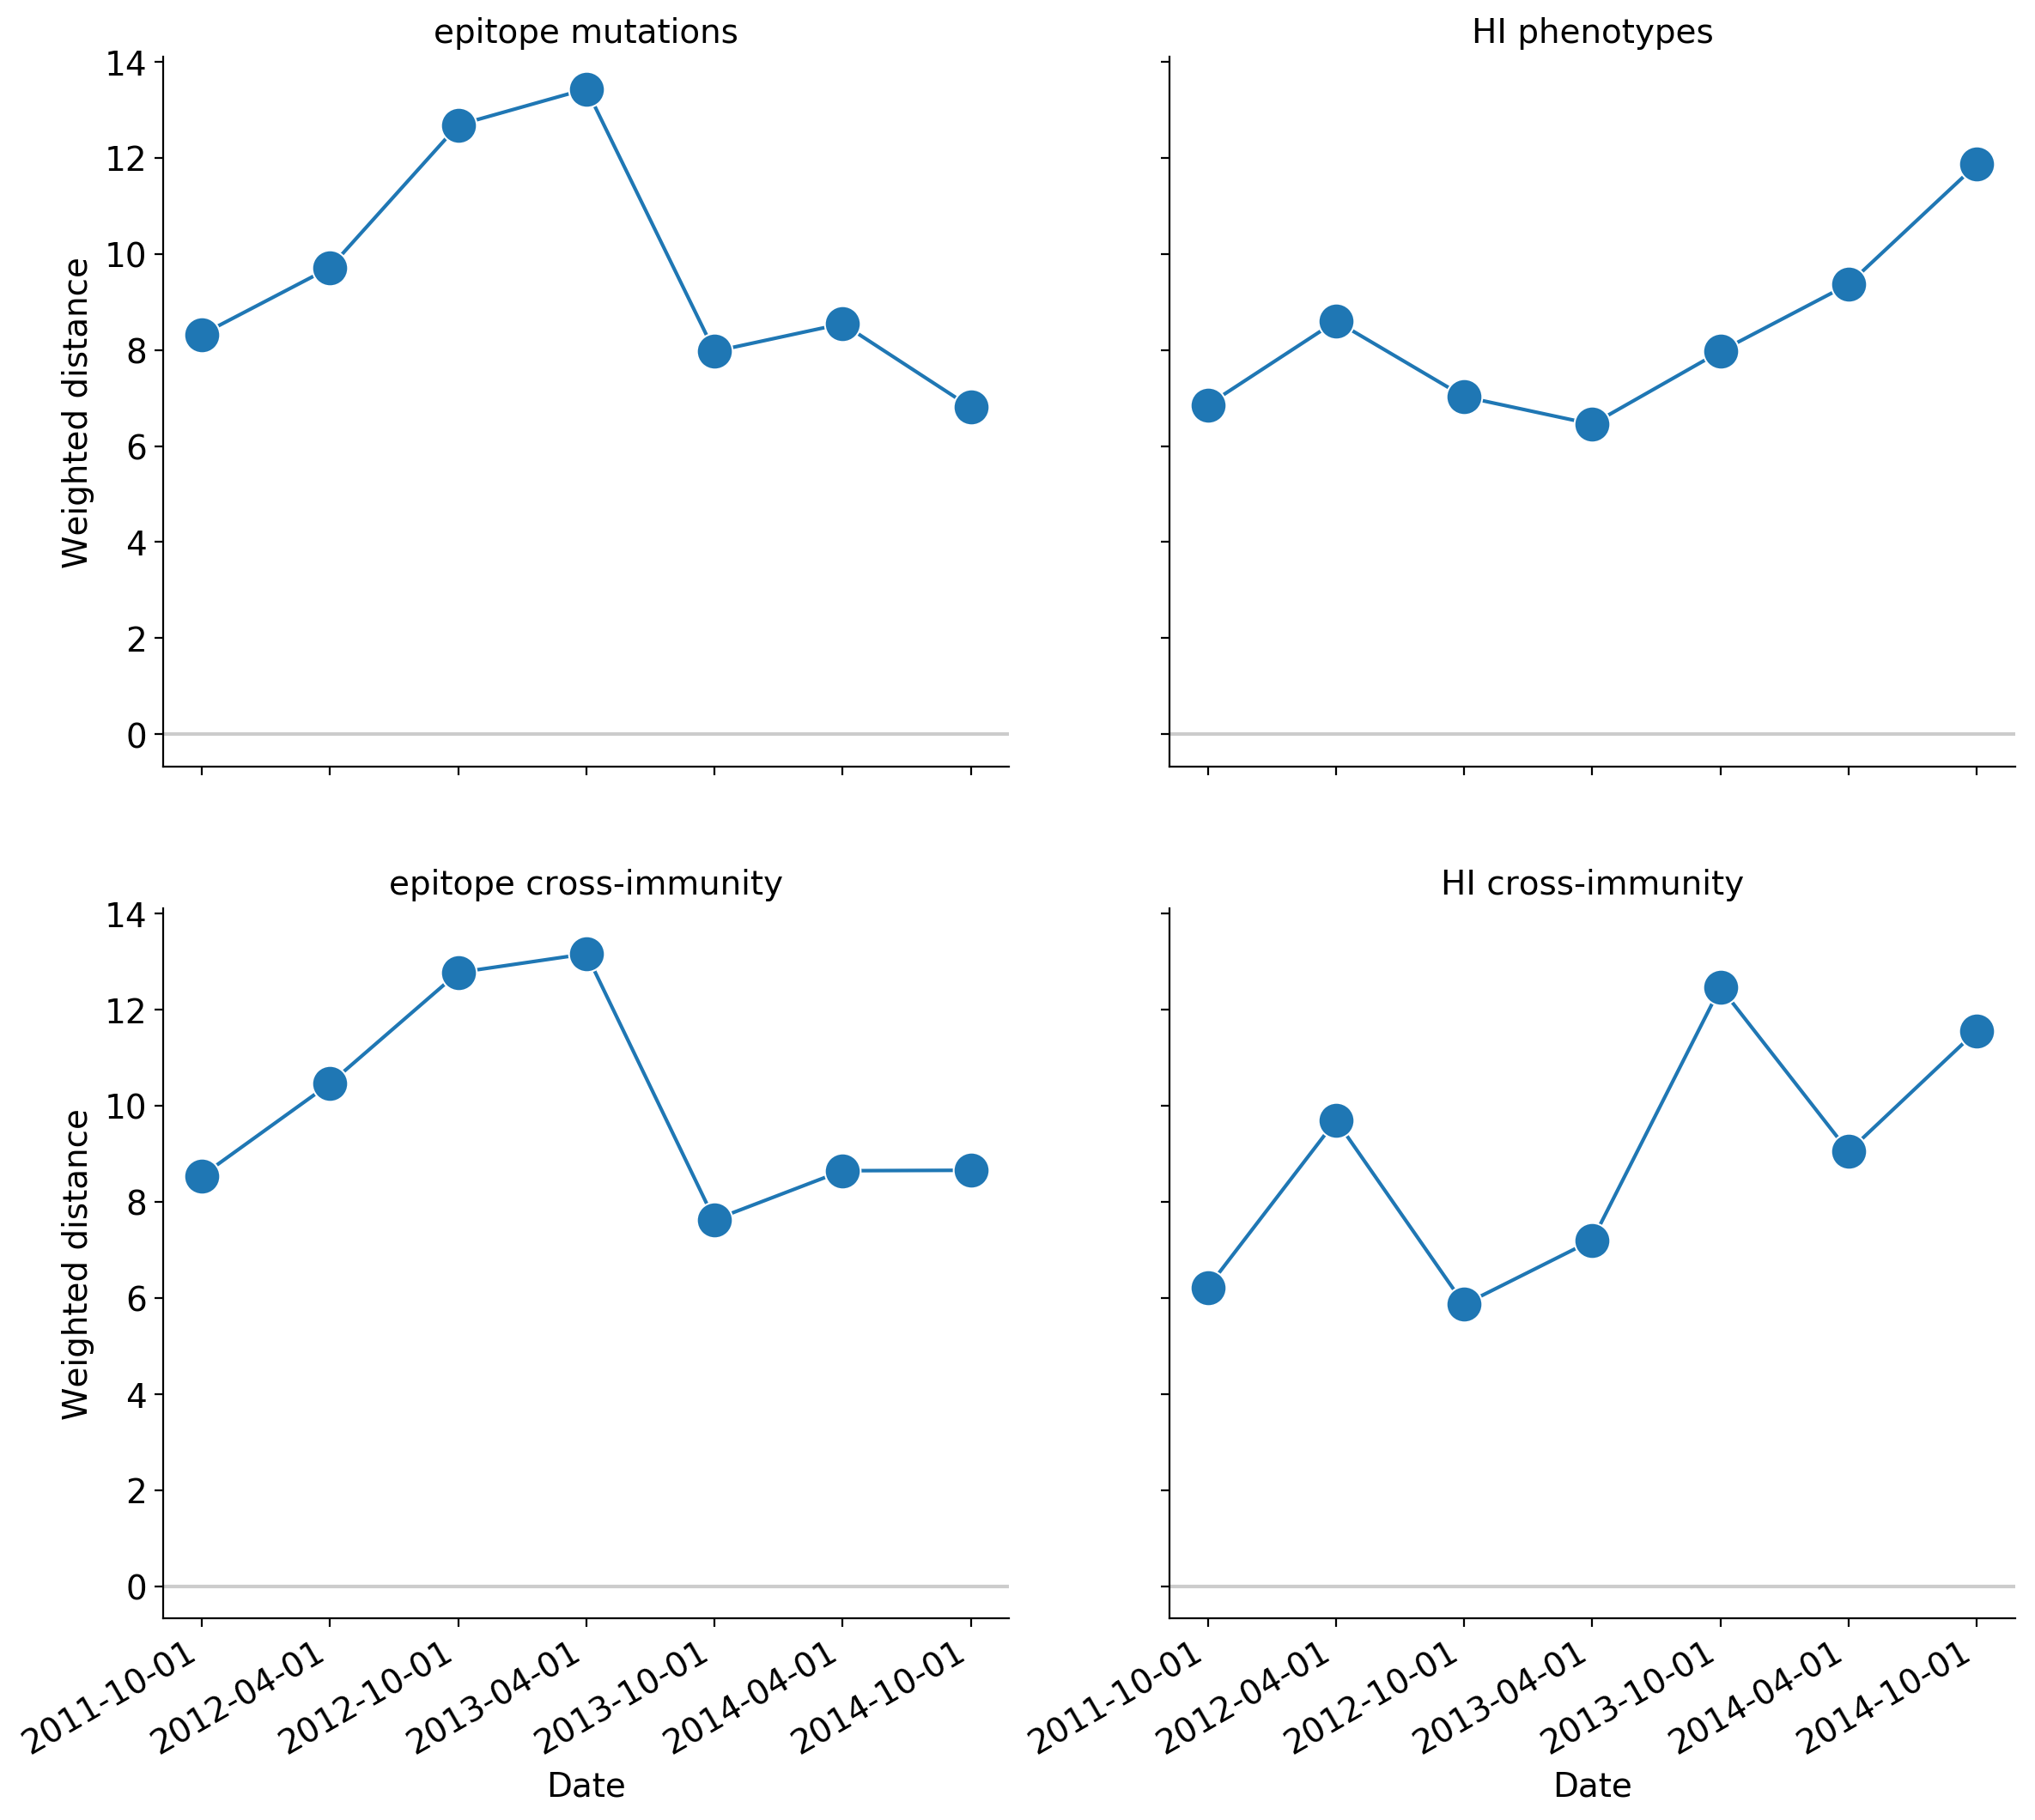

In [360]:
antigenic_predictors = predictor_type_order[1:5]
g = facet_time_plot(
    errors_by_time_df[errors_by_time_df["predictors"].isin(antigenic_predictors)],
    "validation_error",
    "Weighted distance",
    timepoint_column="validation_timepoint",
    predictors_column="predictors_name",
    col_wrap=2,
    height=6,
    aspect=1.,
    col_order=[predictor_name_by_id[predictor] for predictor in antigenic_predictors]
)
g.set_titles("{col_name}")
g.fig.subplots_adjust(hspace=0.2)

In [358]:
predictor_type_order

['naive',
 'ep',
 'cTiterSub',
 'ep_x',
 'cTiterSub_x',
 'ne_star',
 'dms_star',
 'lbi',
 'delta_frequency']

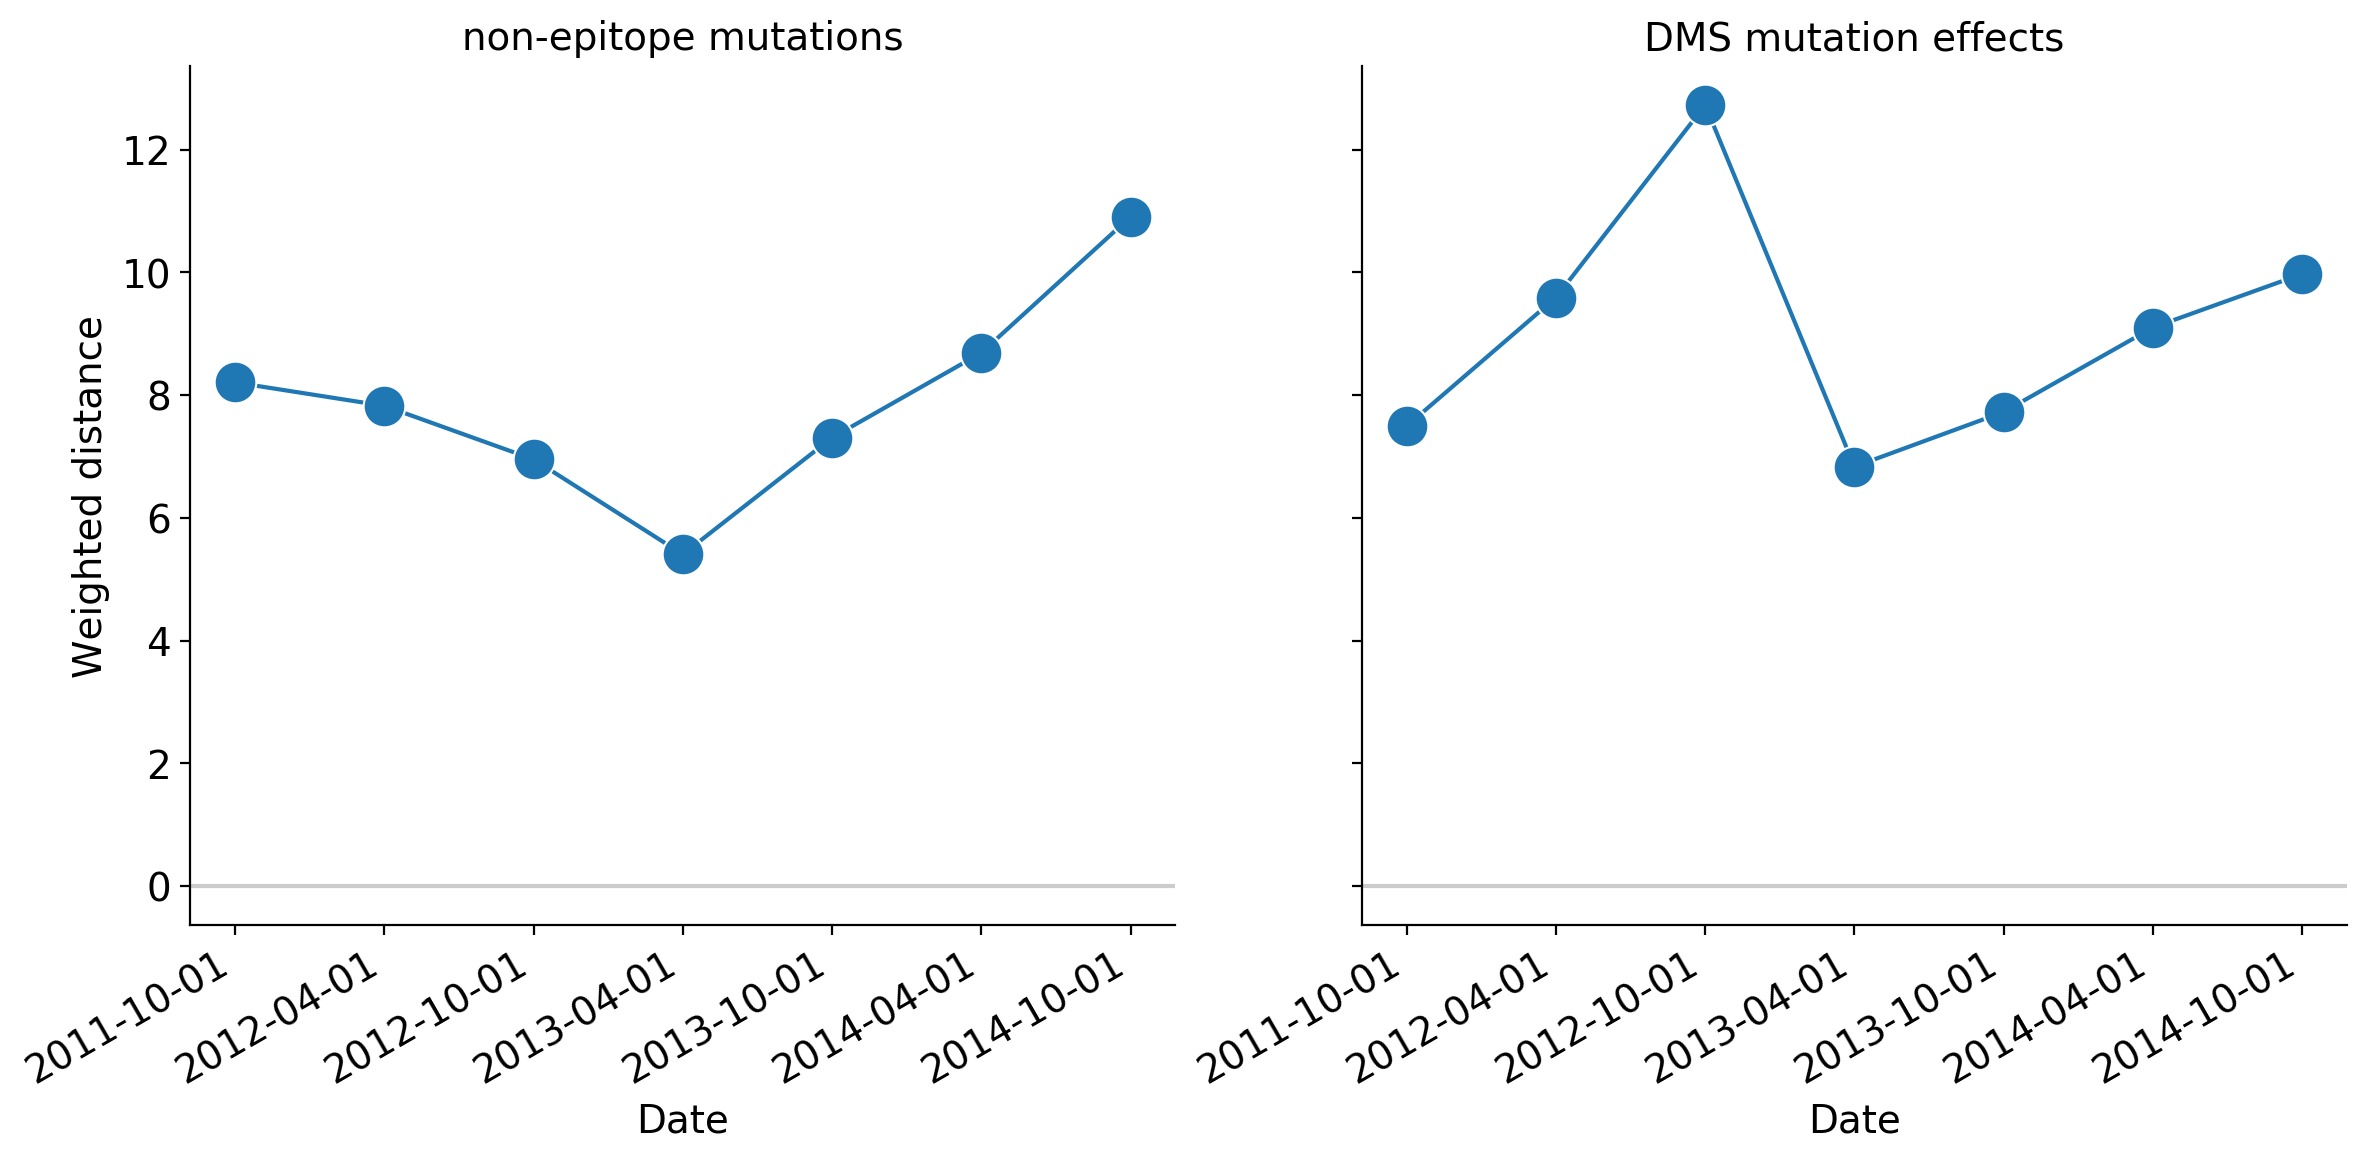

In [361]:
functional_predictors = predictor_type_order[5:7]
g = facet_time_plot(
    errors_by_time_df[errors_by_time_df["predictors"].isin(functional_predictors)],
    "validation_error",
    "Weighted distance",
    timepoint_column="validation_timepoint",
    predictors_column="predictors_name",
    col_wrap=2,
    height=6,
    aspect=1.,
    col_order=[predictor_name_by_id[predictor] for predictor in functional_predictors]
)
g.set_titles("{col_name}")
g.fig.subplots_adjust(hspace=0.2)


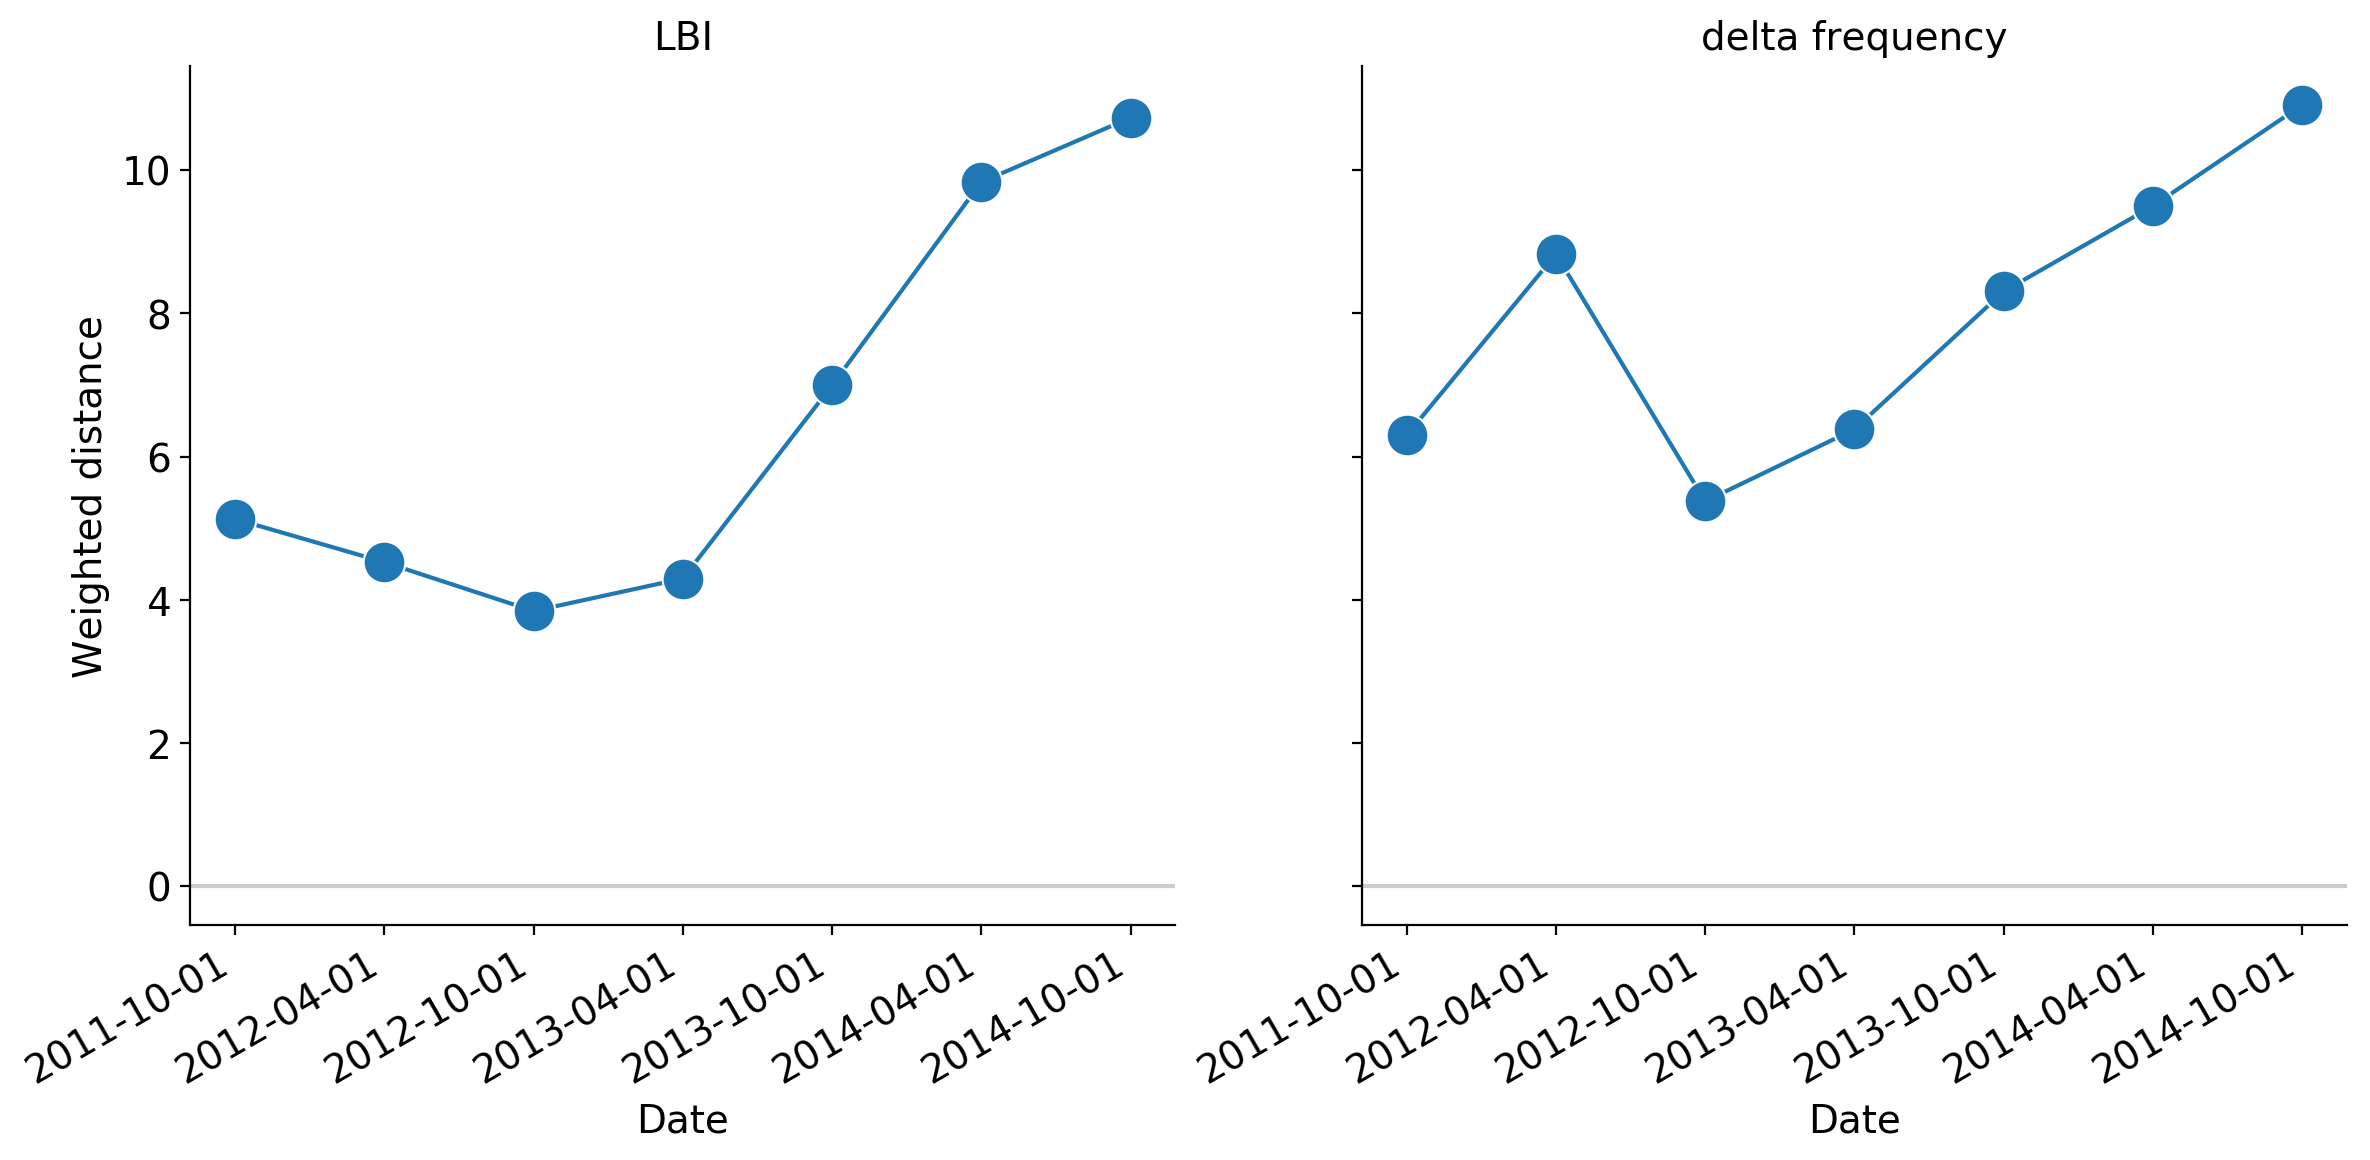

In [362]:
growth_predictors = predictor_type_order[7:]
g = facet_time_plot(
    errors_by_time_df[errors_by_time_df["predictors"].isin(growth_predictors)],
    "validation_error",
    "Weighted distance",
    timepoint_column="validation_timepoint",
    predictors_column="predictors_name",
    col_wrap=2,
    height=6,
    aspect=1.,
    col_order=[predictor_name_by_id[predictor] for predictor in growth_predictors]
)
g.set_titles("{col_name}")
g.fig.subplots_adjust(hspace=0.2)

In [363]:
errors_by_time_df["predictors"].unique()

array(['dms_star', 'ep', 'lbi', 'ne_star', 'delta_frequency',
       'cTiterSub_x', 'ep_x', 'naive', 'cTiterSub'], dtype=object)

In [364]:
errors_by_time_df[errors_by_time_df["predictors"] == "naive"]

predictors  validation_error  validation_n validation_timepoint  \
49      naive          7.715725            39           2011-10-01   
50      naive          9.378652            45           2012-04-01   
51      naive          8.402123            40           2012-10-01   
52      naive          6.791494            43           2013-04-01   
53      naive          8.084953            42           2013-10-01   
54      naive          9.423493            49           2014-04-01   
55      naive          9.805478            48           2014-10-01   

   predictors_name  
49            null  
50            null  
51            null  
52            null  
53            null  
54            null  
55            null

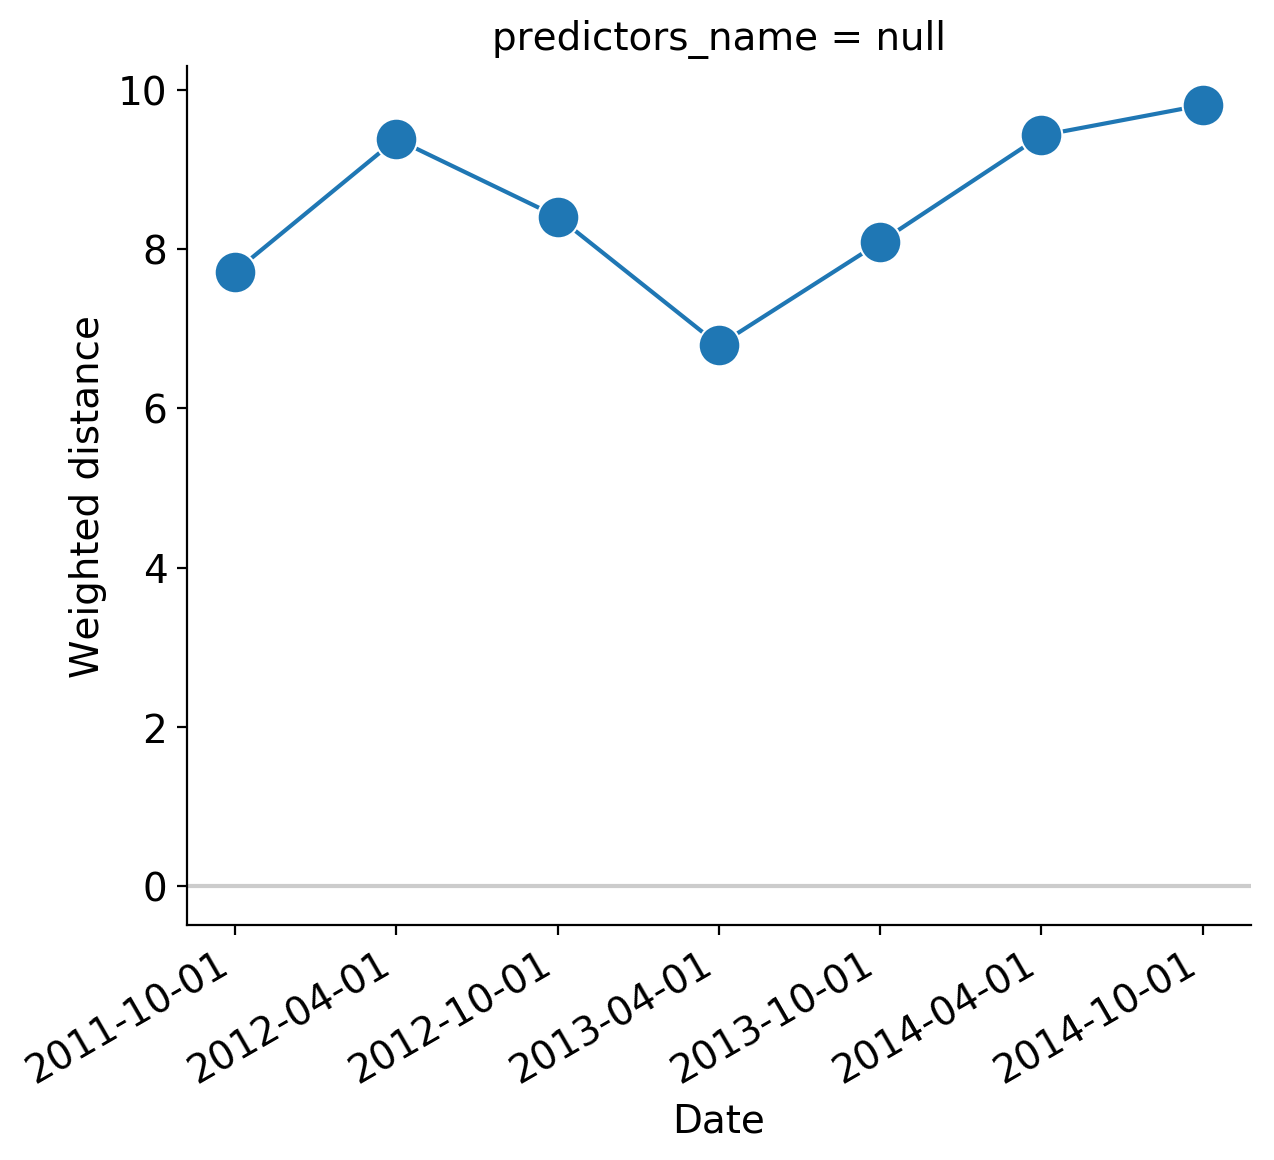

In [365]:
g = facet_time_plot(
    errors_by_time_df[errors_by_time_df["predictors"] == "naive"],
    "validation_error",
    "Weighted distance",
    timepoint_column="validation_timepoint",
    predictors_column="predictors_name",
    height=6,
    aspect=1
)
#g.set_titles("{col_name}")
#g.fig.subplots_adjust(hspace=0.2)

In [366]:
errors_by_time_df.head()

predictors  validation_error  validation_n validation_timepoint  \
0   dms_star          7.497649            39           2011-10-01   
1   dms_star          9.591969            45           2012-04-01   
2   dms_star         12.728299            40           2012-10-01   
3   dms_star          6.835143            43           2013-04-01   
4   dms_star          7.727647            42           2013-10-01   

        predictors_name  
0  DMS mutation effects  
1  DMS mutation effects  
2  DMS mutation effects  
3  DMS mutation effects  
4  DMS mutation effects

In [430]:
naive_error = errors_by_time_df[errors_by_time_df["predictors"] == "naive"]["validation_error"].values
for predictor in errors_by_time_df["predictors"].drop_duplicates().values:
    errors_by_time_df.loc[errors_by_time_df["predictors"] == predictor, "adjusted_error"] = errors_by_time_df.loc[errors_by_time_df["predictors"] == predictor, "validation_error"] - naive_error

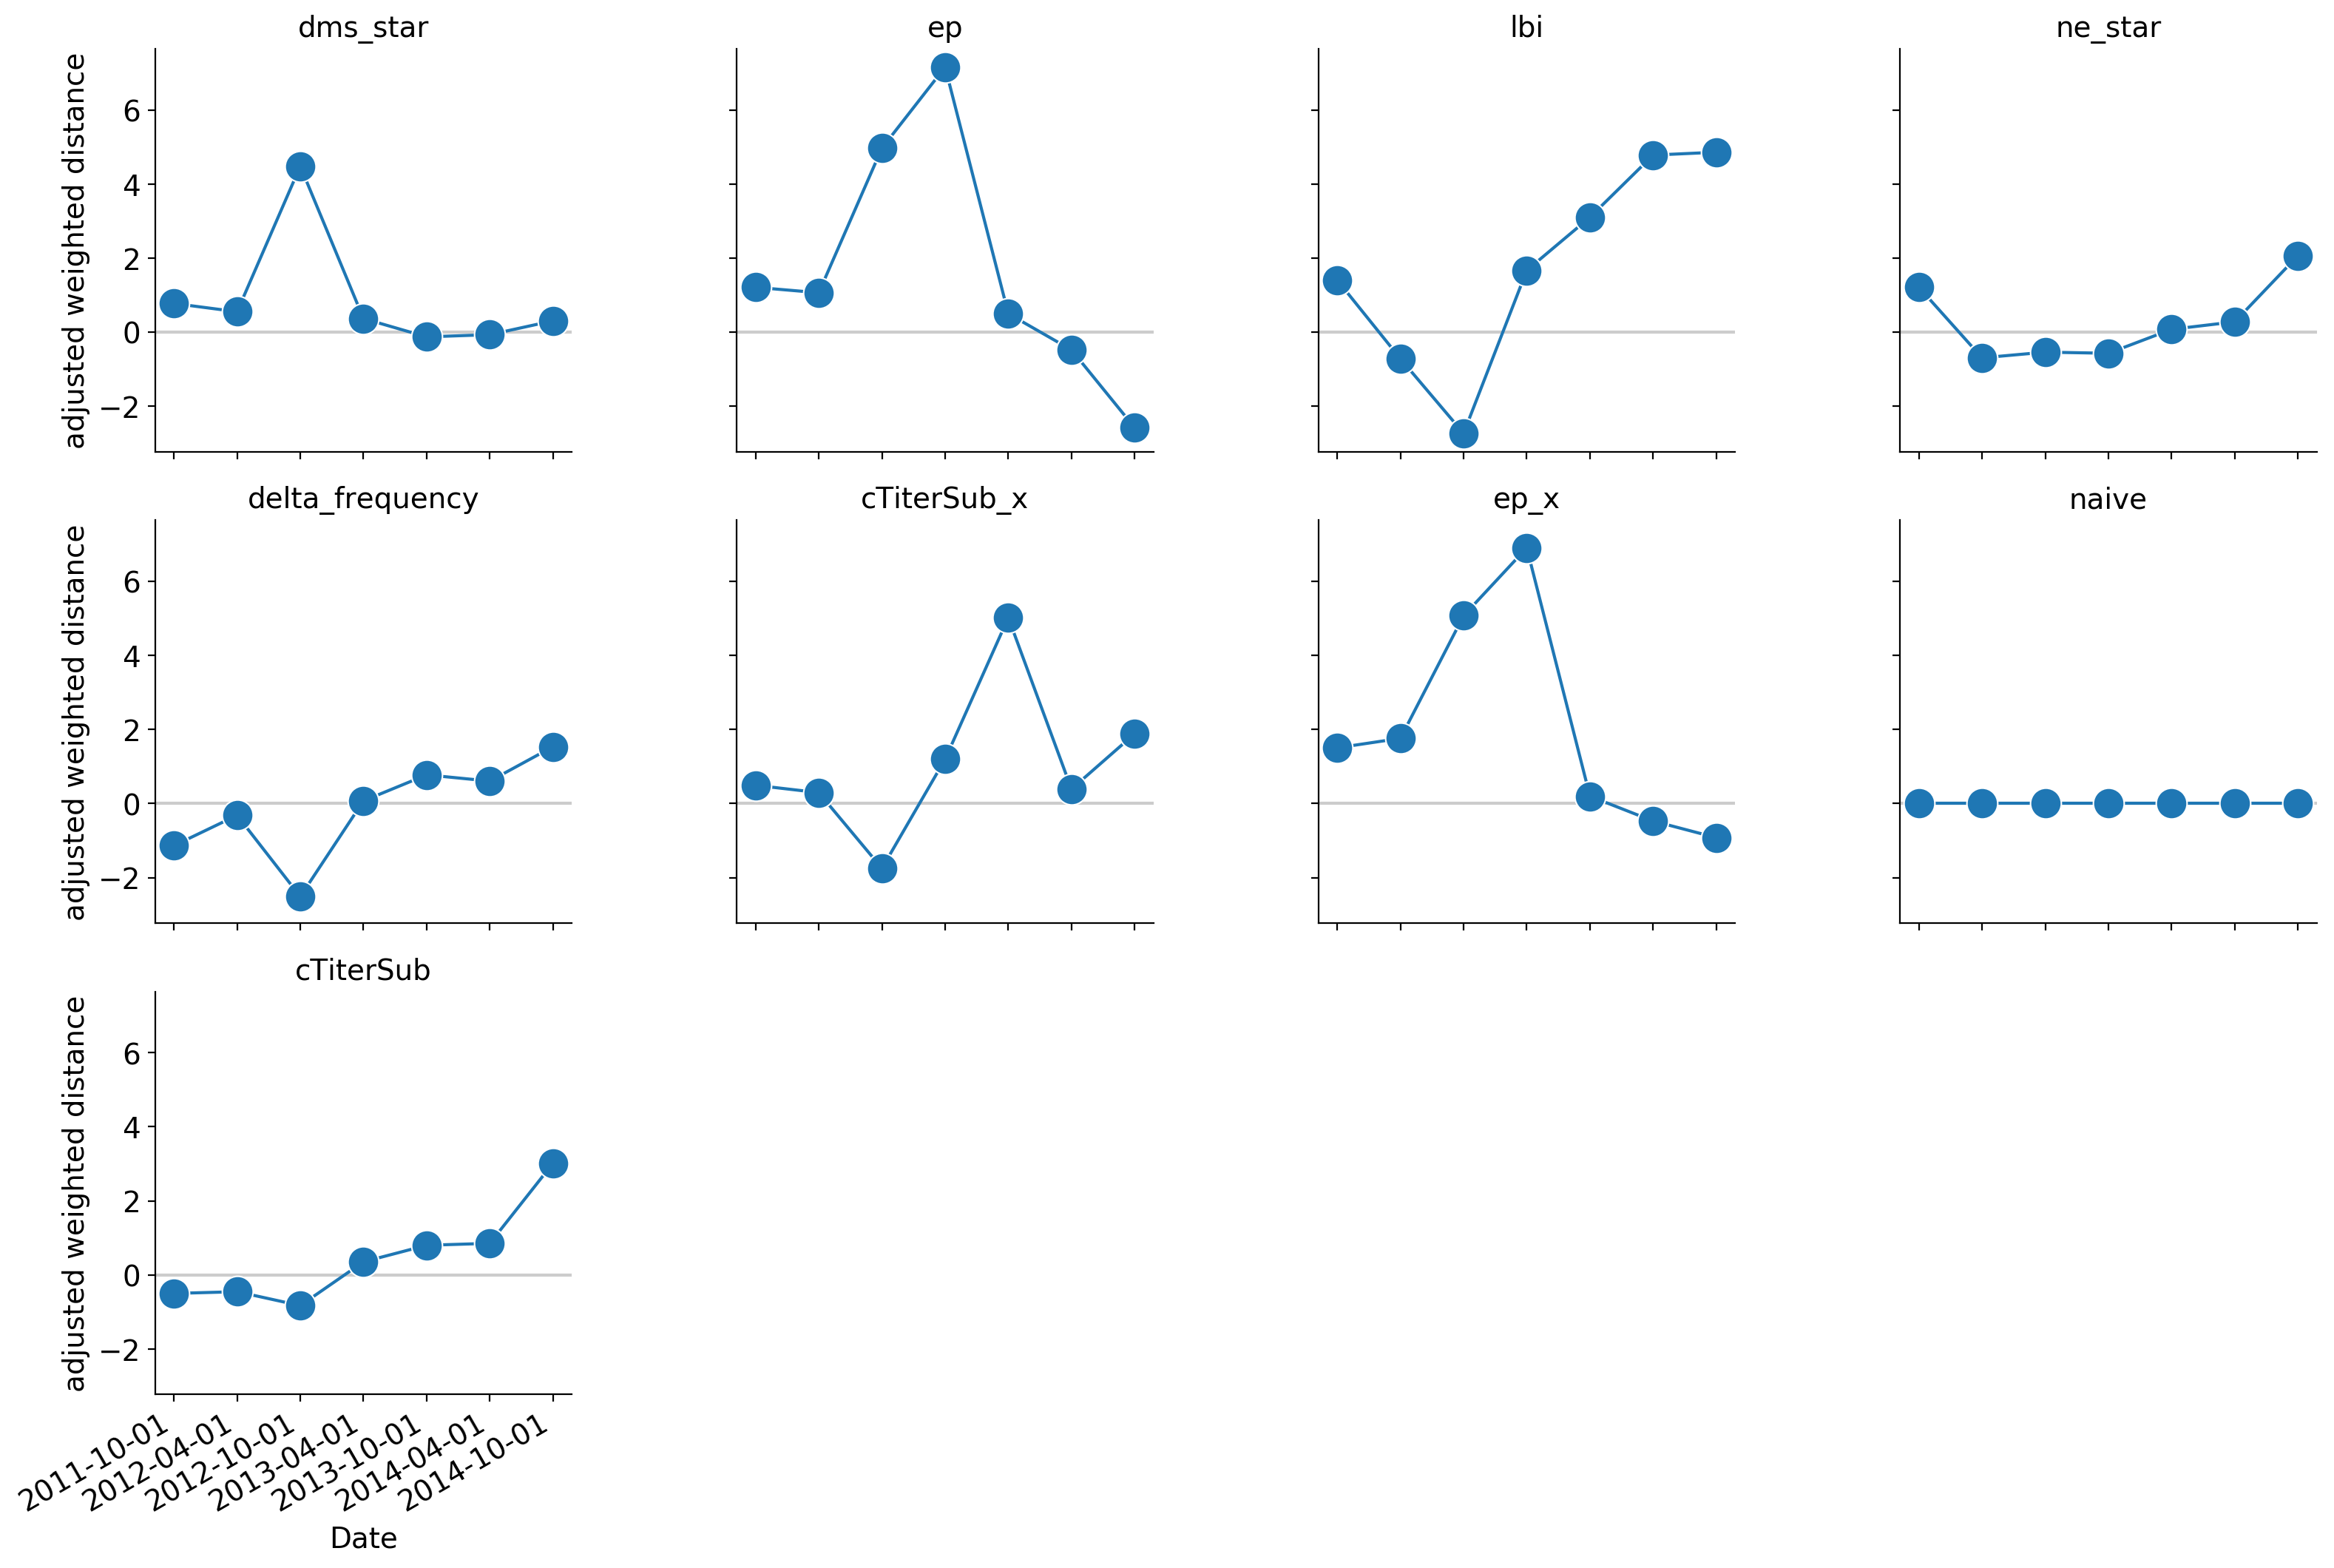

In [431]:
g = facet_time_plot(errors_by_time_df, "adjusted_error", "adjusted weighted distance", timepoint_column="validation_timepoint")
g.set_titles("{col_name}")

## Summarize model coefficients

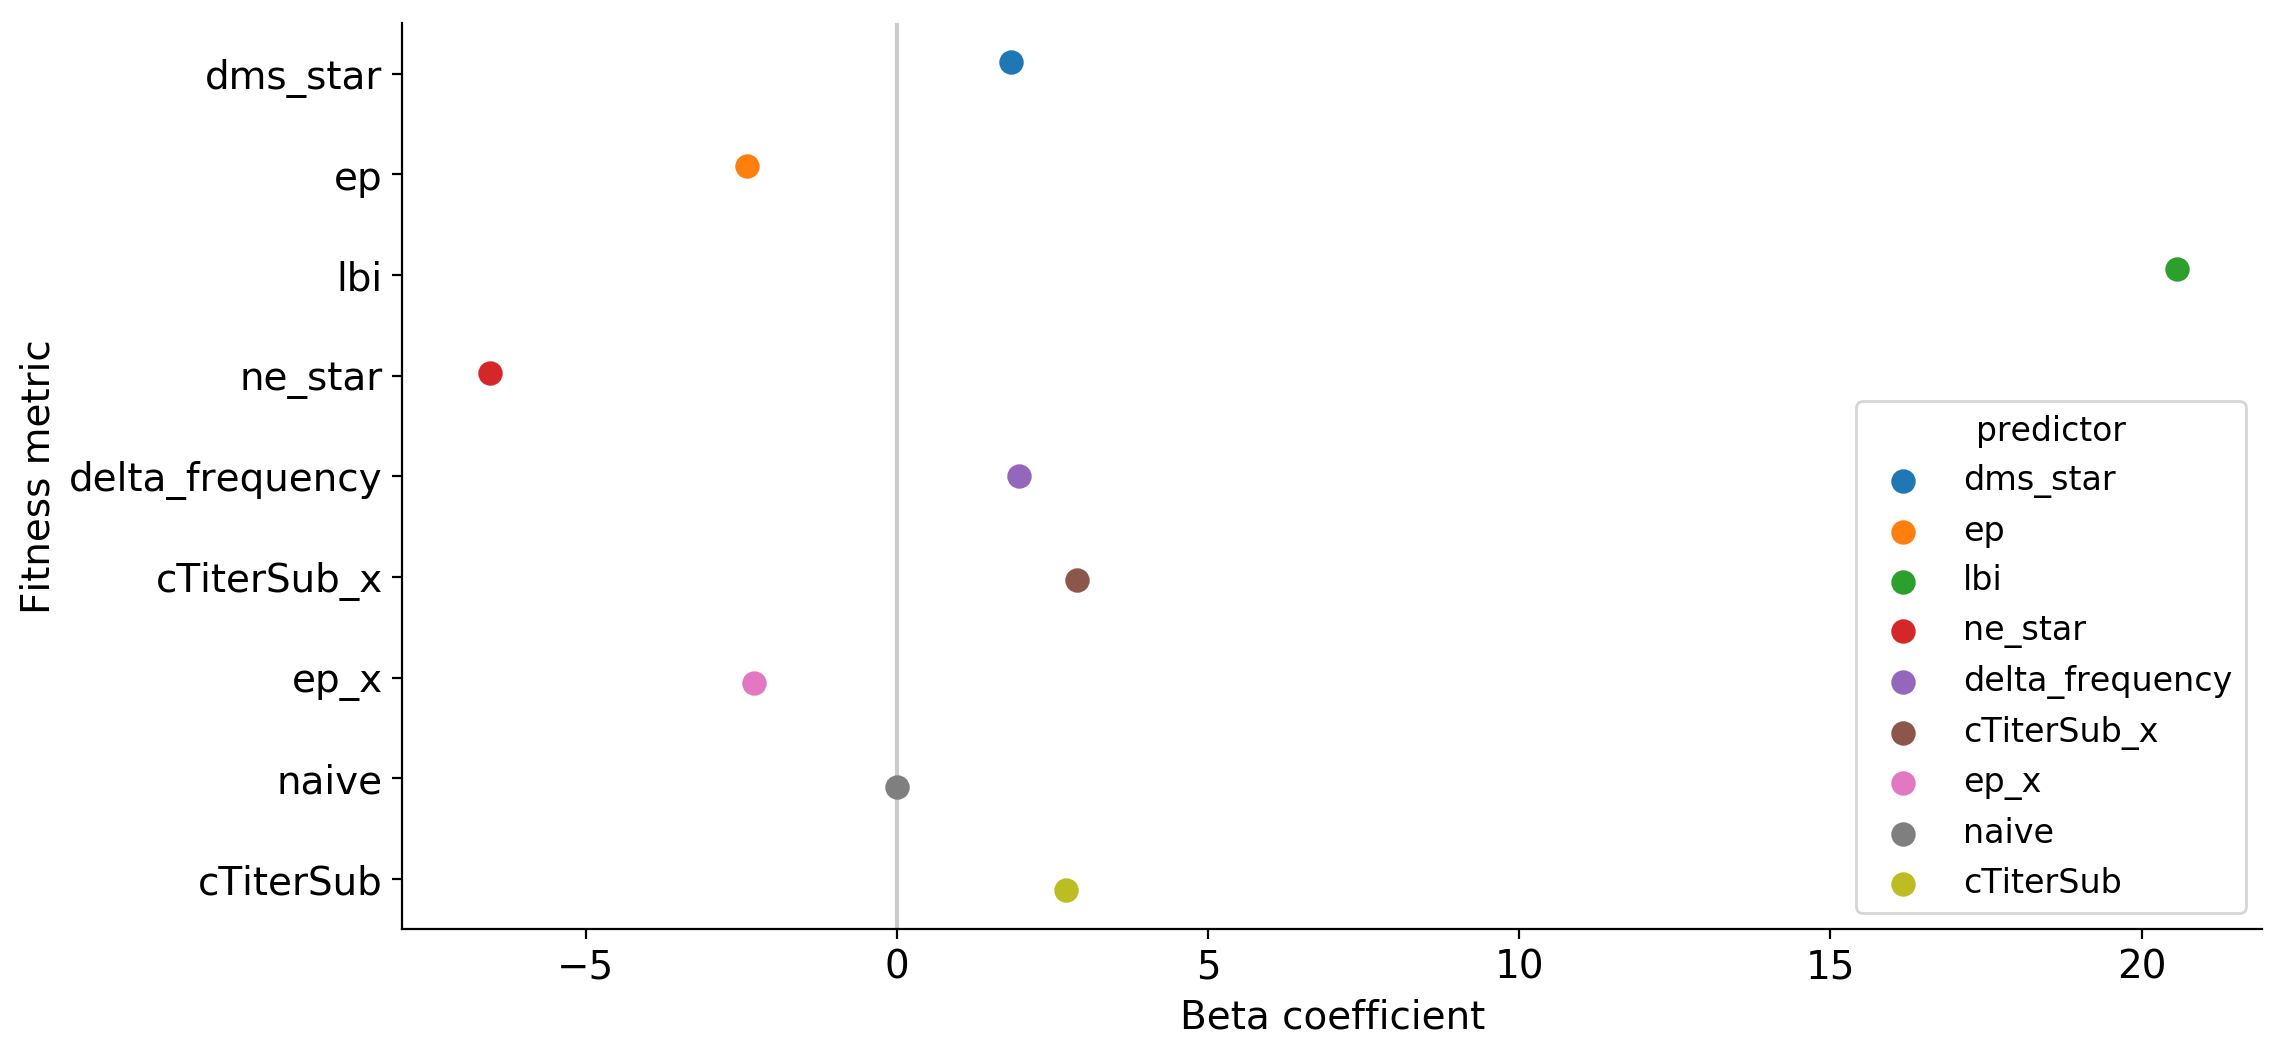

In [463]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.pointplot(
    y="predictors",
    x="mean",
    hue="predictor",
    data=overall_coefficients_df,
    ax=ax,
    dodge=True,
    join=False
    #order=predictor_names_order
)

ax.axvline(0, color="#999999", alpha=0.5, zorder=-10)
ax.set_xlabel("Beta coefficient")
ax.set_ylabel("Fitness metric")

sns.despine()

In [464]:
overall_coefficients_df

mean        predictor       predictors       std
0   1.828168         dms_star         dms_star  1.488160
1  -2.404096               ep               ep  0.753251
2  20.570058              lbi              lbi  1.700058
3  -6.545179          ne_star          ne_star  0.421843
4   1.958918  delta_frequency  delta_frequency  0.887846
5   2.899742      cTiterSub_x      cTiterSub_x  1.309082
6  -2.290477             ep_x             ep_x  0.848424
7   0.000000            naive            naive  0.000000
8   2.716152        cTiterSub        cTiterSub  1.702696

In [465]:
coefficients_by_time_df.head()

coefficient predictor predictors validation_timepoint
0     5.338180  dms_star   dms_star           2011-10-01
1     1.771589  dms_star   dms_star           2012-04-01
2     1.704155  dms_star   dms_star           2012-10-01
3     1.437884  dms_star   dms_star           2013-04-01
4     0.962348  dms_star   dms_star           2013-10-01

In [466]:
coefficients_by_time_df.tail()

coefficient  predictor predictors validation_timepoint
58     1.171695  cTiterSub  cTiterSub           2012-10-01
59     3.310583  cTiterSub  cTiterSub           2013-04-01
60     4.315956  cTiterSub  cTiterSub           2013-10-01
61     4.385423  cTiterSub  cTiterSub           2014-04-01
62     4.575191  cTiterSub  cTiterSub           2014-10-01

In [467]:
coefficients_by_time_df["predictors_name"] = coefficients_by_time_df["predictors"].map(predictor_name_by_id)

In [468]:
coefficients_by_time_df.loc[pd.isnull(coefficients_by_time_df["predictors_name"]), "predictors_name"] = coefficients_by_time_df.loc[
    pd.isnull(coefficients_by_time_df["predictors_name"]), "predictors"
]

In [469]:
coefficients_by_time_df["predictors_name"].unique().shape

(9,)

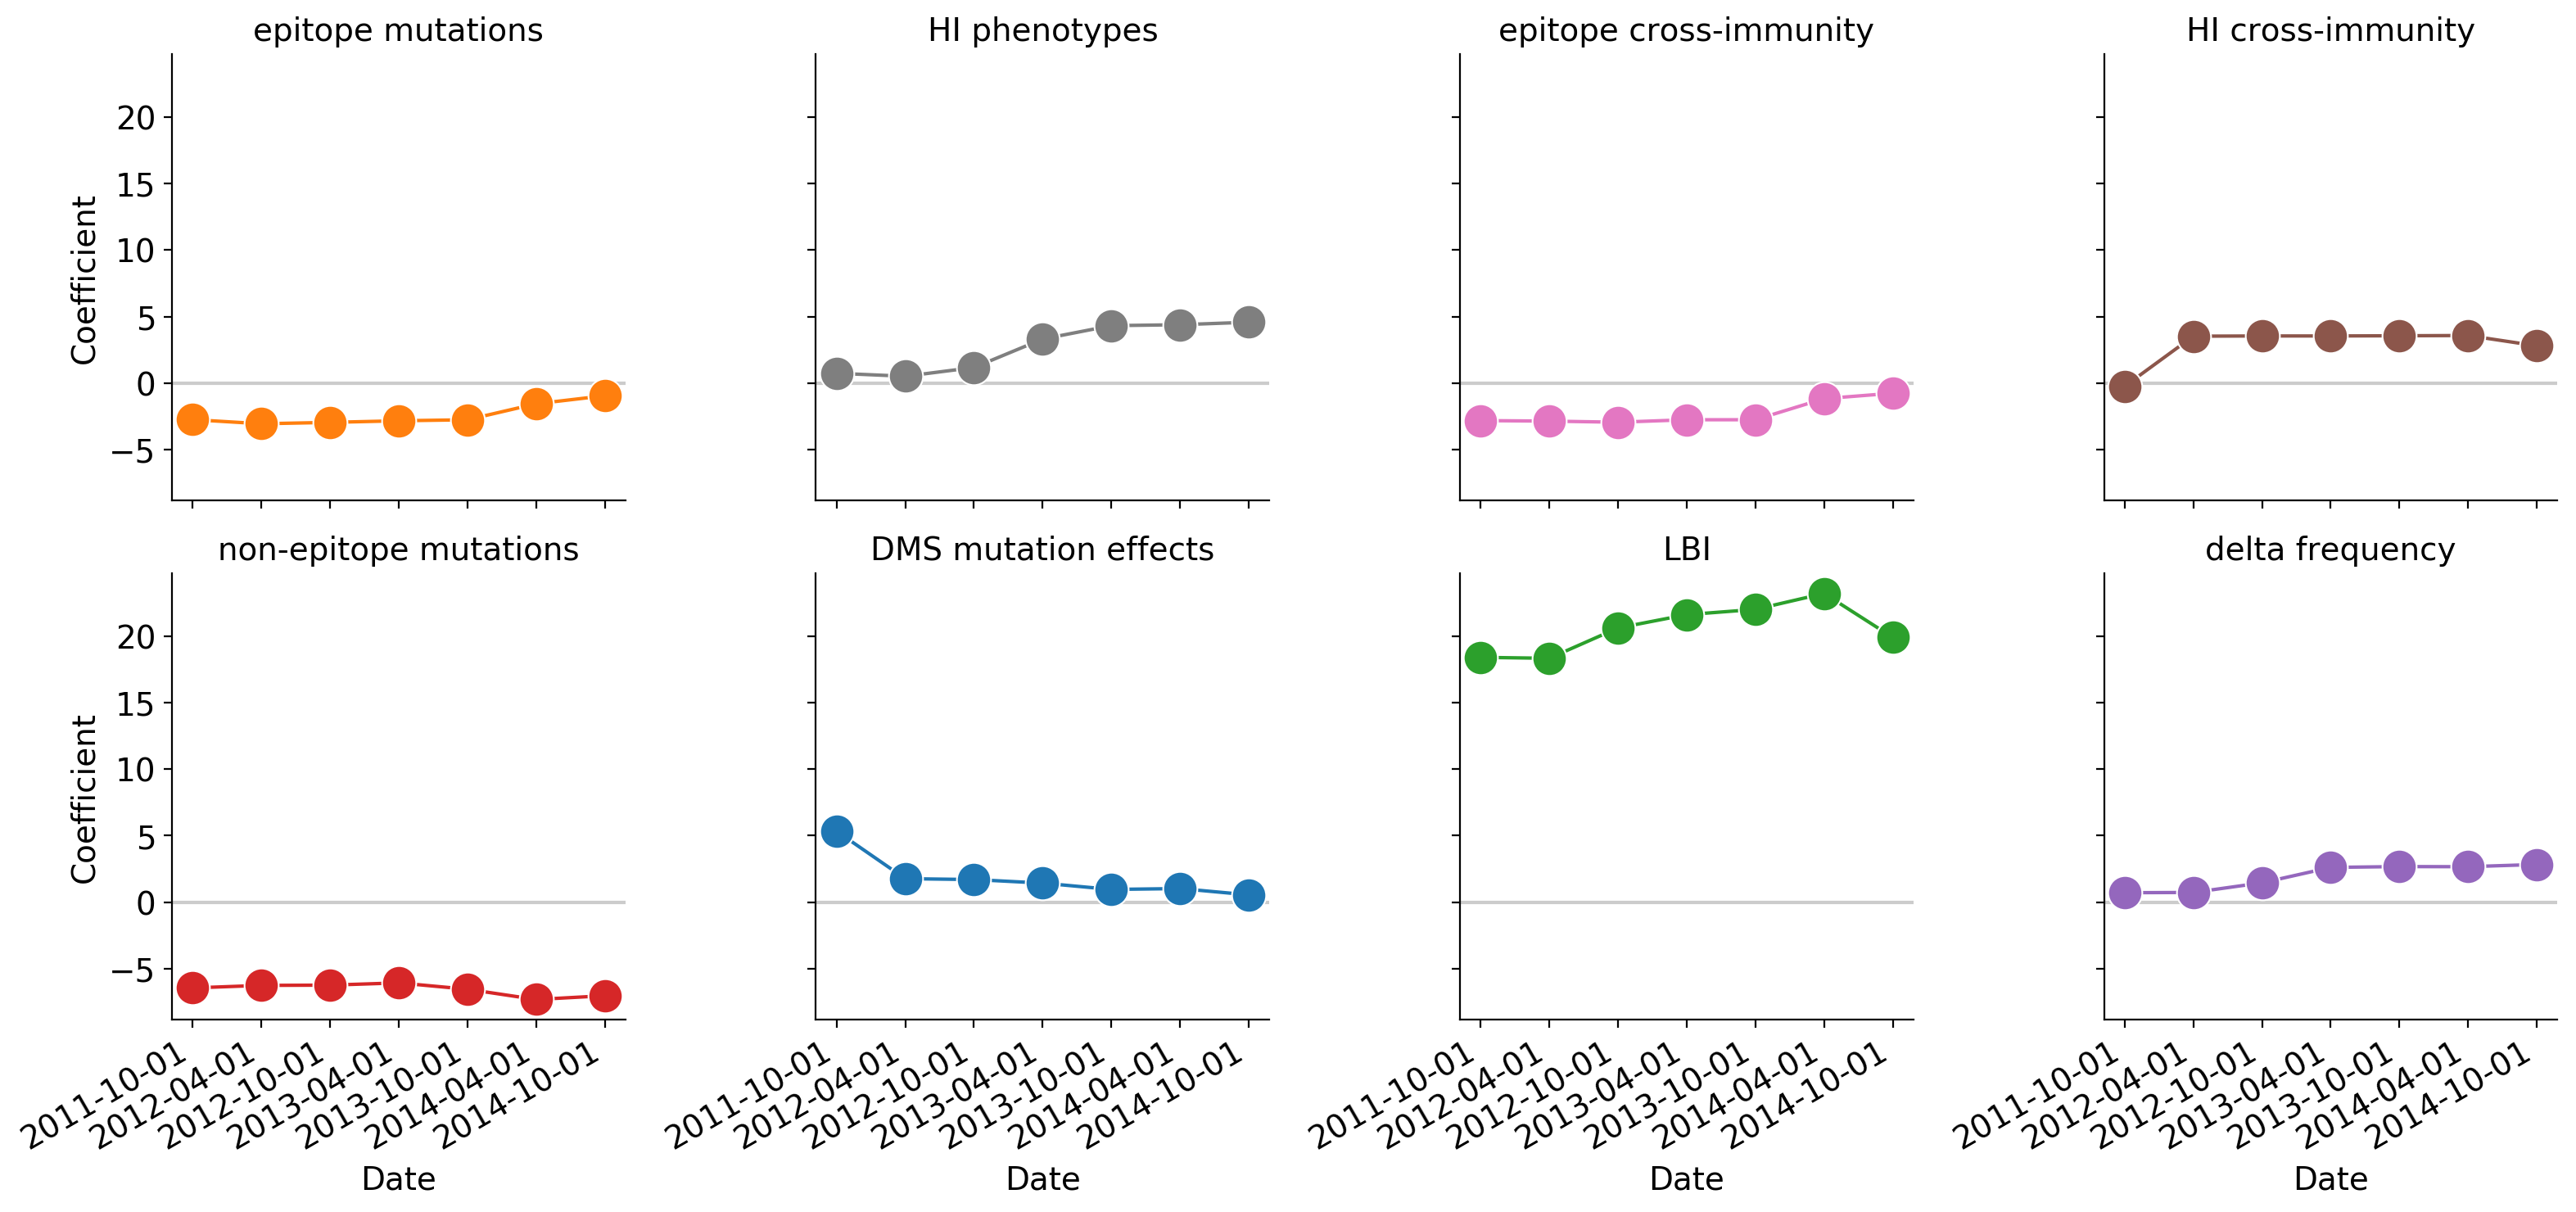

In [470]:
g = facet_time_plot(
    coefficients_by_time_df[coefficients_by_time_df["predictors"] != "naive"],
    "coefficient",
    "Coefficient",
    timepoint_column="validation_timepoint",
    predictors_column="predictors_name",
    col_order=[predictor_name_by_id[predictor] for predictor in predictor_type_order[1:]],
    hue="predictor"
)
g.set_titles("{col_name}")

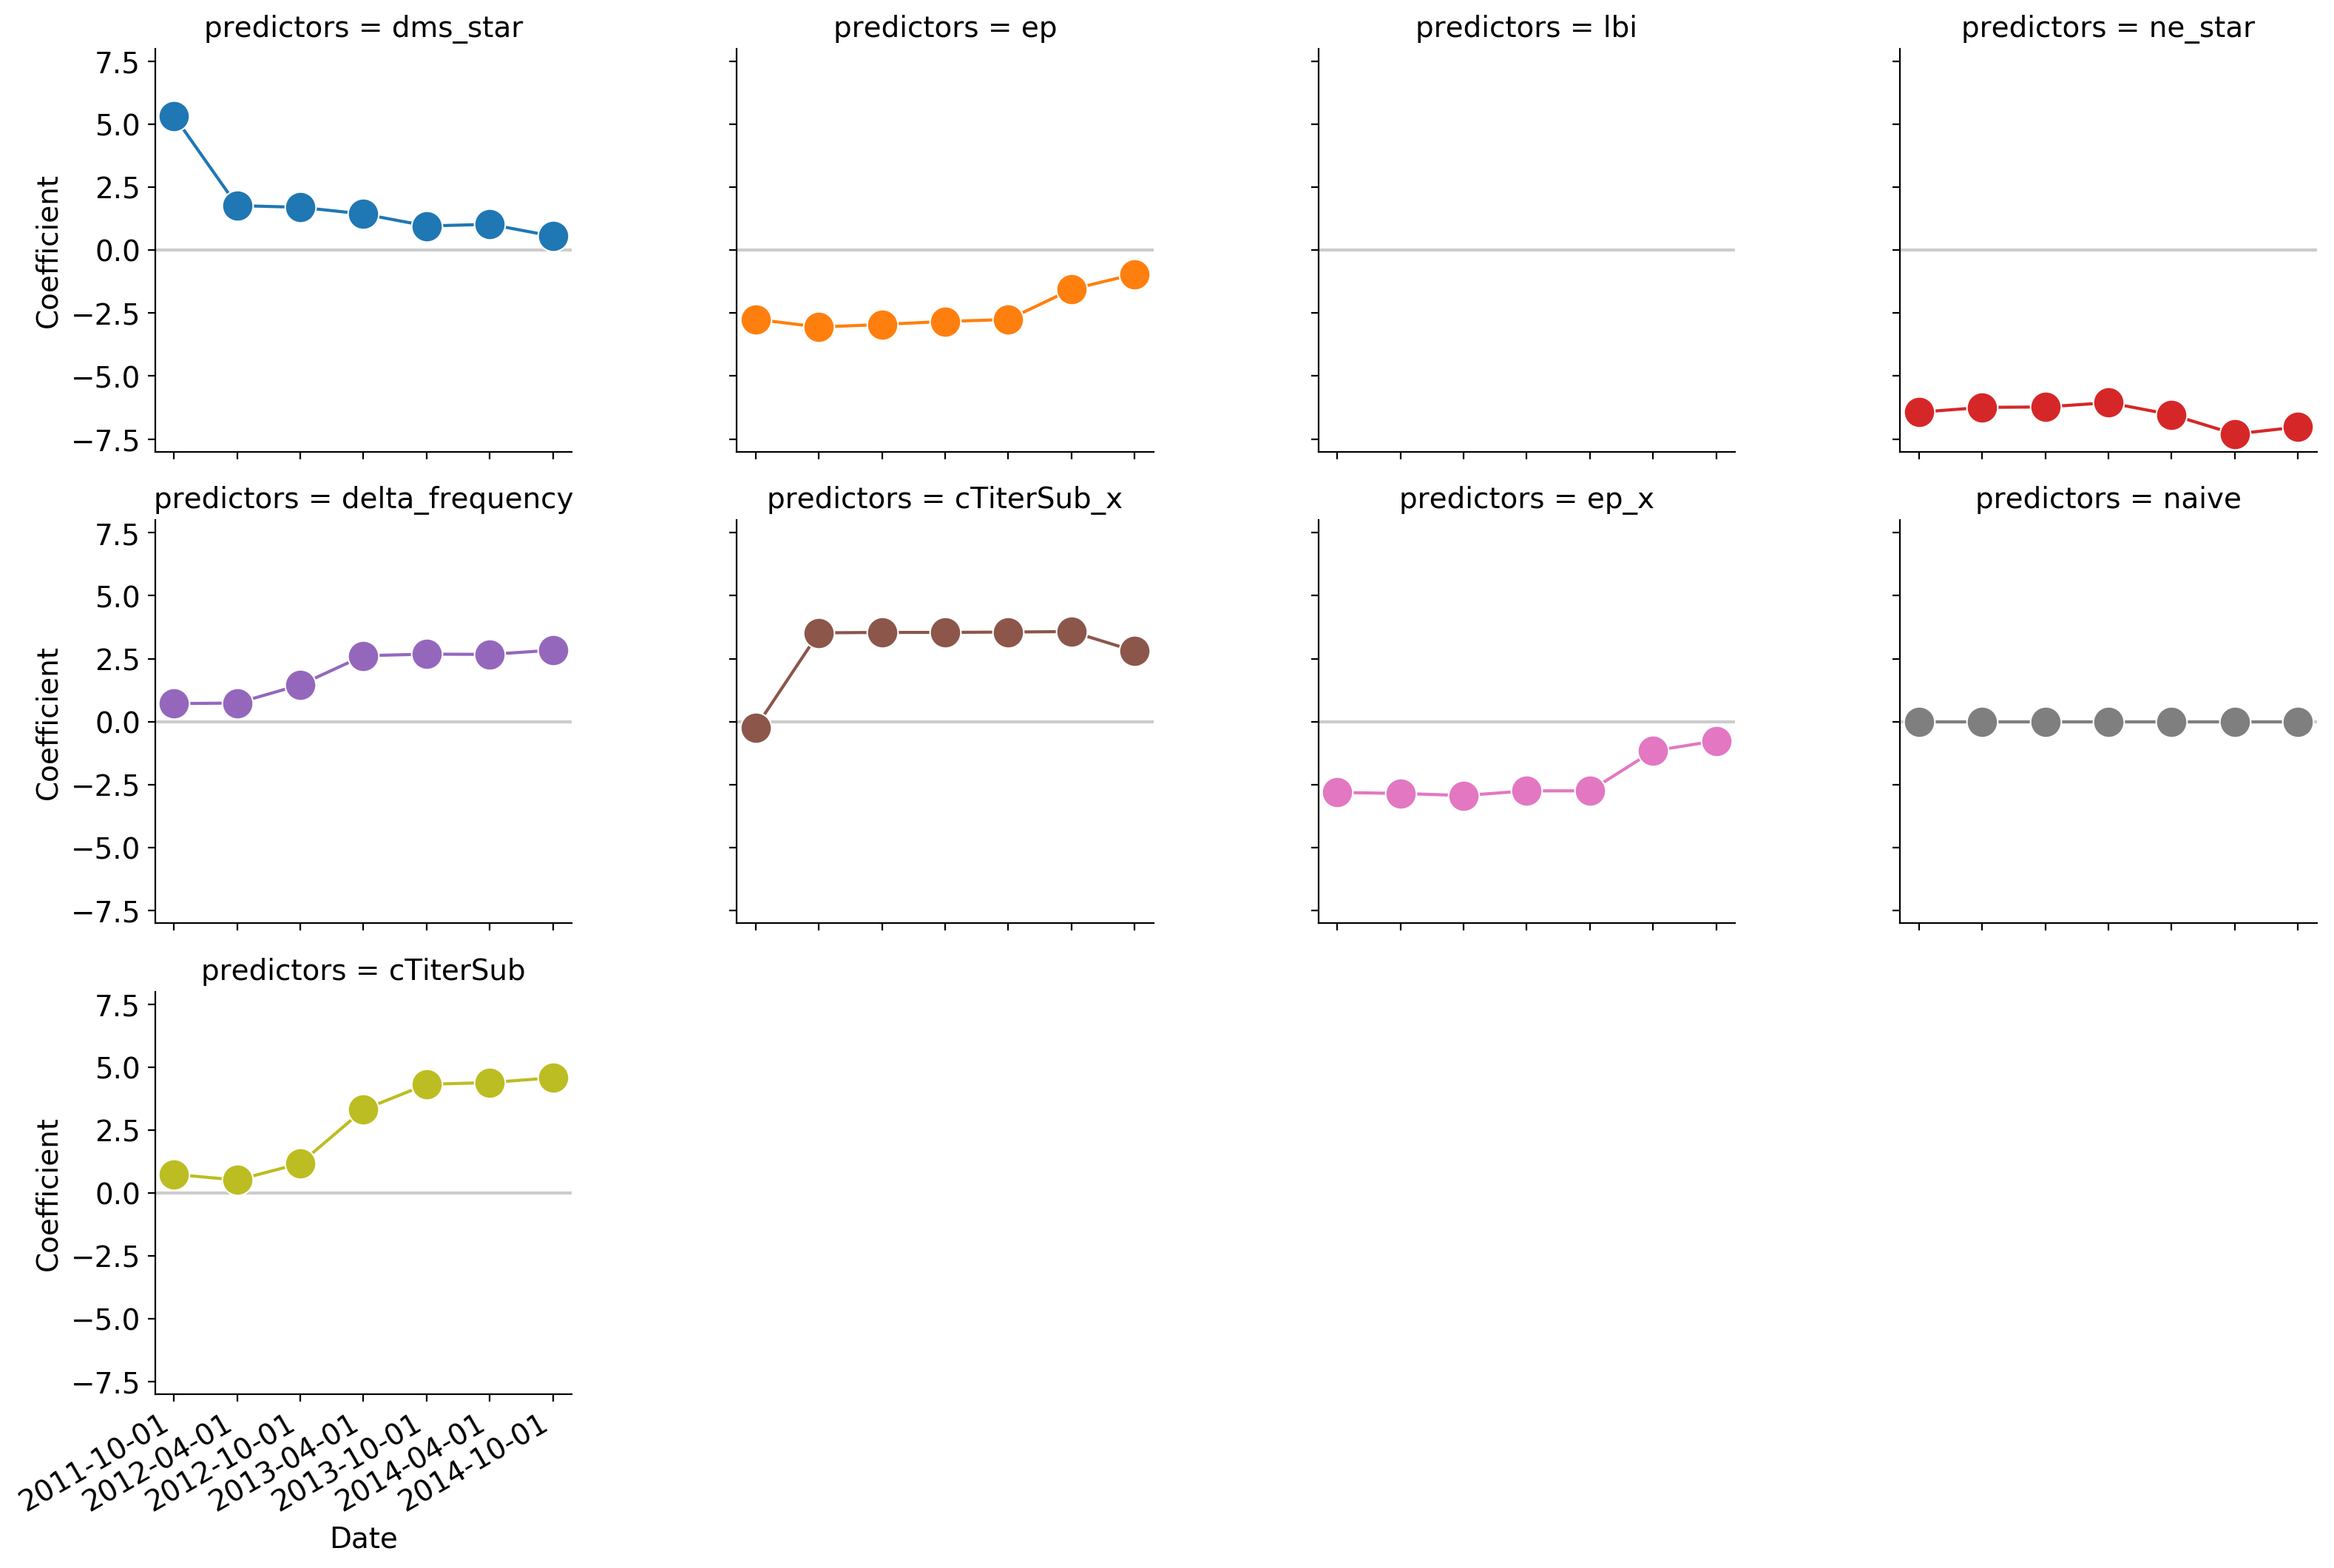

In [473]:
g = facet_time_plot(coefficients_by_time_df, "coefficient", "Coefficient", timepoint_column="validation_timepoint", hue="predictor")

for ax in g.axes.flatten():
    ax.set_ylim(-8, 8)

In [474]:
print(coefficients_by_time_df.loc[coefficients_by_time_df["predictors"] == "ep", ["validation_timepoint", "coefficient"]])

   validation_timepoint  coefficient
7            2011-10-01    -2.741597
8            2012-04-01    -3.052777
9            2012-10-01    -2.949571
10           2013-04-01    -2.828358
11           2013-10-01    -2.752686
12           2014-04-01    -1.553981
13           2014-10-01    -0.949703


In [380]:
composite_predictors_order

['lbi',
 'delta_frequency',
 'cTiterSub_x',
 'lbi-delta_frequency',
 'lbi-cTiterSub_x',
 'lbi-dms_star-cTiterSub_x',
 'lbi-ep_x-ne_star']

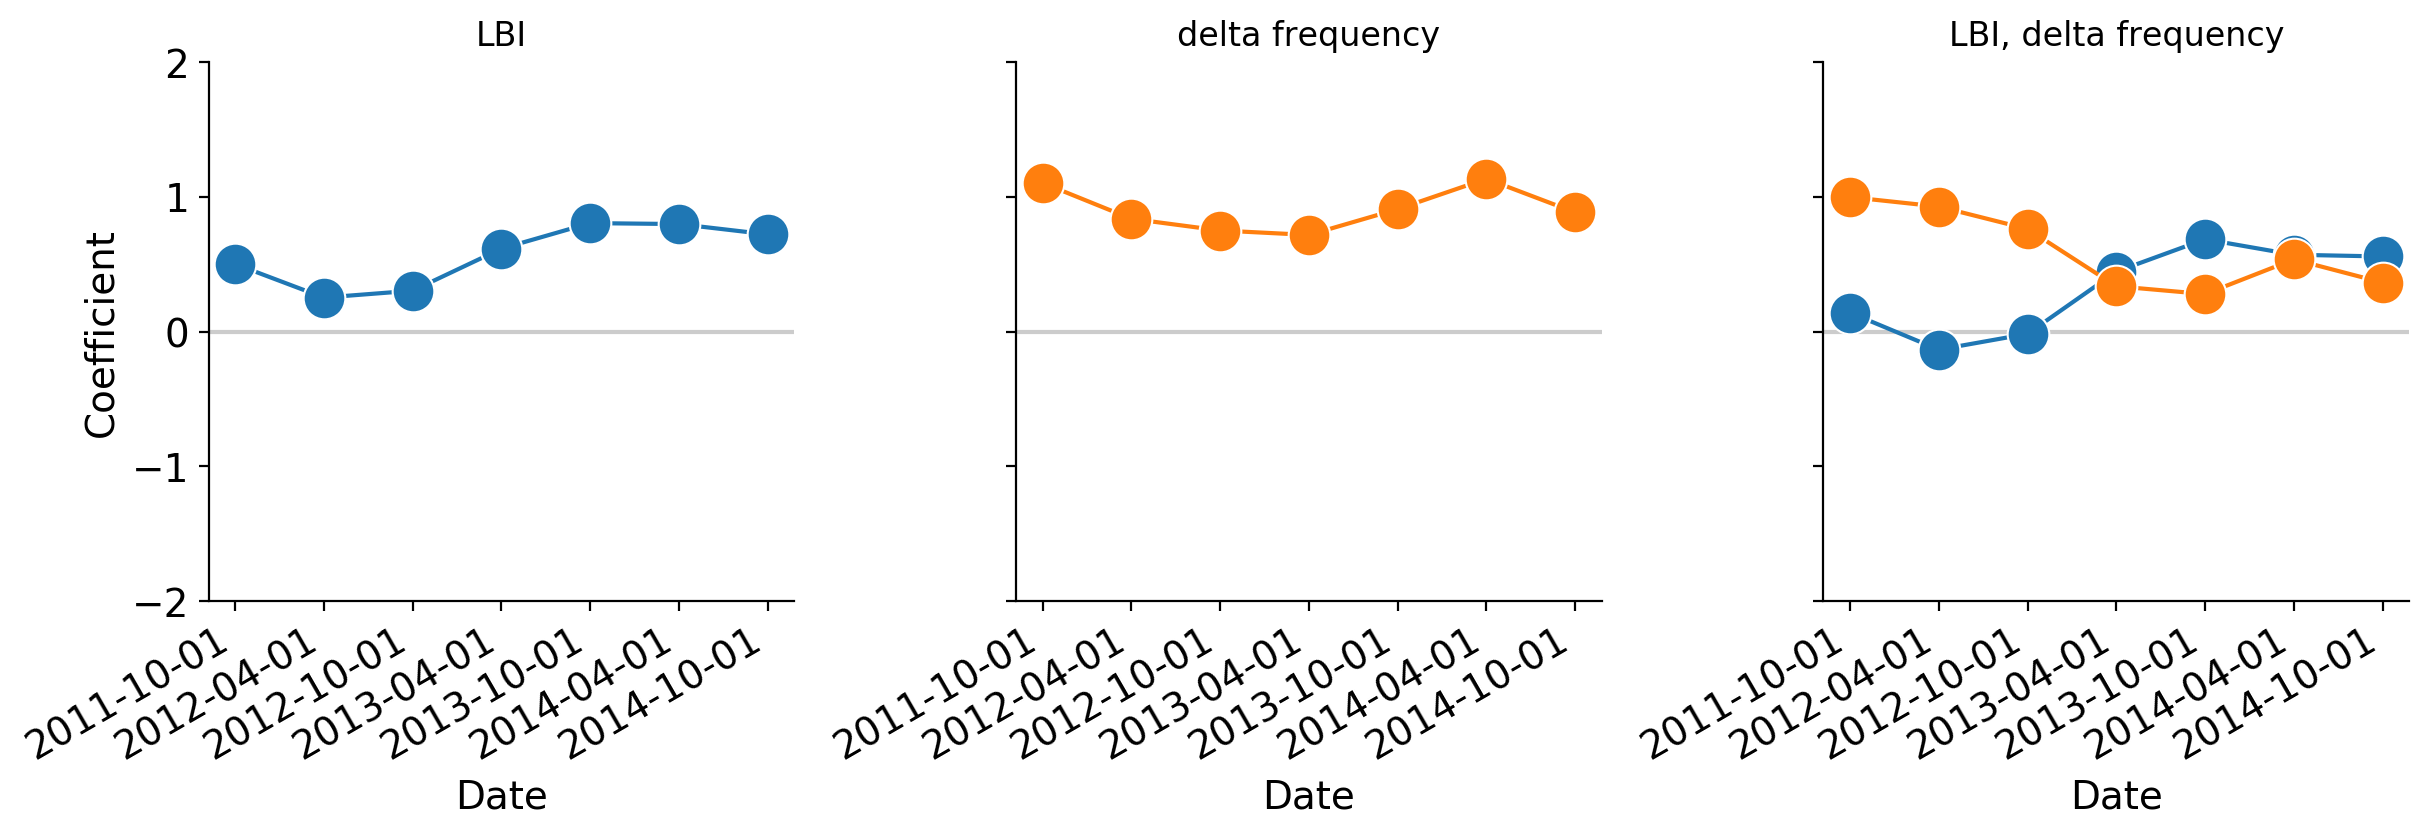

In [530]:
lbi_dfreq_order = ["lbi", "delta_frequency", "lbi-delta_frequency"]
lbi_dfreq_names = ["LBI", "delta frequency", "LBI, delta frequency"]
g = facet_time_plot(
    coefficients_by_time_df[coefficients_by_time_df["predictors"].isin(lbi_dfreq_order)],
    "coefficient",
    "Coefficient",
    timepoint_column="validation_timepoint",
    hue="predictor",
    col_order=lbi_dfreq_order
)

#g.set_titles("{col_name}")

for ci, ax in enumerate(g.axes.flatten()):
    ax.set_title(lbi_dfreq_names[ci], fontsize=12)
    ax.set_ylim(-2., 2.)

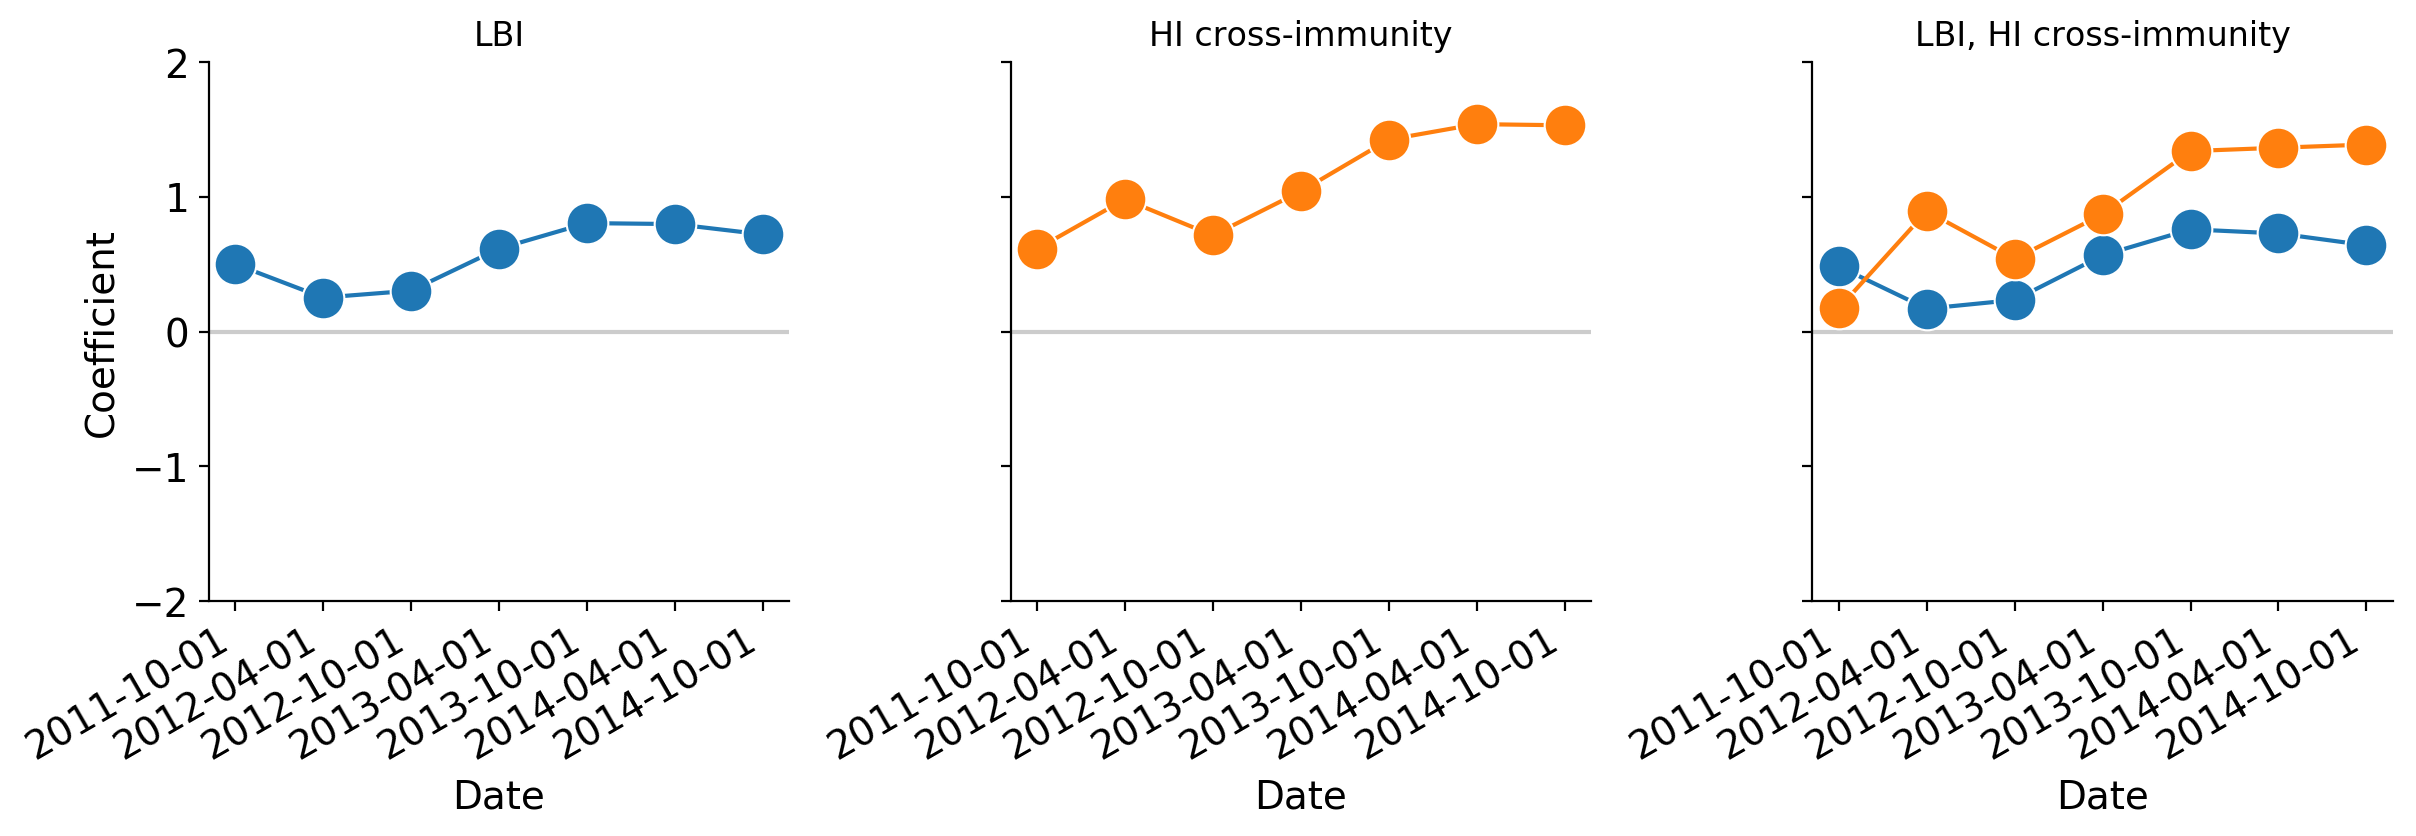

In [531]:
lbi_dfreq_order = ["lbi", "cTiterSub_x", "lbi-cTiterSub_x"]
lbi_dfreq_names = ["LBI", "HI cross-immunity", "LBI, HI cross-immunity"]
g = facet_time_plot(
    coefficients_by_time_df[coefficients_by_time_df["predictors"].isin(lbi_dfreq_order)],
    "coefficient",
    "Coefficient",
    timepoint_column="validation_timepoint",
    hue="predictor",
    col_order=lbi_dfreq_order
)

#g.set_titles("{col_name}")

for ci, ax in enumerate(g.axes.flatten()):
    ax.set_title(lbi_dfreq_names[ci], fontsize=12)
    ax.set_ylim(-2., 2.)